# NIL Masters 13/10/2023

## Targets

* NIL masters for Tim's project and general development of the process.
* The required gratings are:
  * Positive 1D grating.
  * Negative 1D grating.
  * Positive 2D grating.
  * Negative 2D grating.
  * Chirped 1D grating.
  * Negative chirped 1D grating?
* Tim also wants at least 2 rectangles of known and measurable widths suitable for the Dektak.
* Ideally these would all be on the same chip so that he has multiple identical chips for batch processing.

## Imports & Organisation

In [500]:
import os
import math
import numpy as np
import klayout.db as db

from pathlib import Path
from IPython.display import Markdown, display, Image

root = Path().absolute()
out_path = Path(f'{root}/Data')

## Writefield Size

* Start by setting the writefield size, i.e., the maximum size of one grating.
* On the Raith voyager system, this is usually 500x500 $\mu m$.

In [501]:
writefield_height = 500
writefield_width = 500
chip_height = 15000
chip_width = 15000

* Here we assume that the database layout will already be in $\mu m$.
* Later we will make sure that we apply this properly.

## Database Setup

* It makes sense to use one database for the chip in that instance, so I will create one database here.
* I will set the units to $\mu m$.

In [502]:
layout = db.Layout()
layout.dbu = 0.001
sample_identifier = "AM4-7"
top_cell = layout.create_cell(f'{sample_identifier}')

### Design

* Asked to create a series of gratings for the NIL project.
* The gratings should include nanoholes, flat gratings, and chirped gratings.
* Need to make sure we have big text too.

* Tested some rough nanohole simulations in an S4 simulation with the following parameters.

In [503]:
json_path = Path(f'{root}/../S4/S4_parameters.json')
display(Markdown(f'{json_path}'))

{
    "harmonics": 21,
    "period": 300,
    "fill_factor": 0.7,
    "cover": "Air",
    "cover_n": 1,
    "cover_k": 0,
    "layer_1": "SiliconNitride",
    "layer_1_n": 1.89296,
    "layer_1_k": 0,
    "layer_1_thickness": 150,
    "substrate": "SiliconDioxide",
    "substrate_n": 1.4565,
    "substrate_k": 0,
    "wavelength_initial": 500,
    "wavelength_final": 801,
    "wavelength_step": 1,
    "TE": 1,
    "TM": 0
}

* This produced the following results for varying the nanohole period.

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_300.png


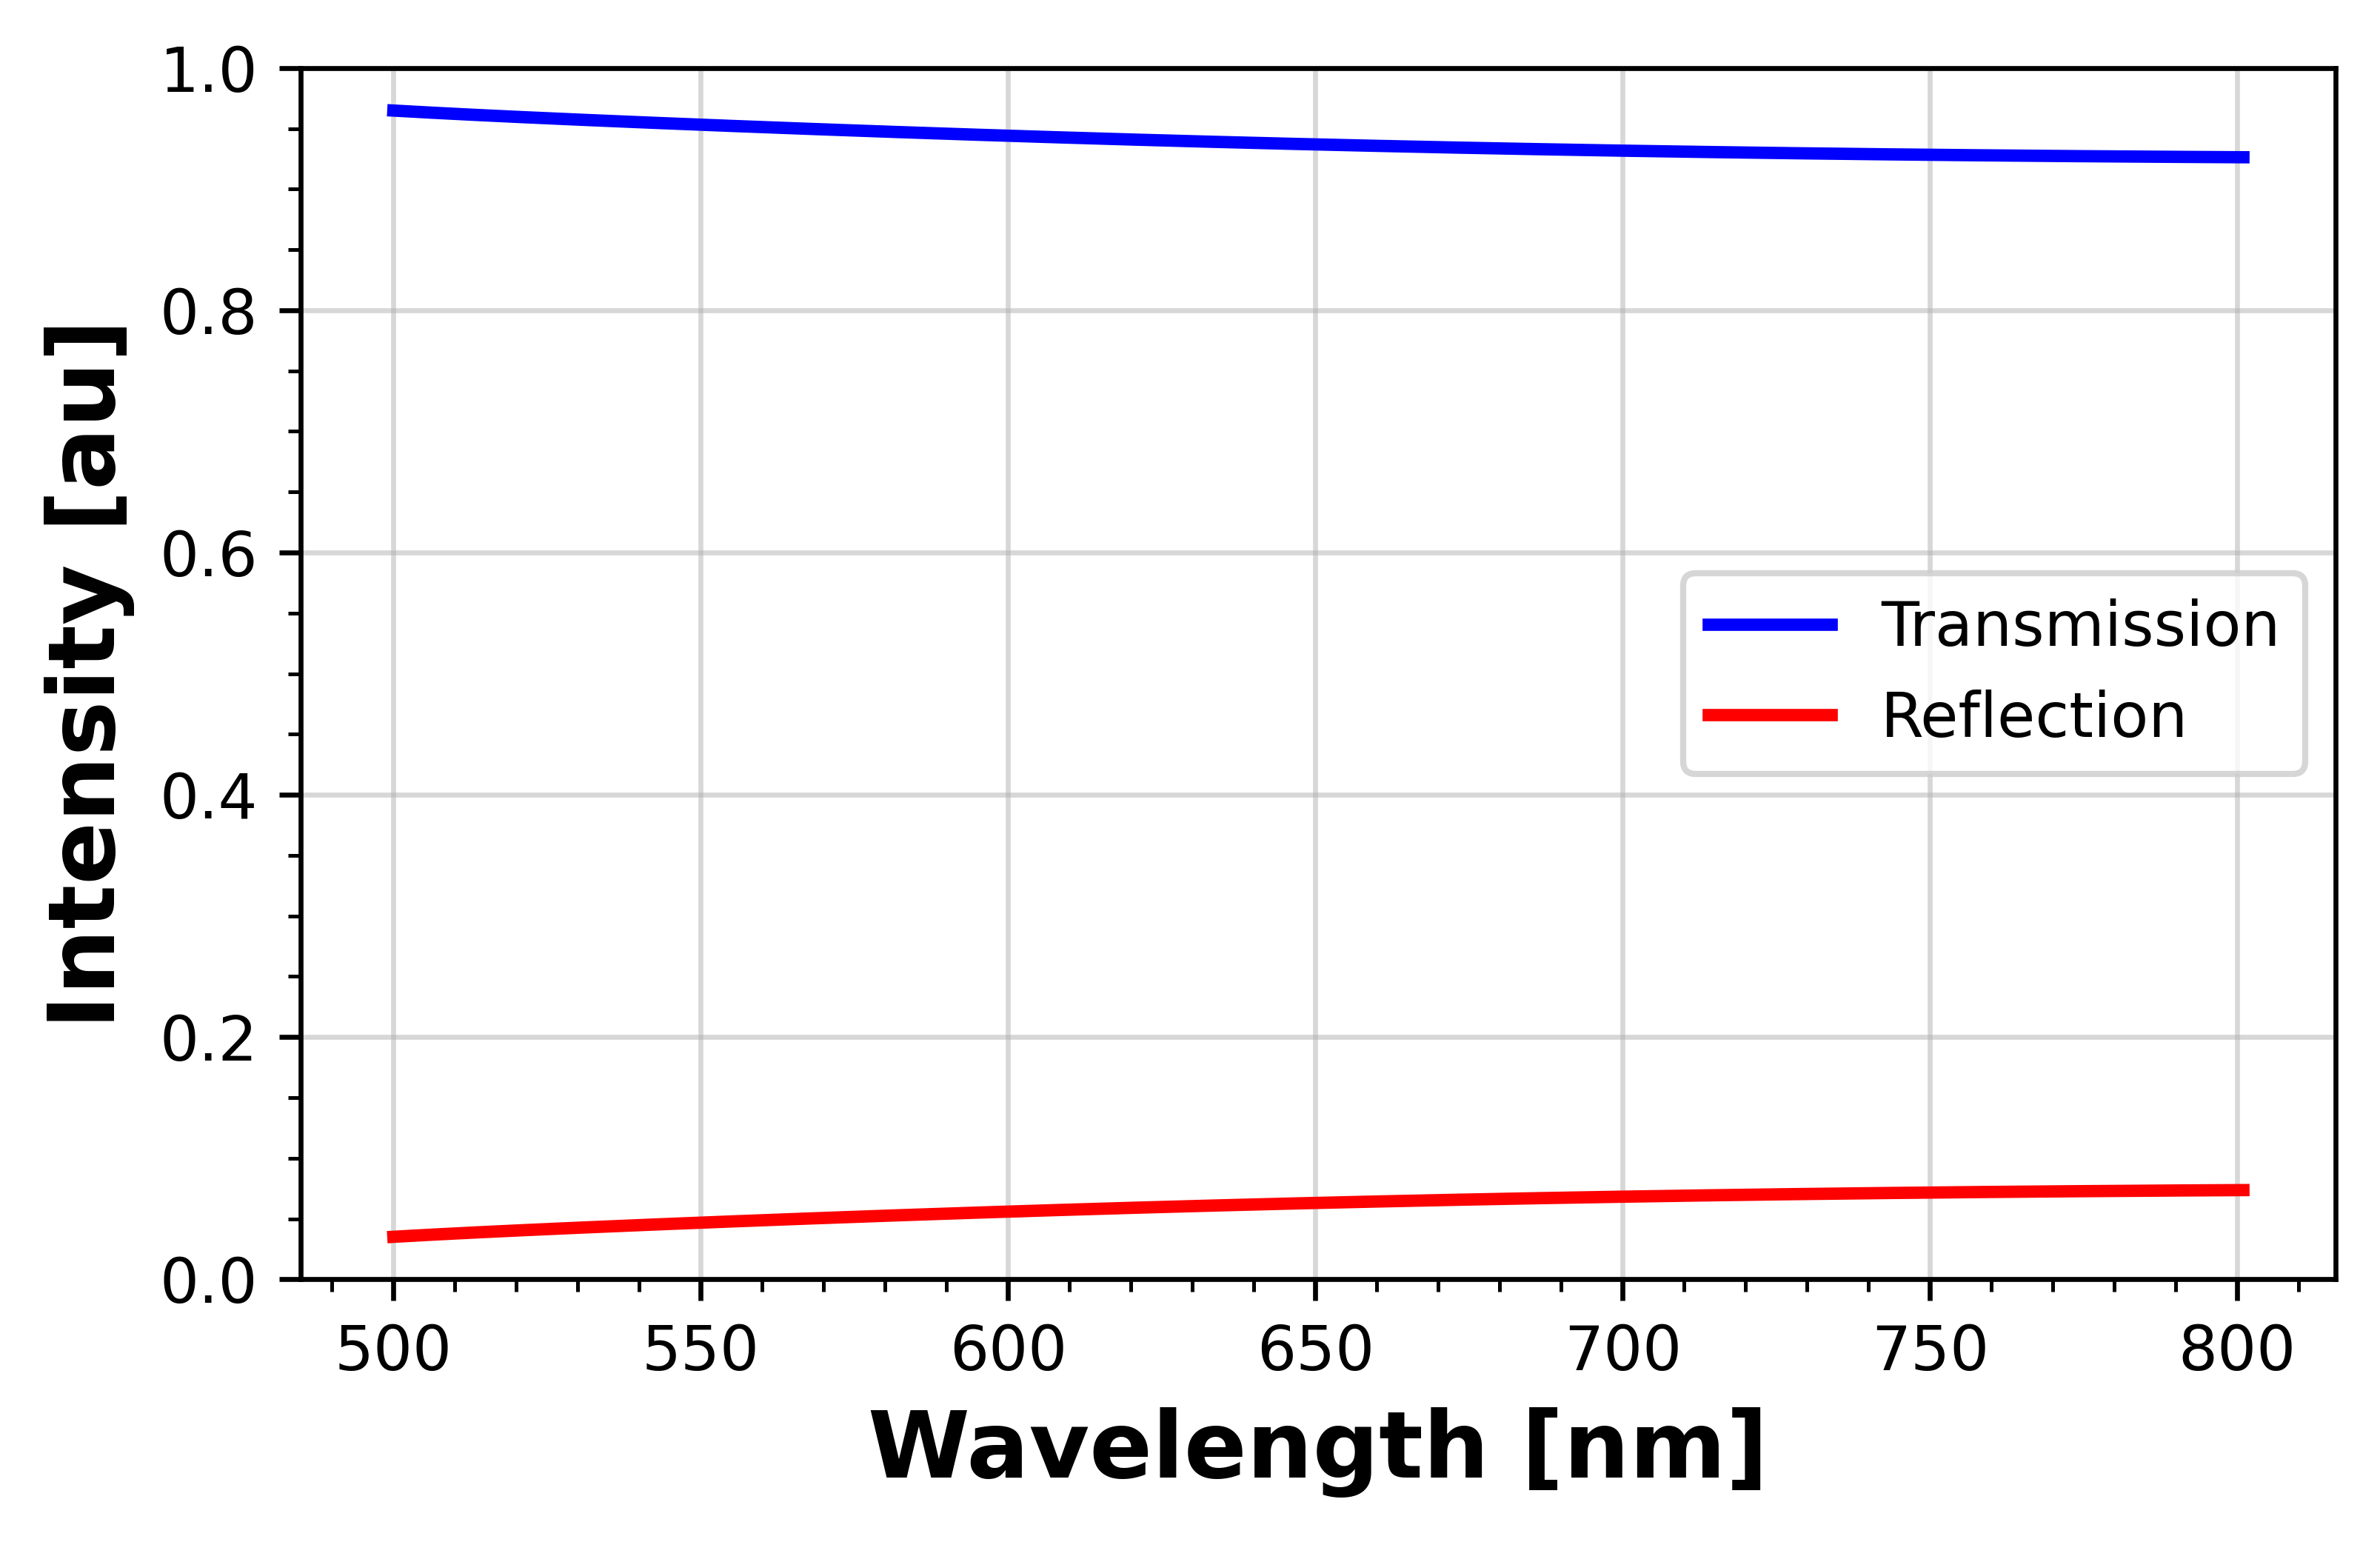

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_350.png


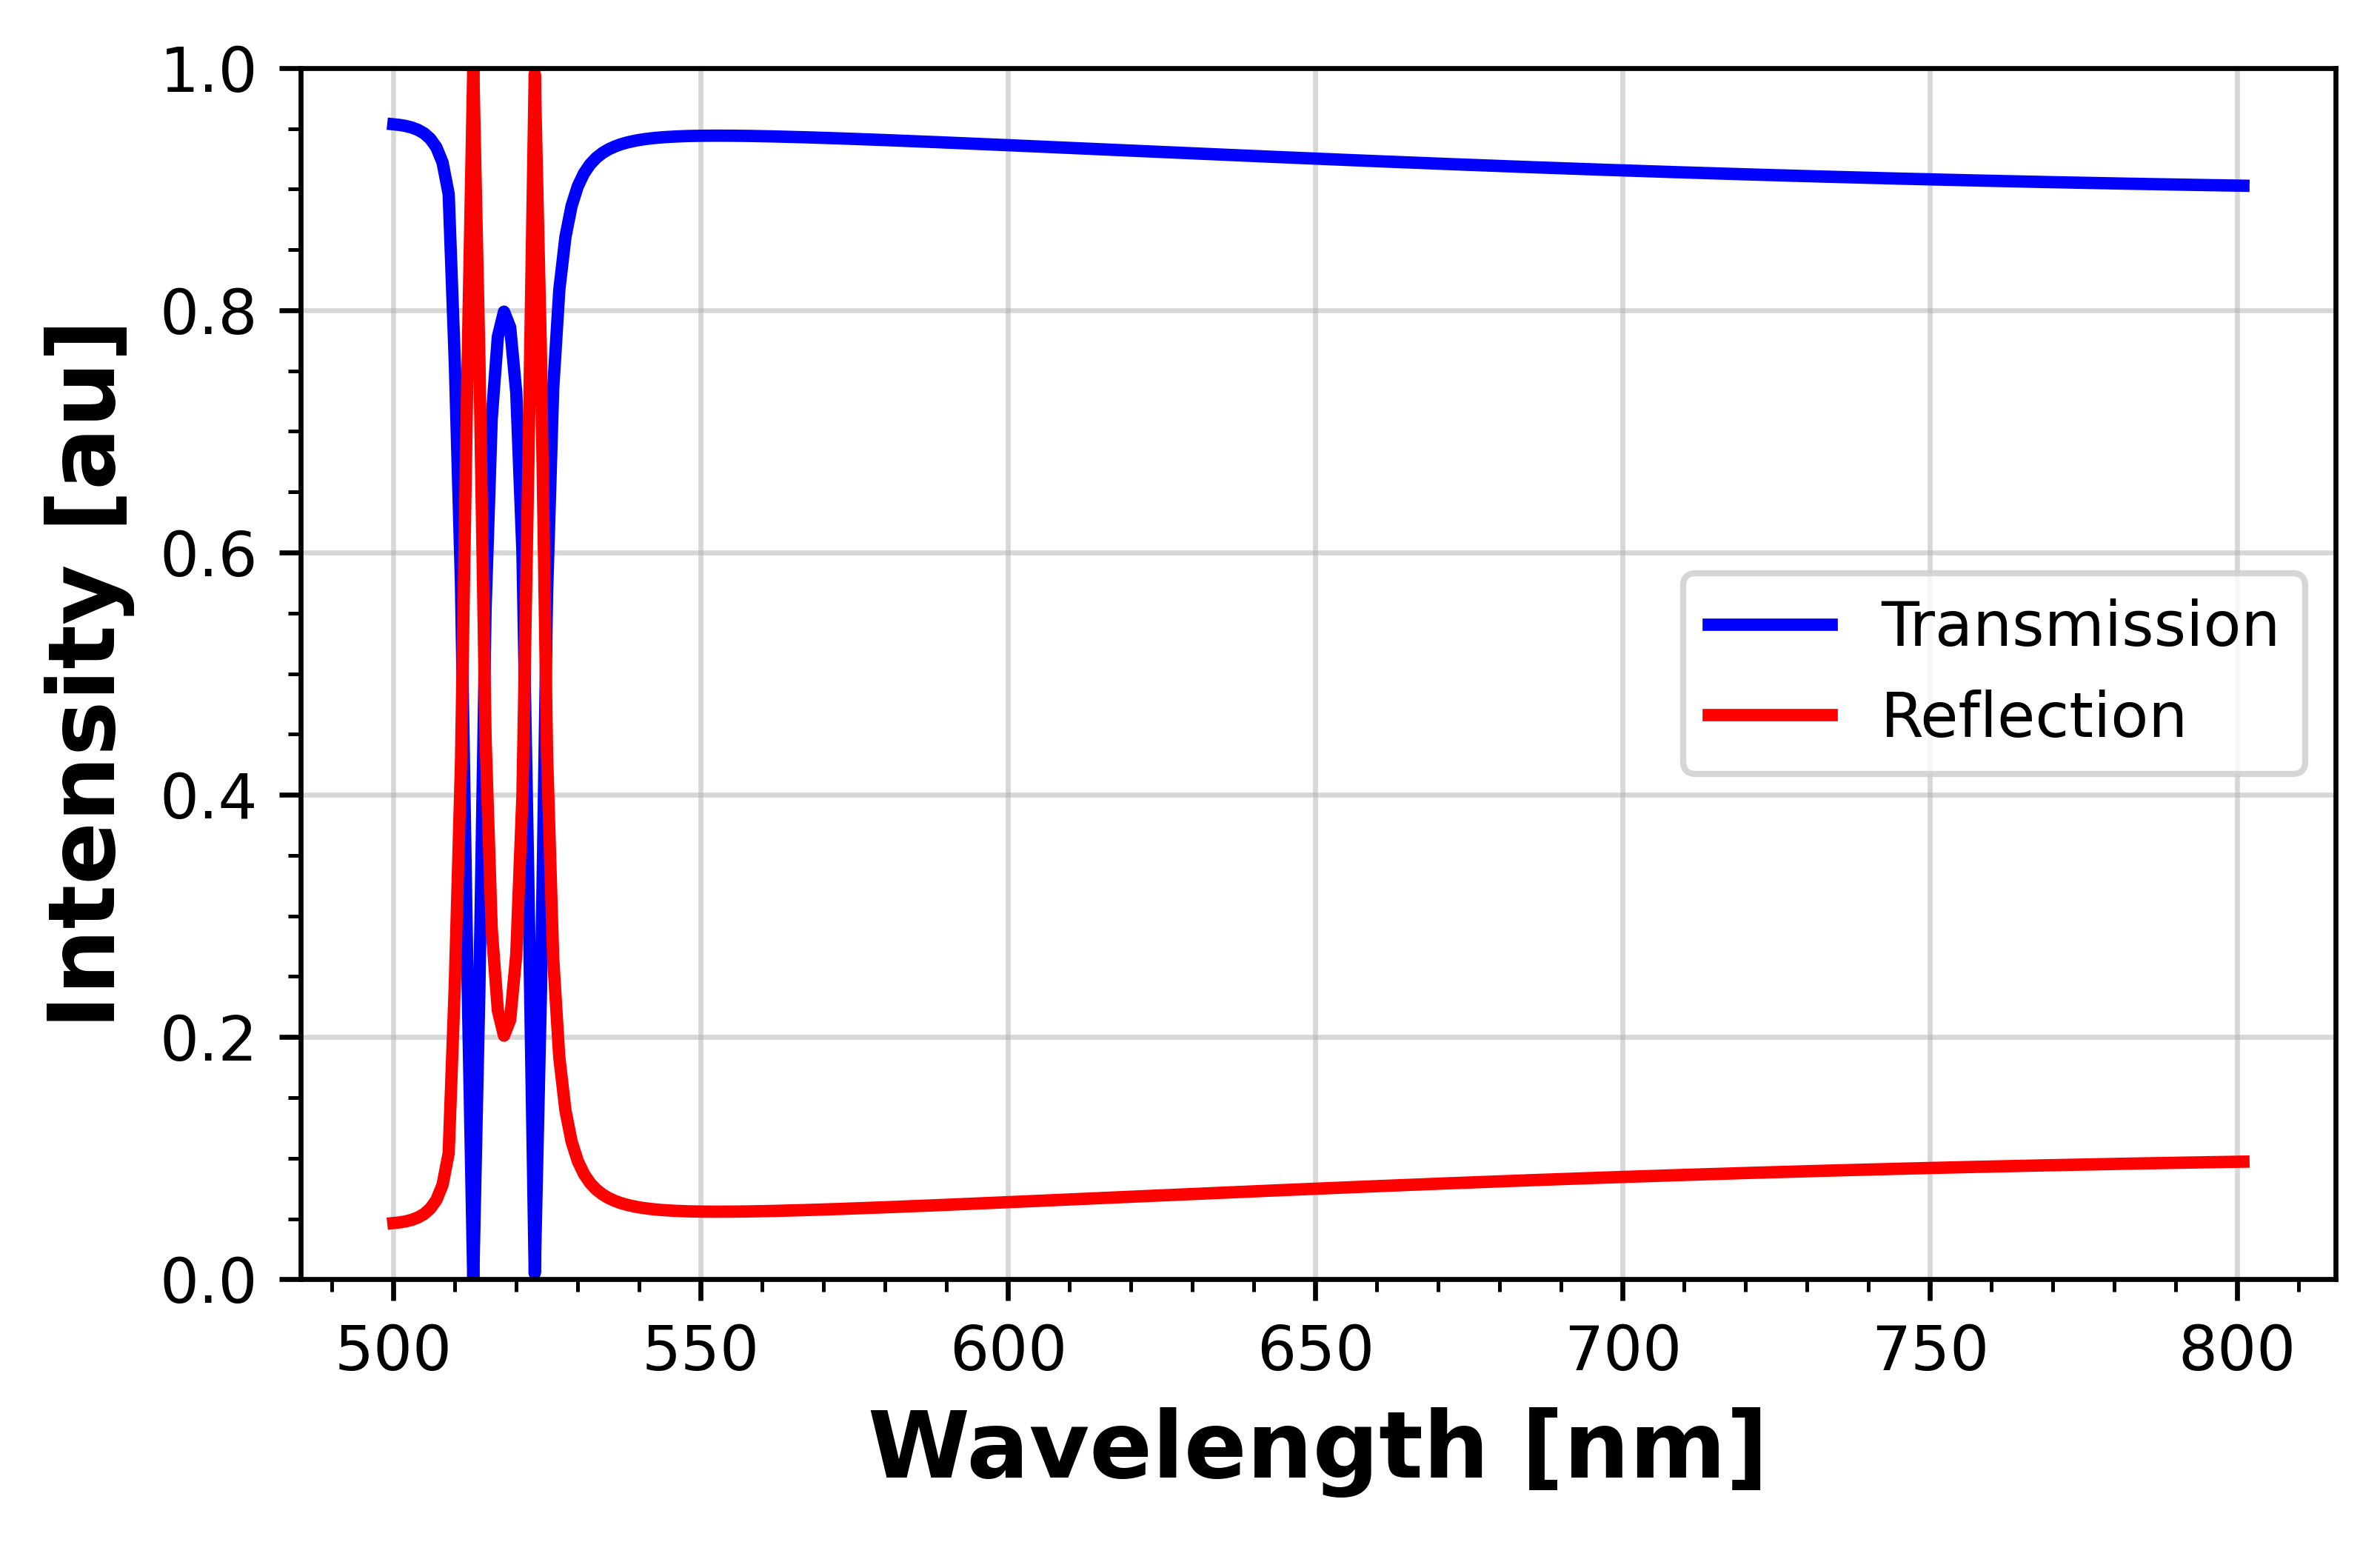

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_400.png


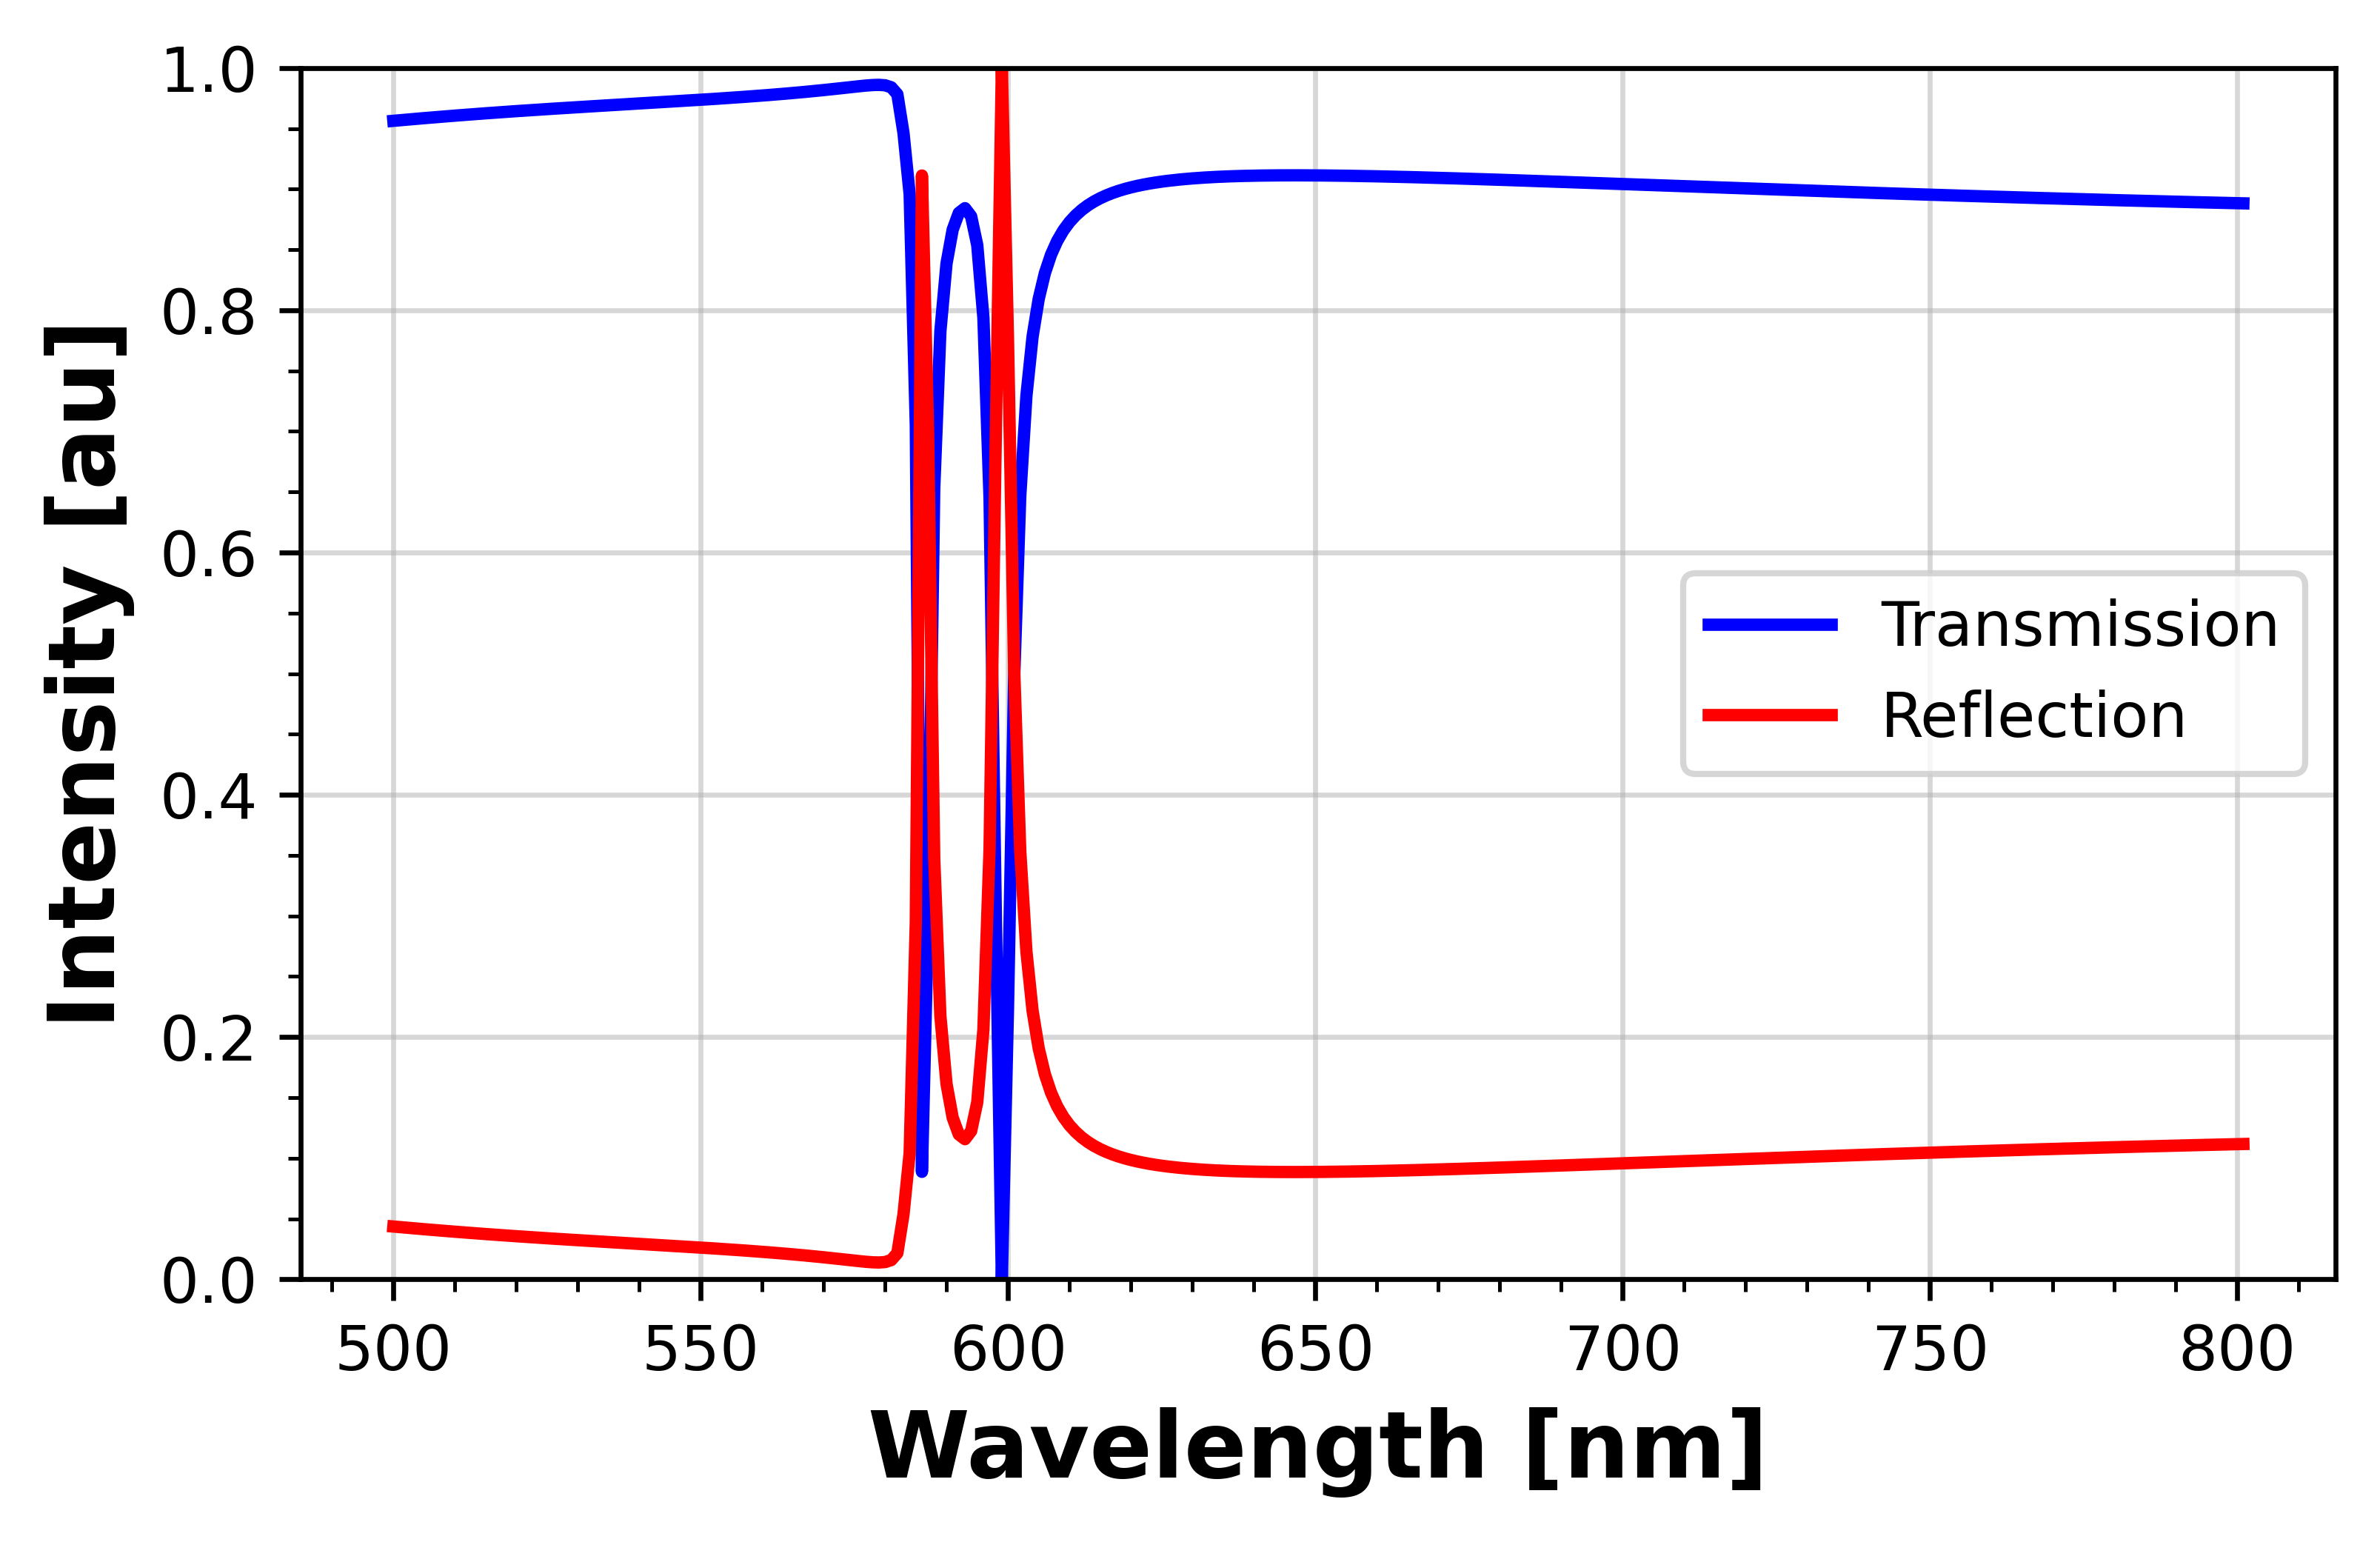

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_450.png


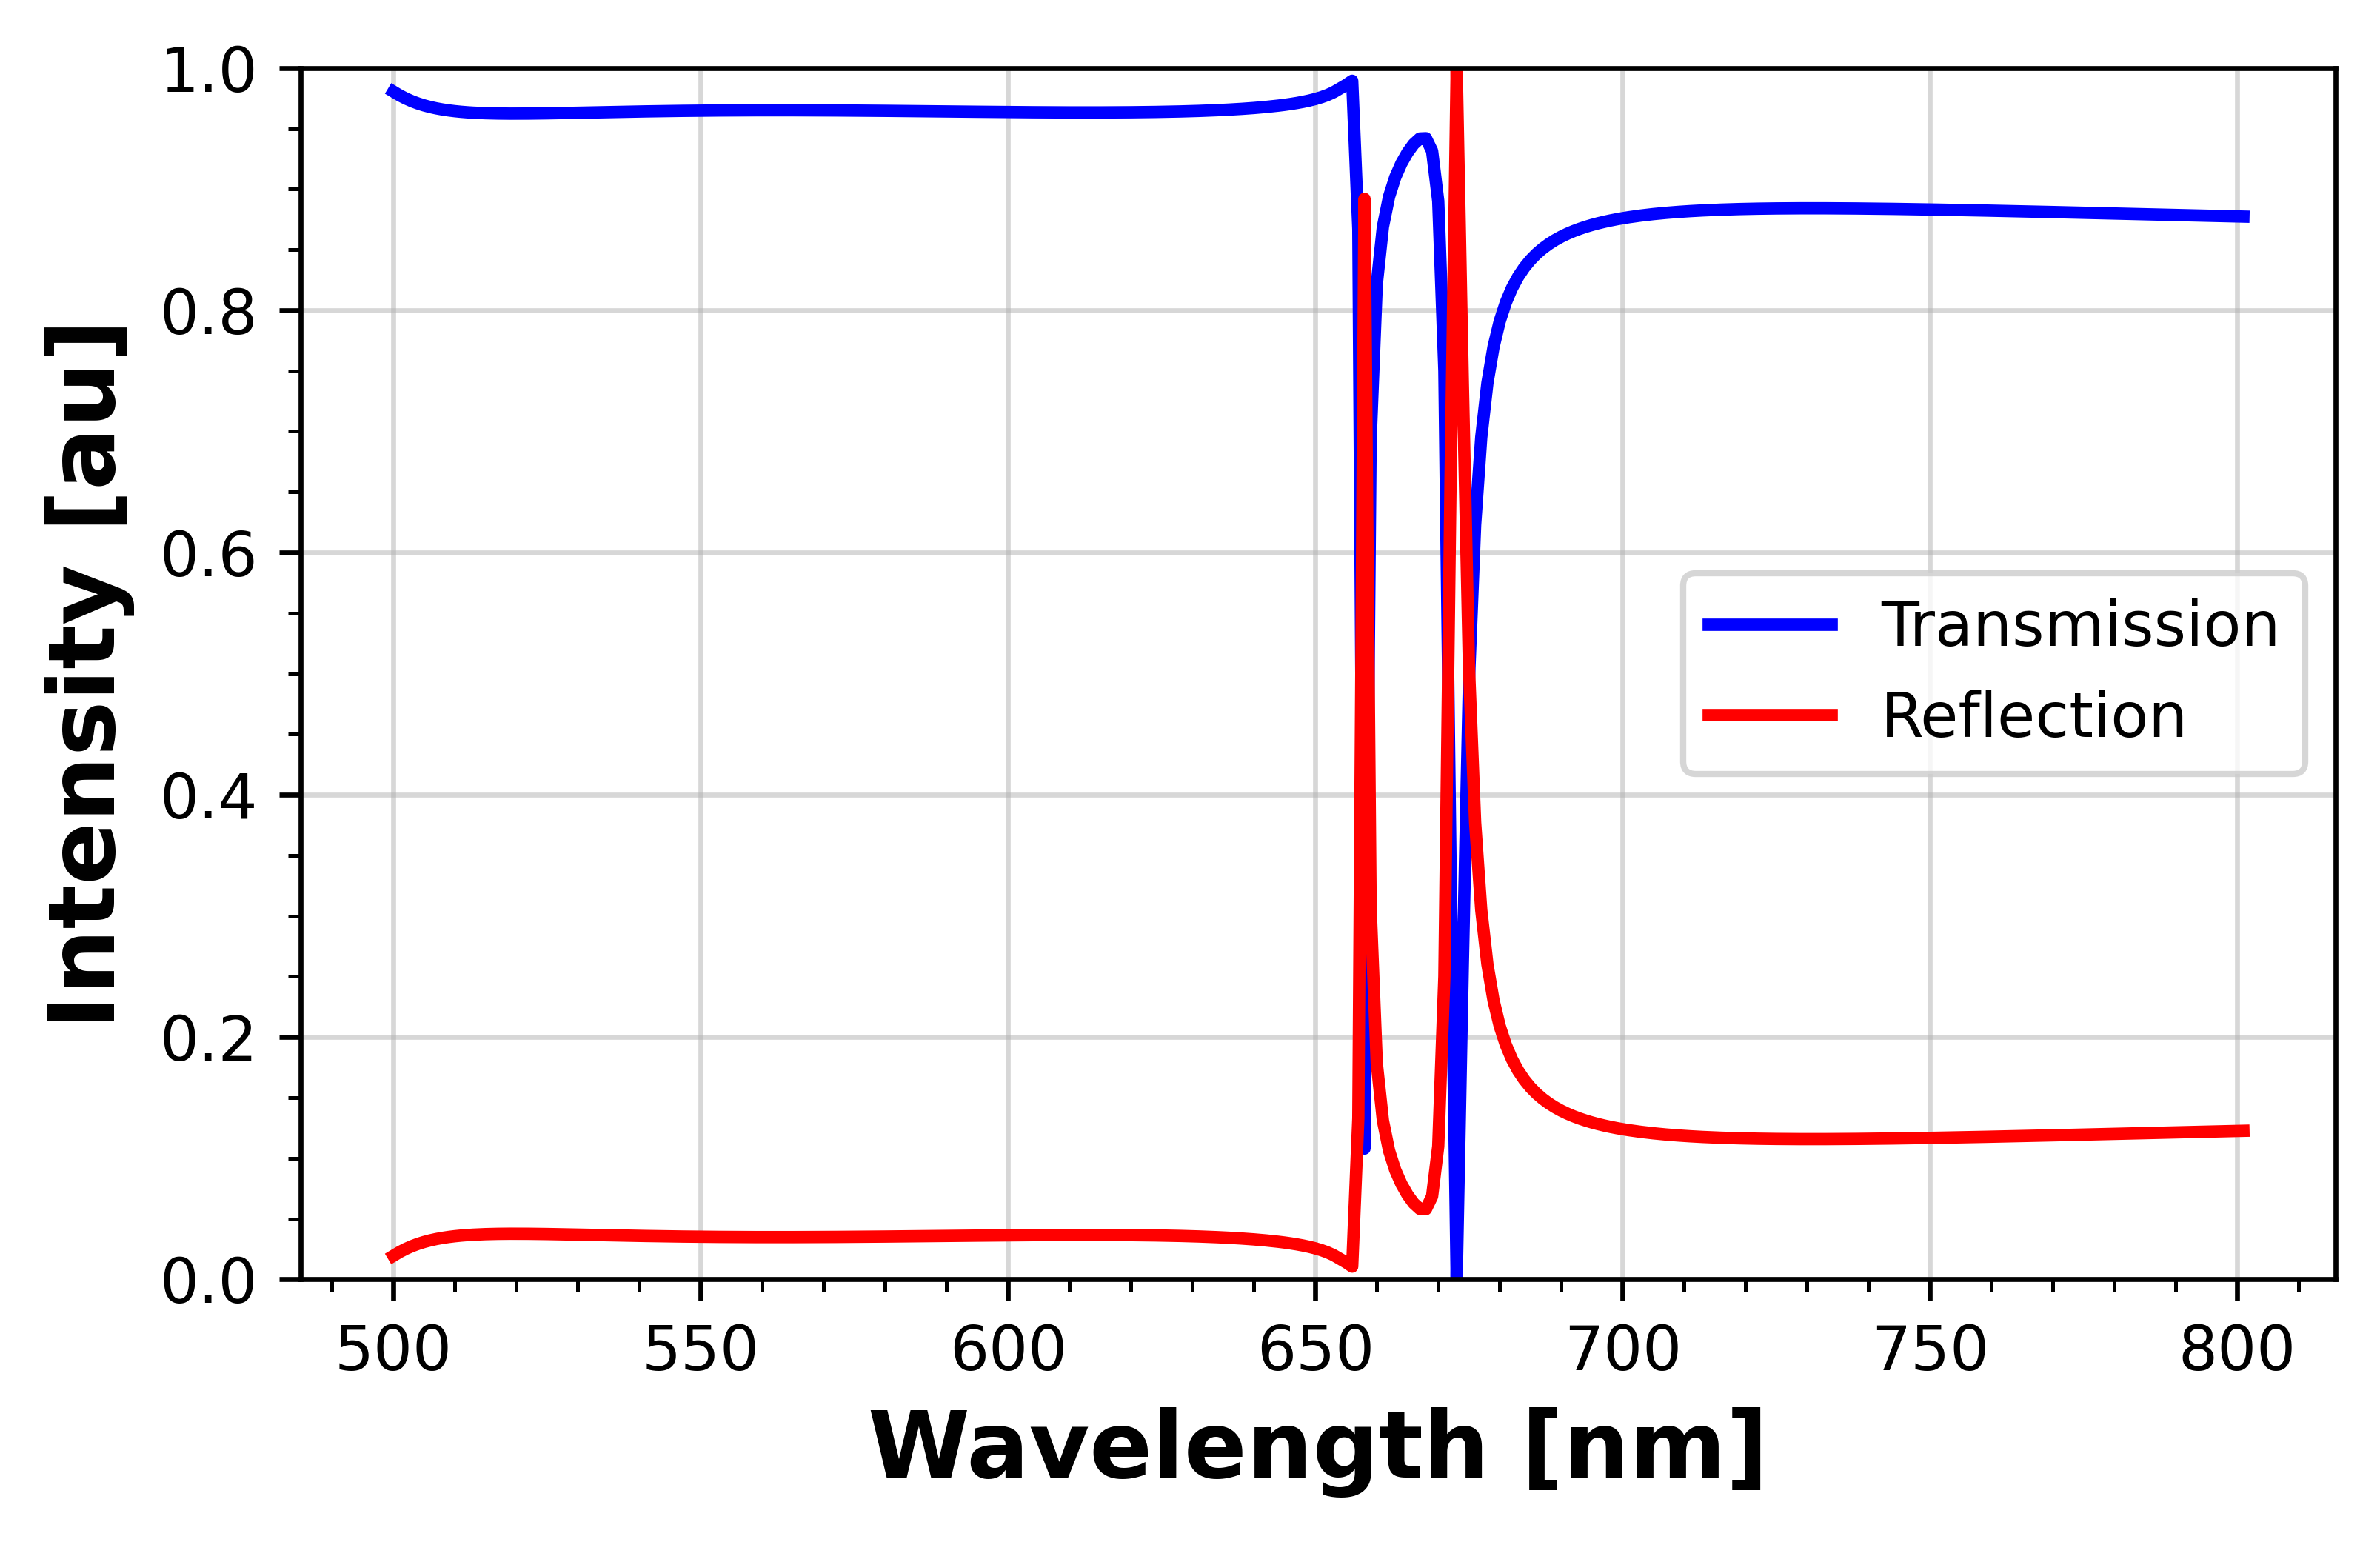

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_500.png


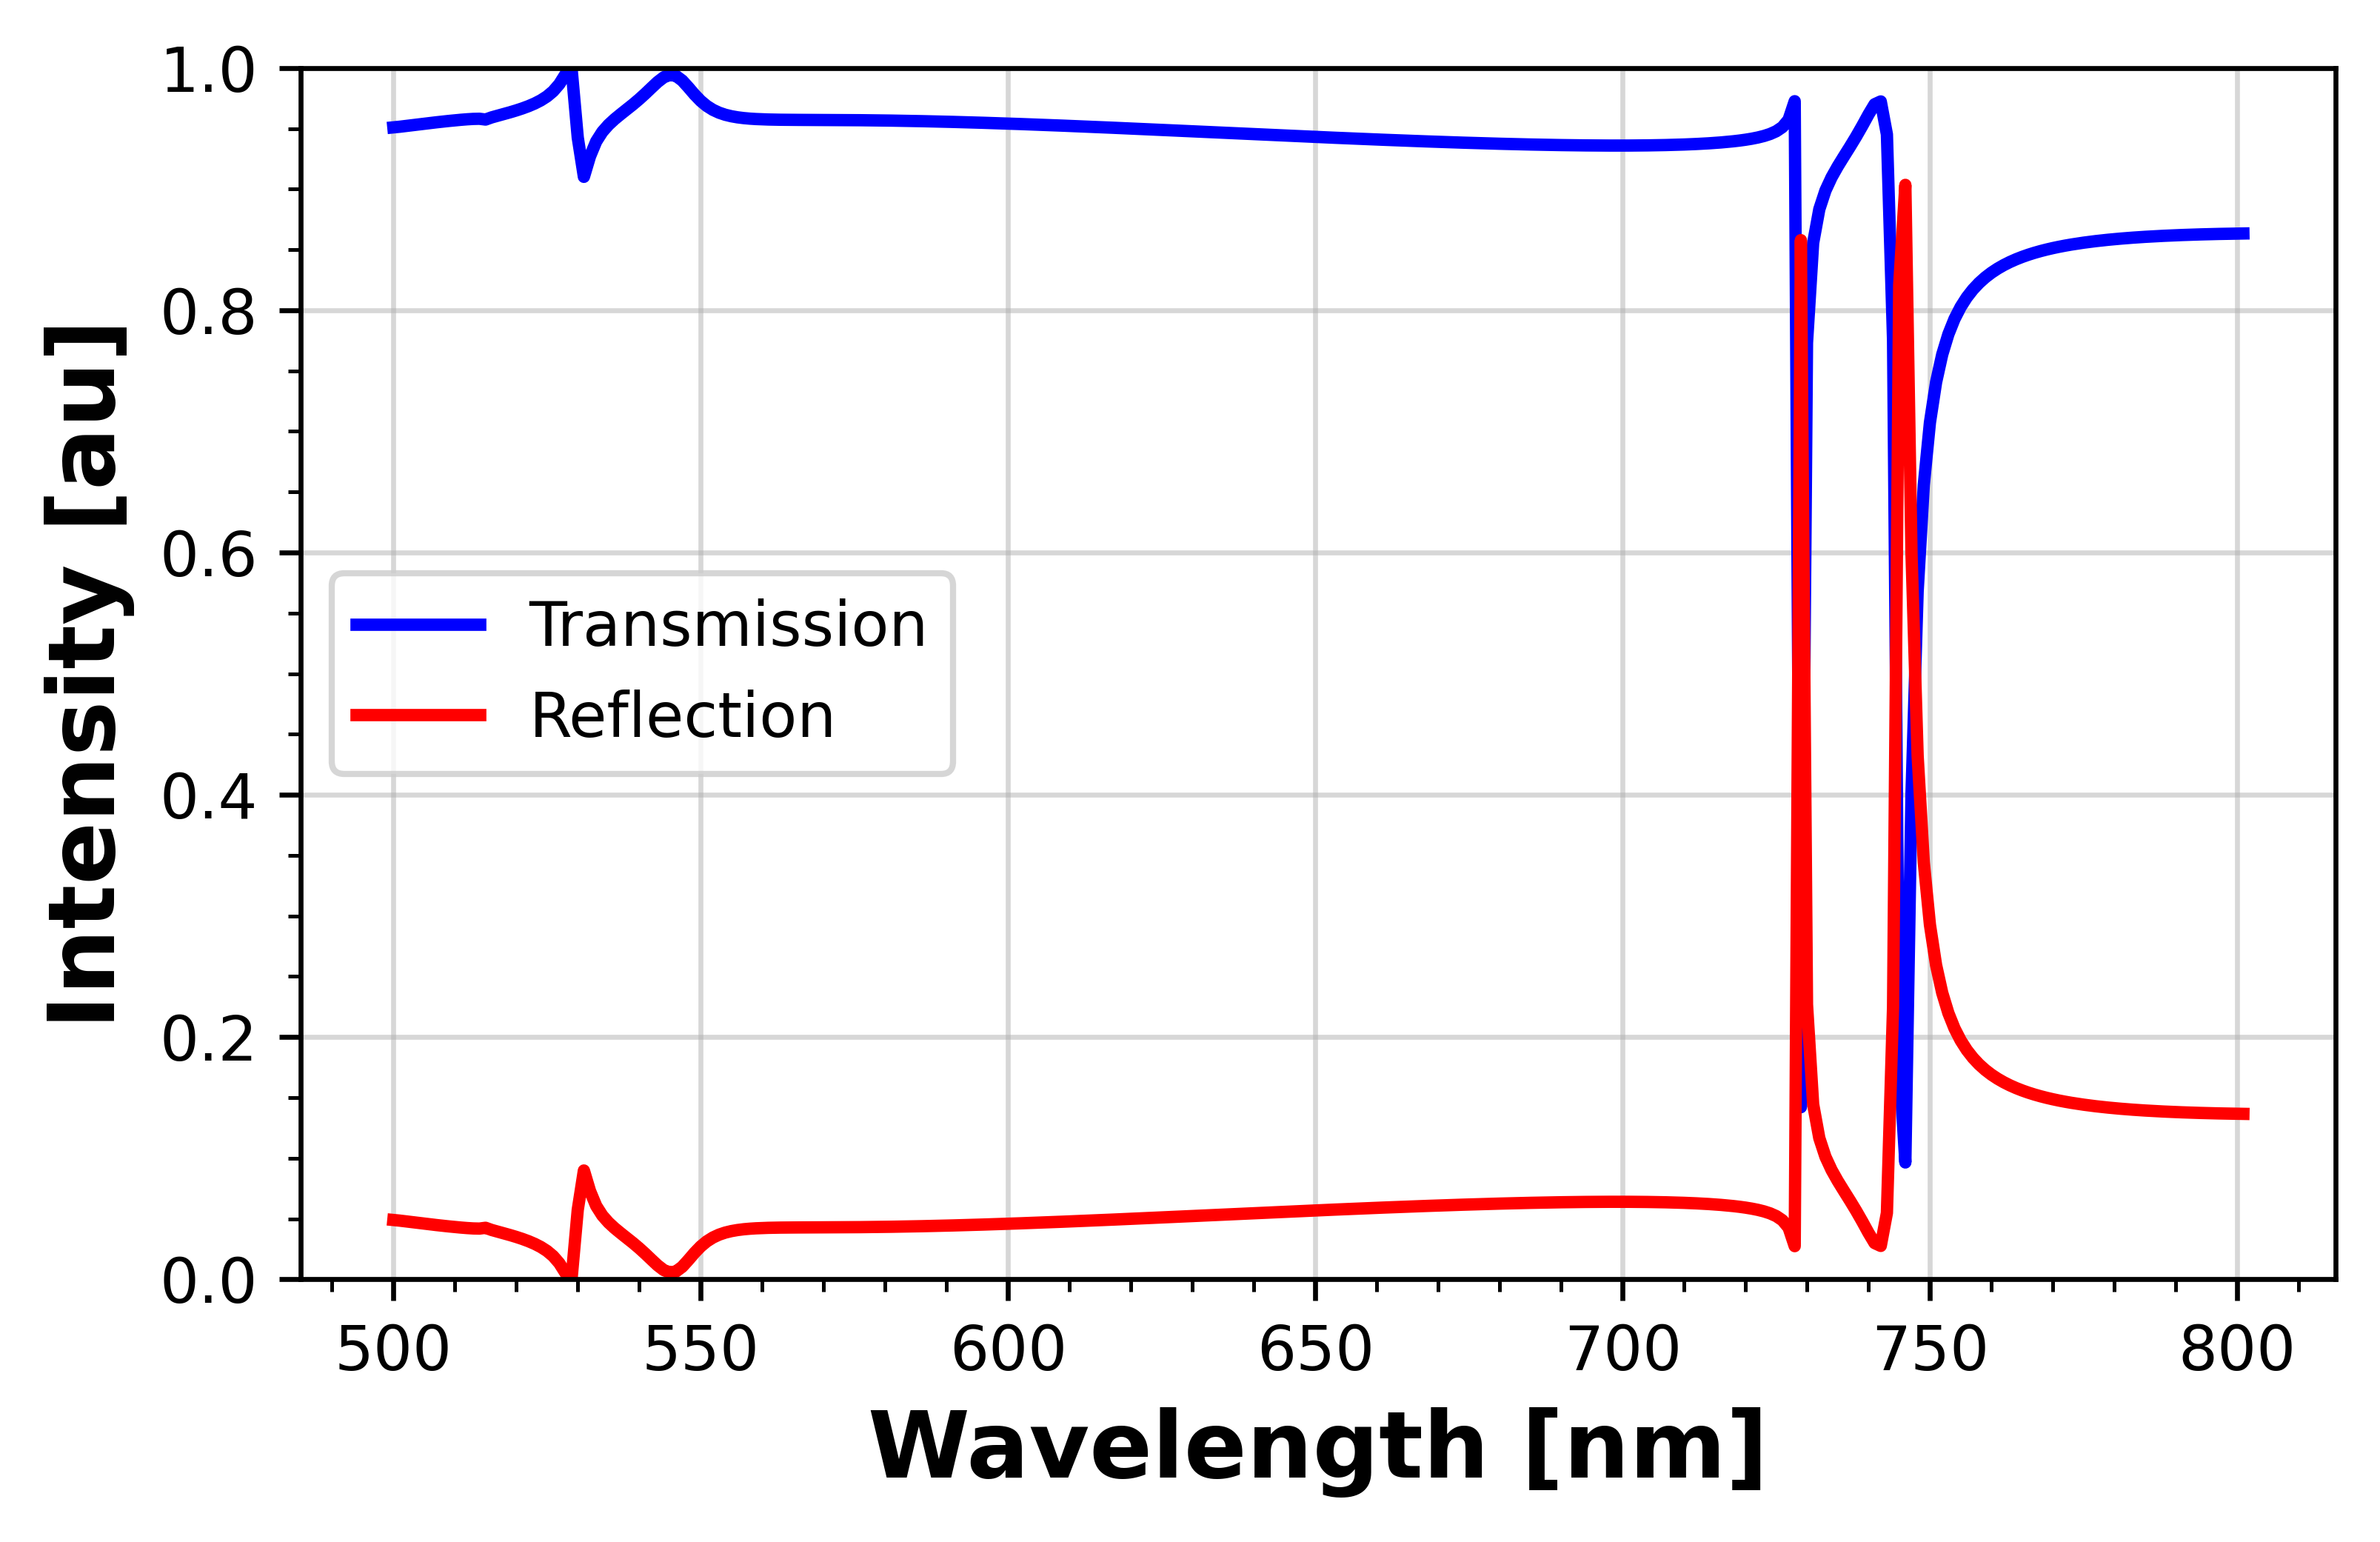

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_550.png


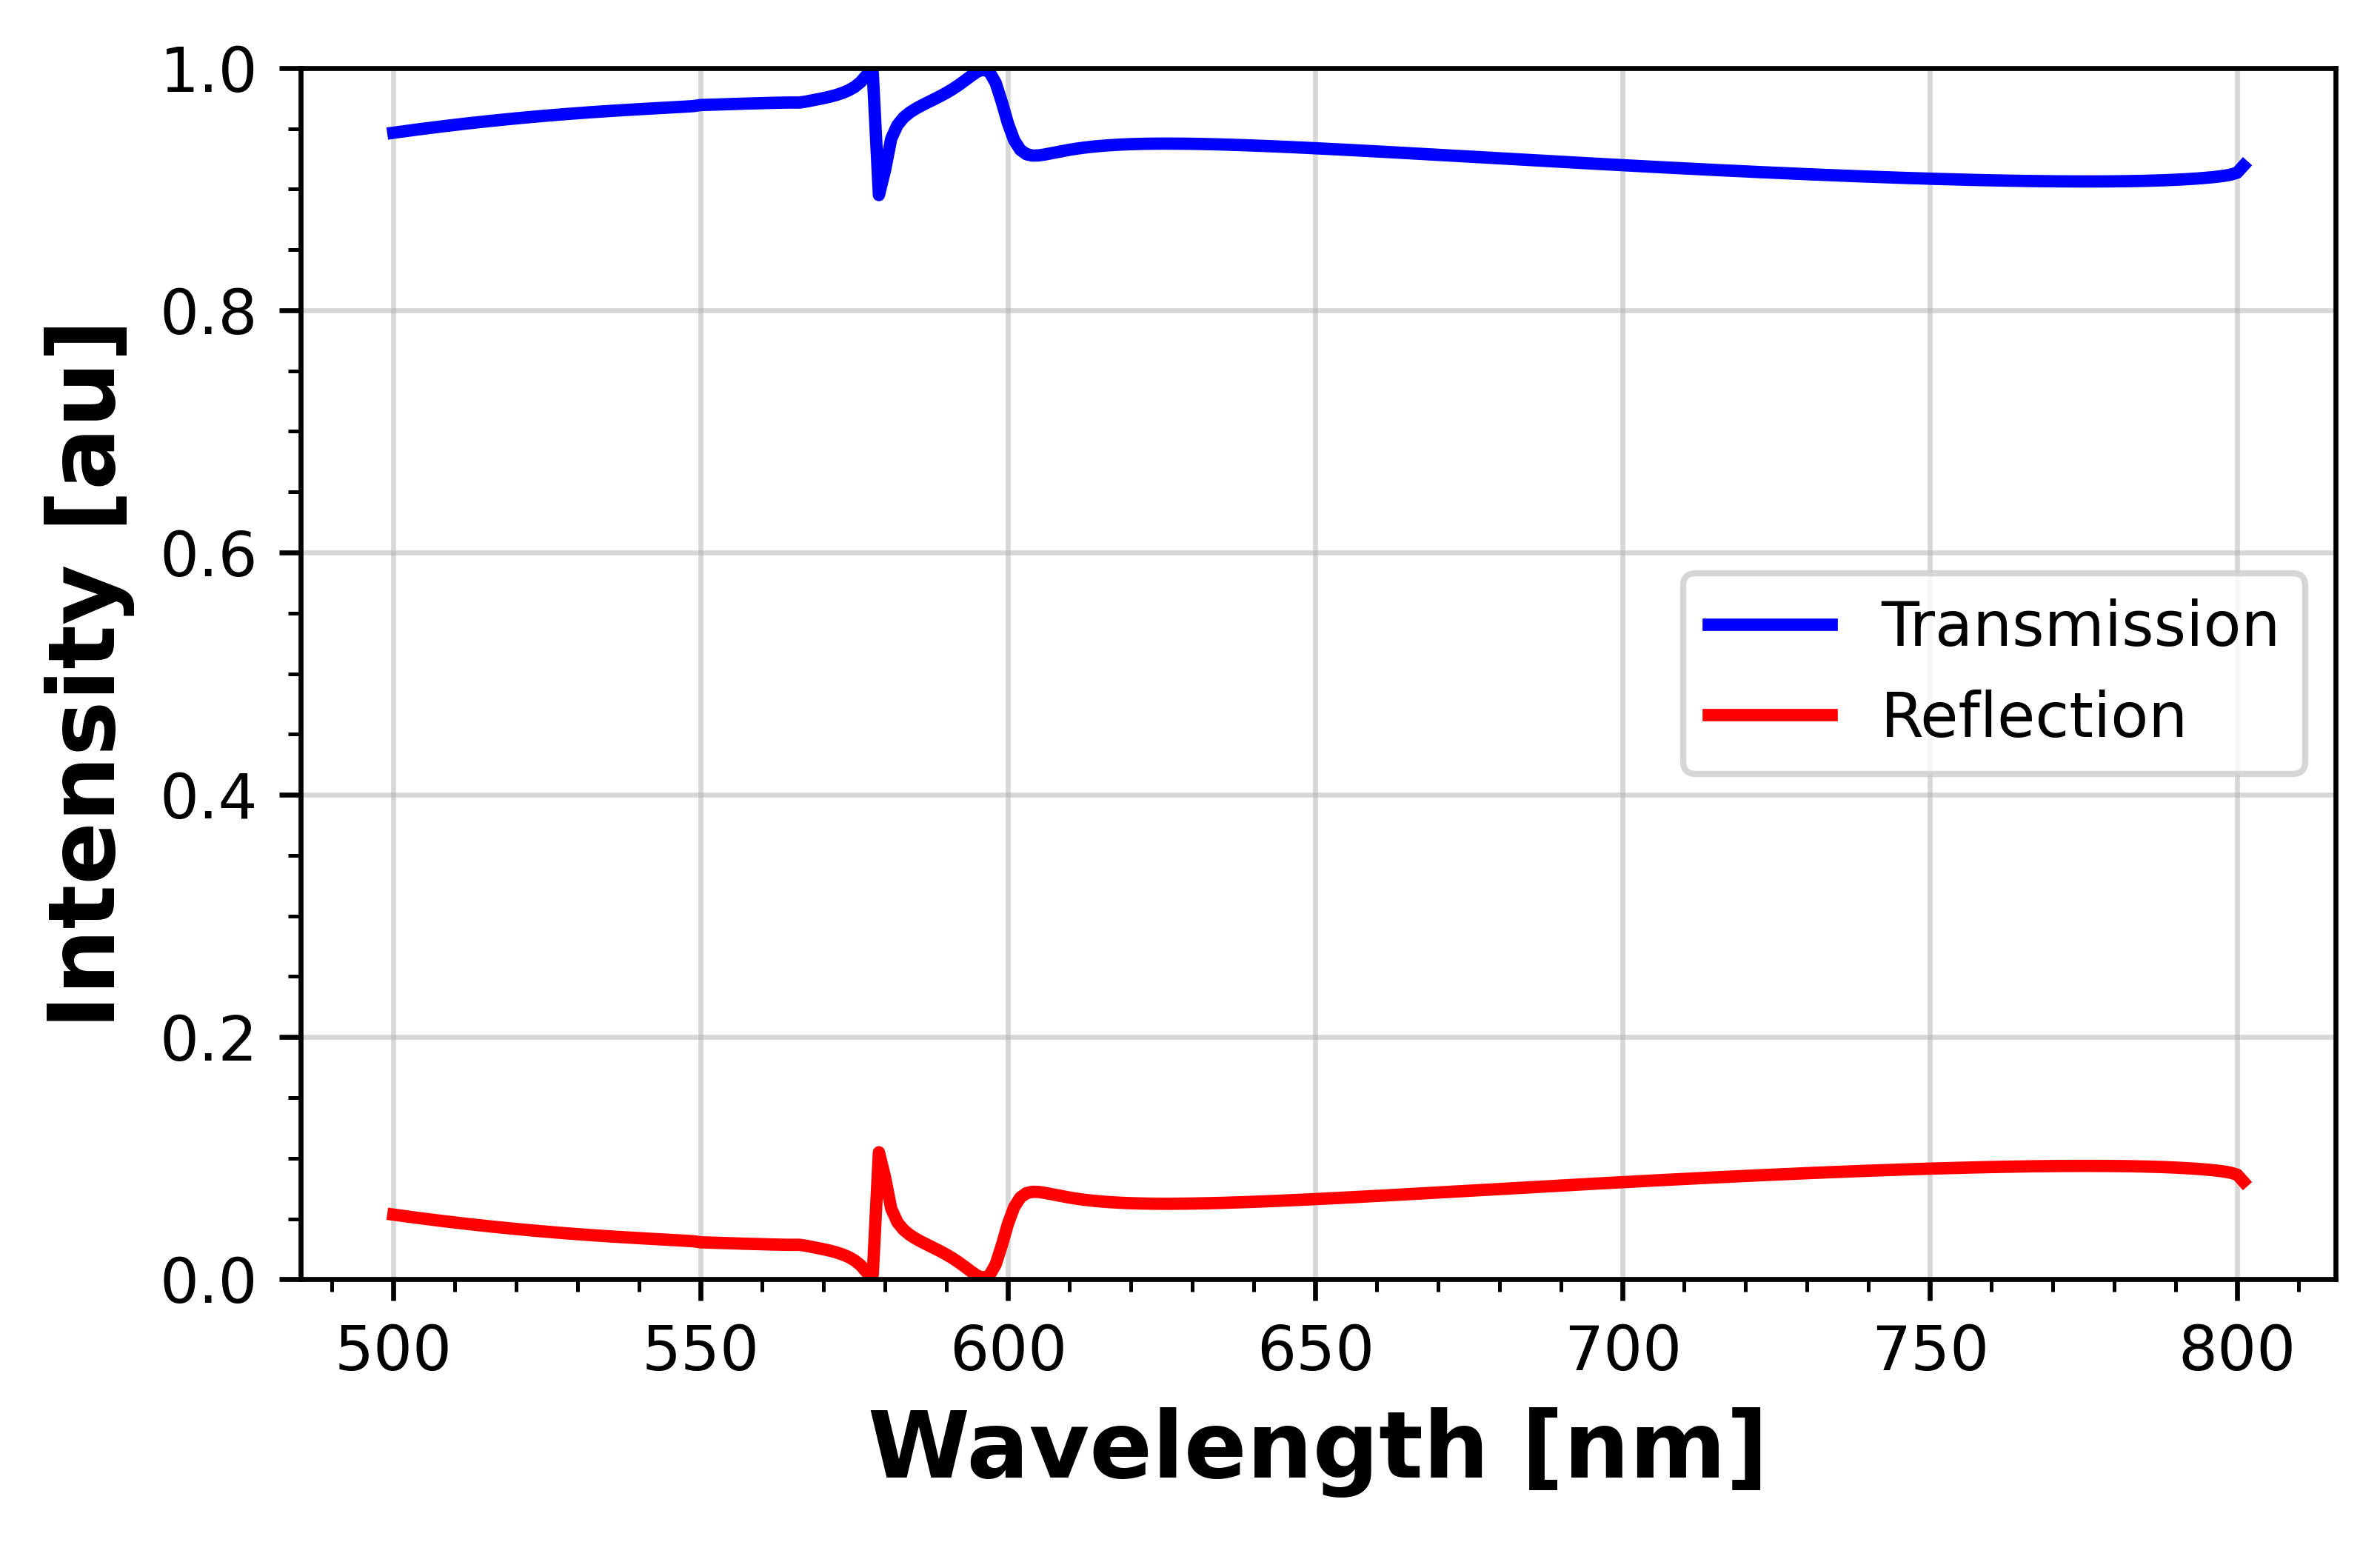

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_600.png


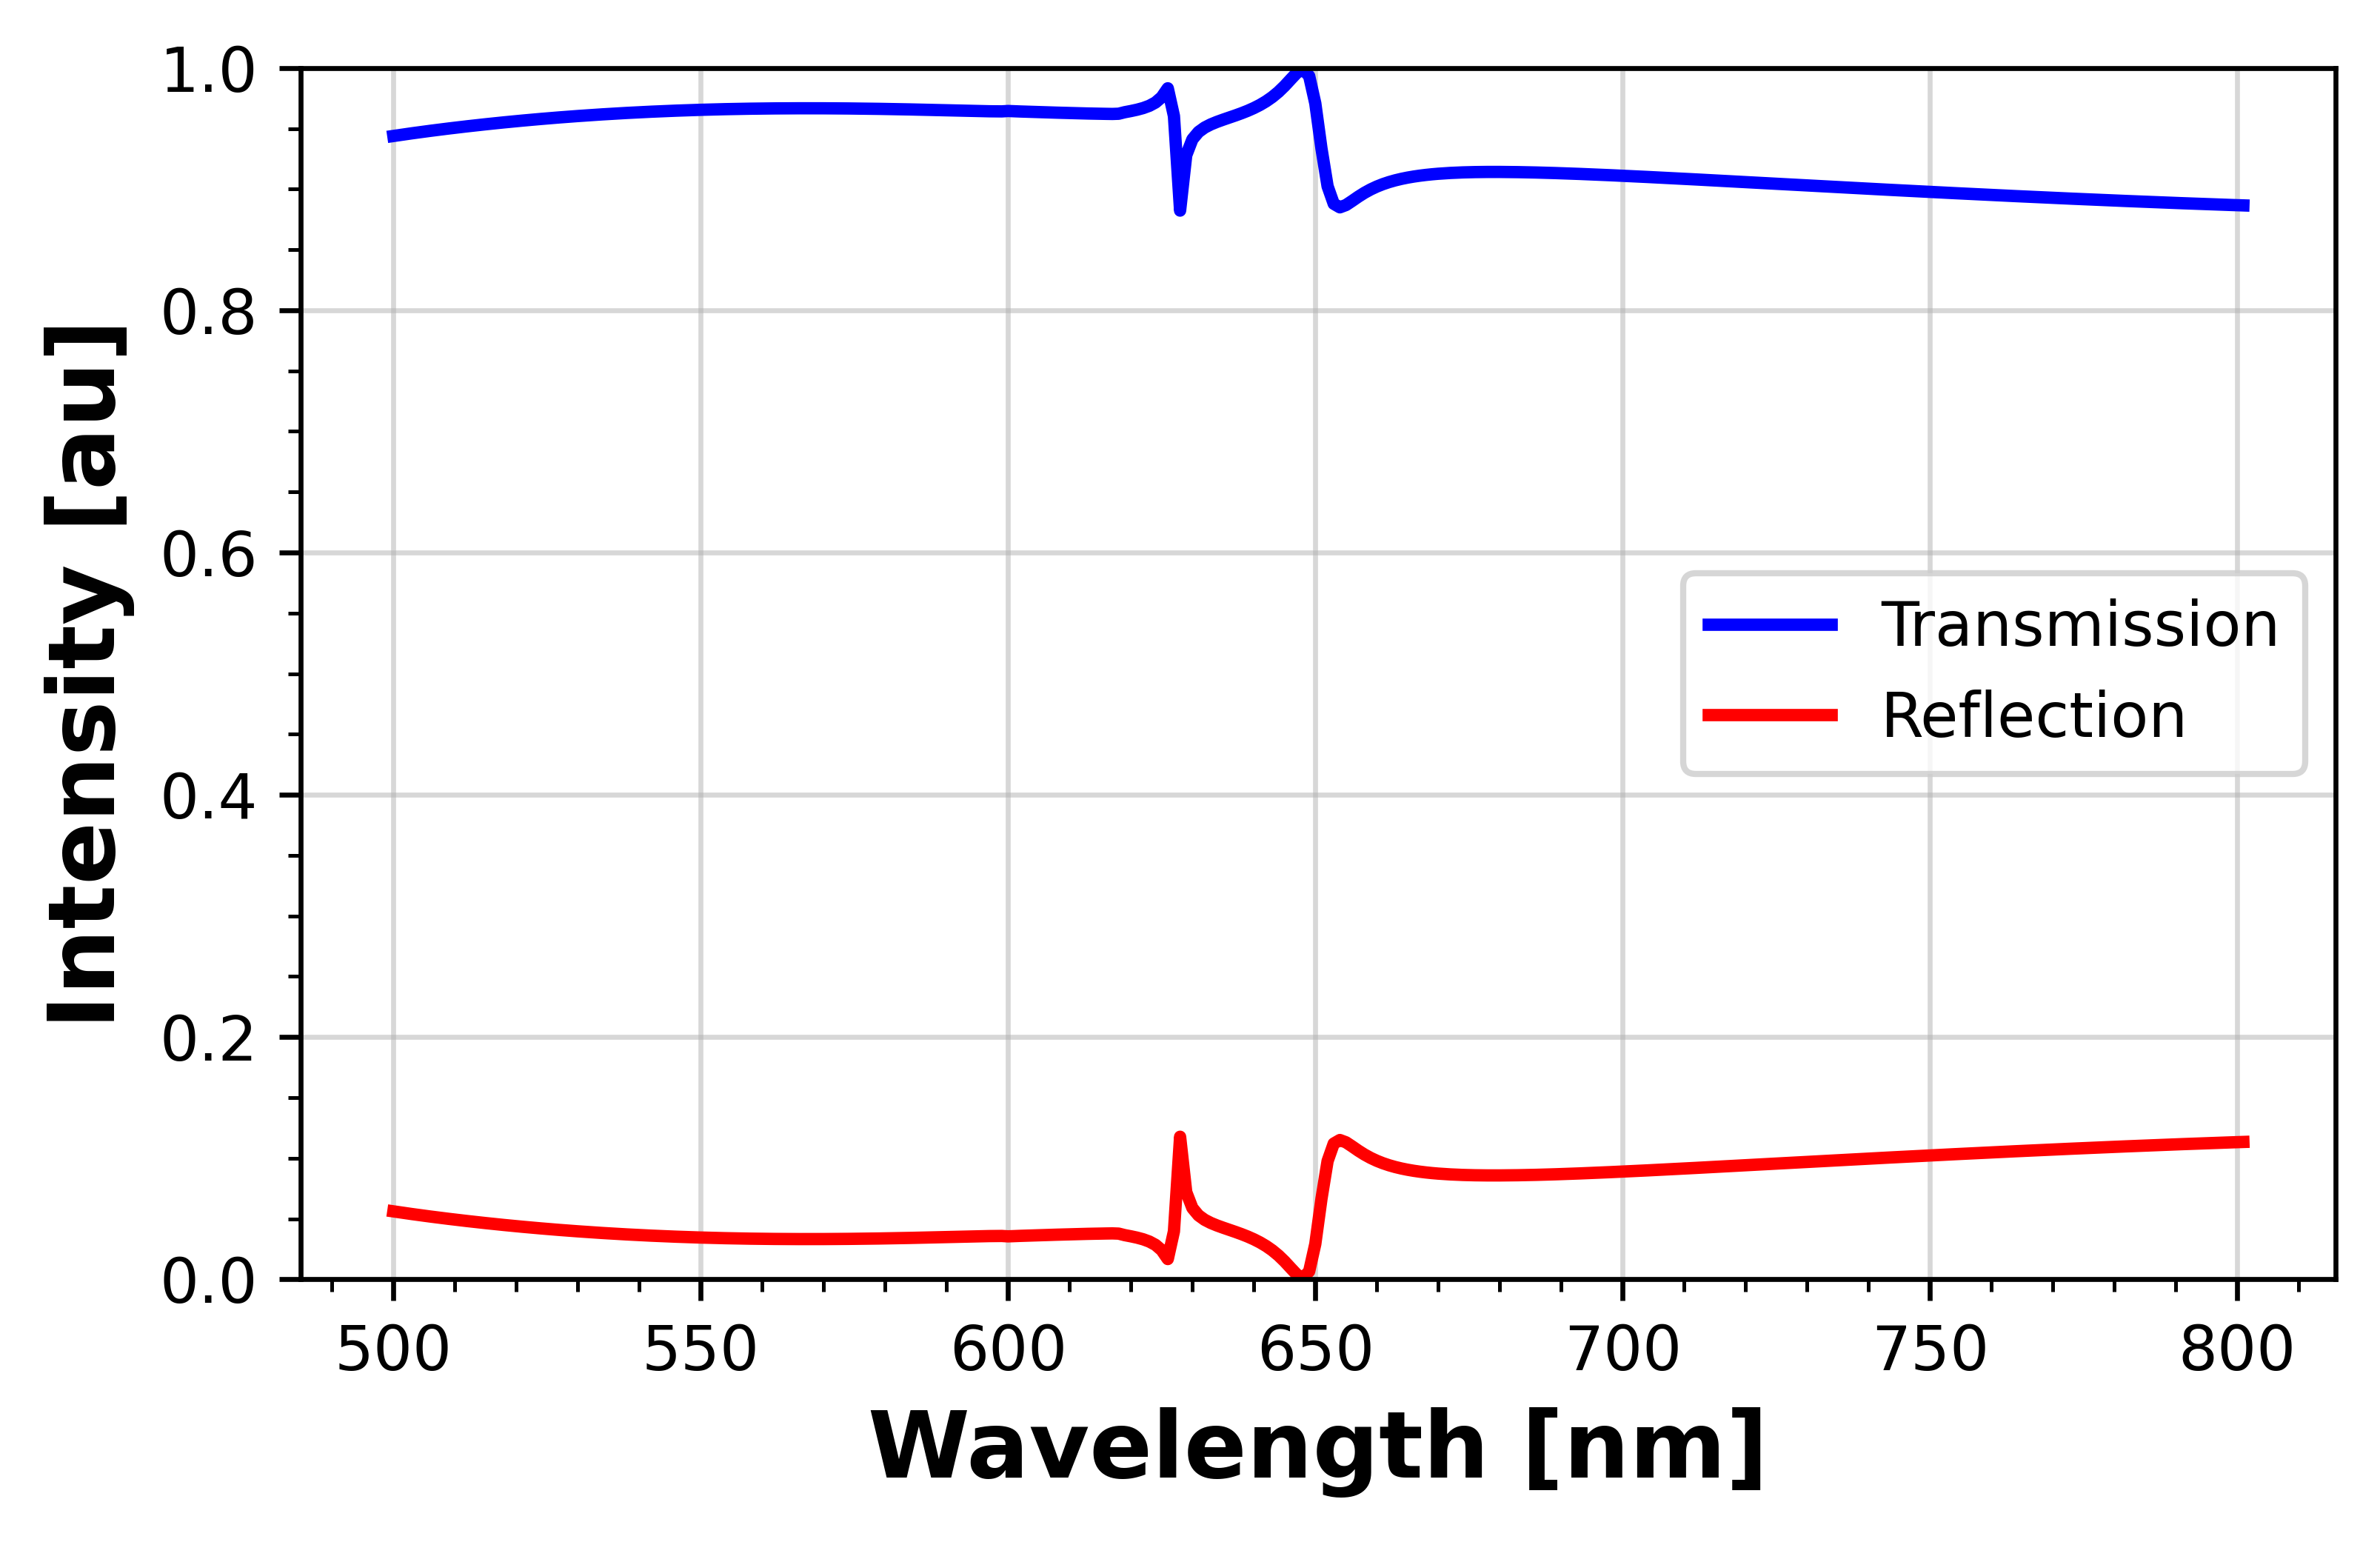

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_650.png


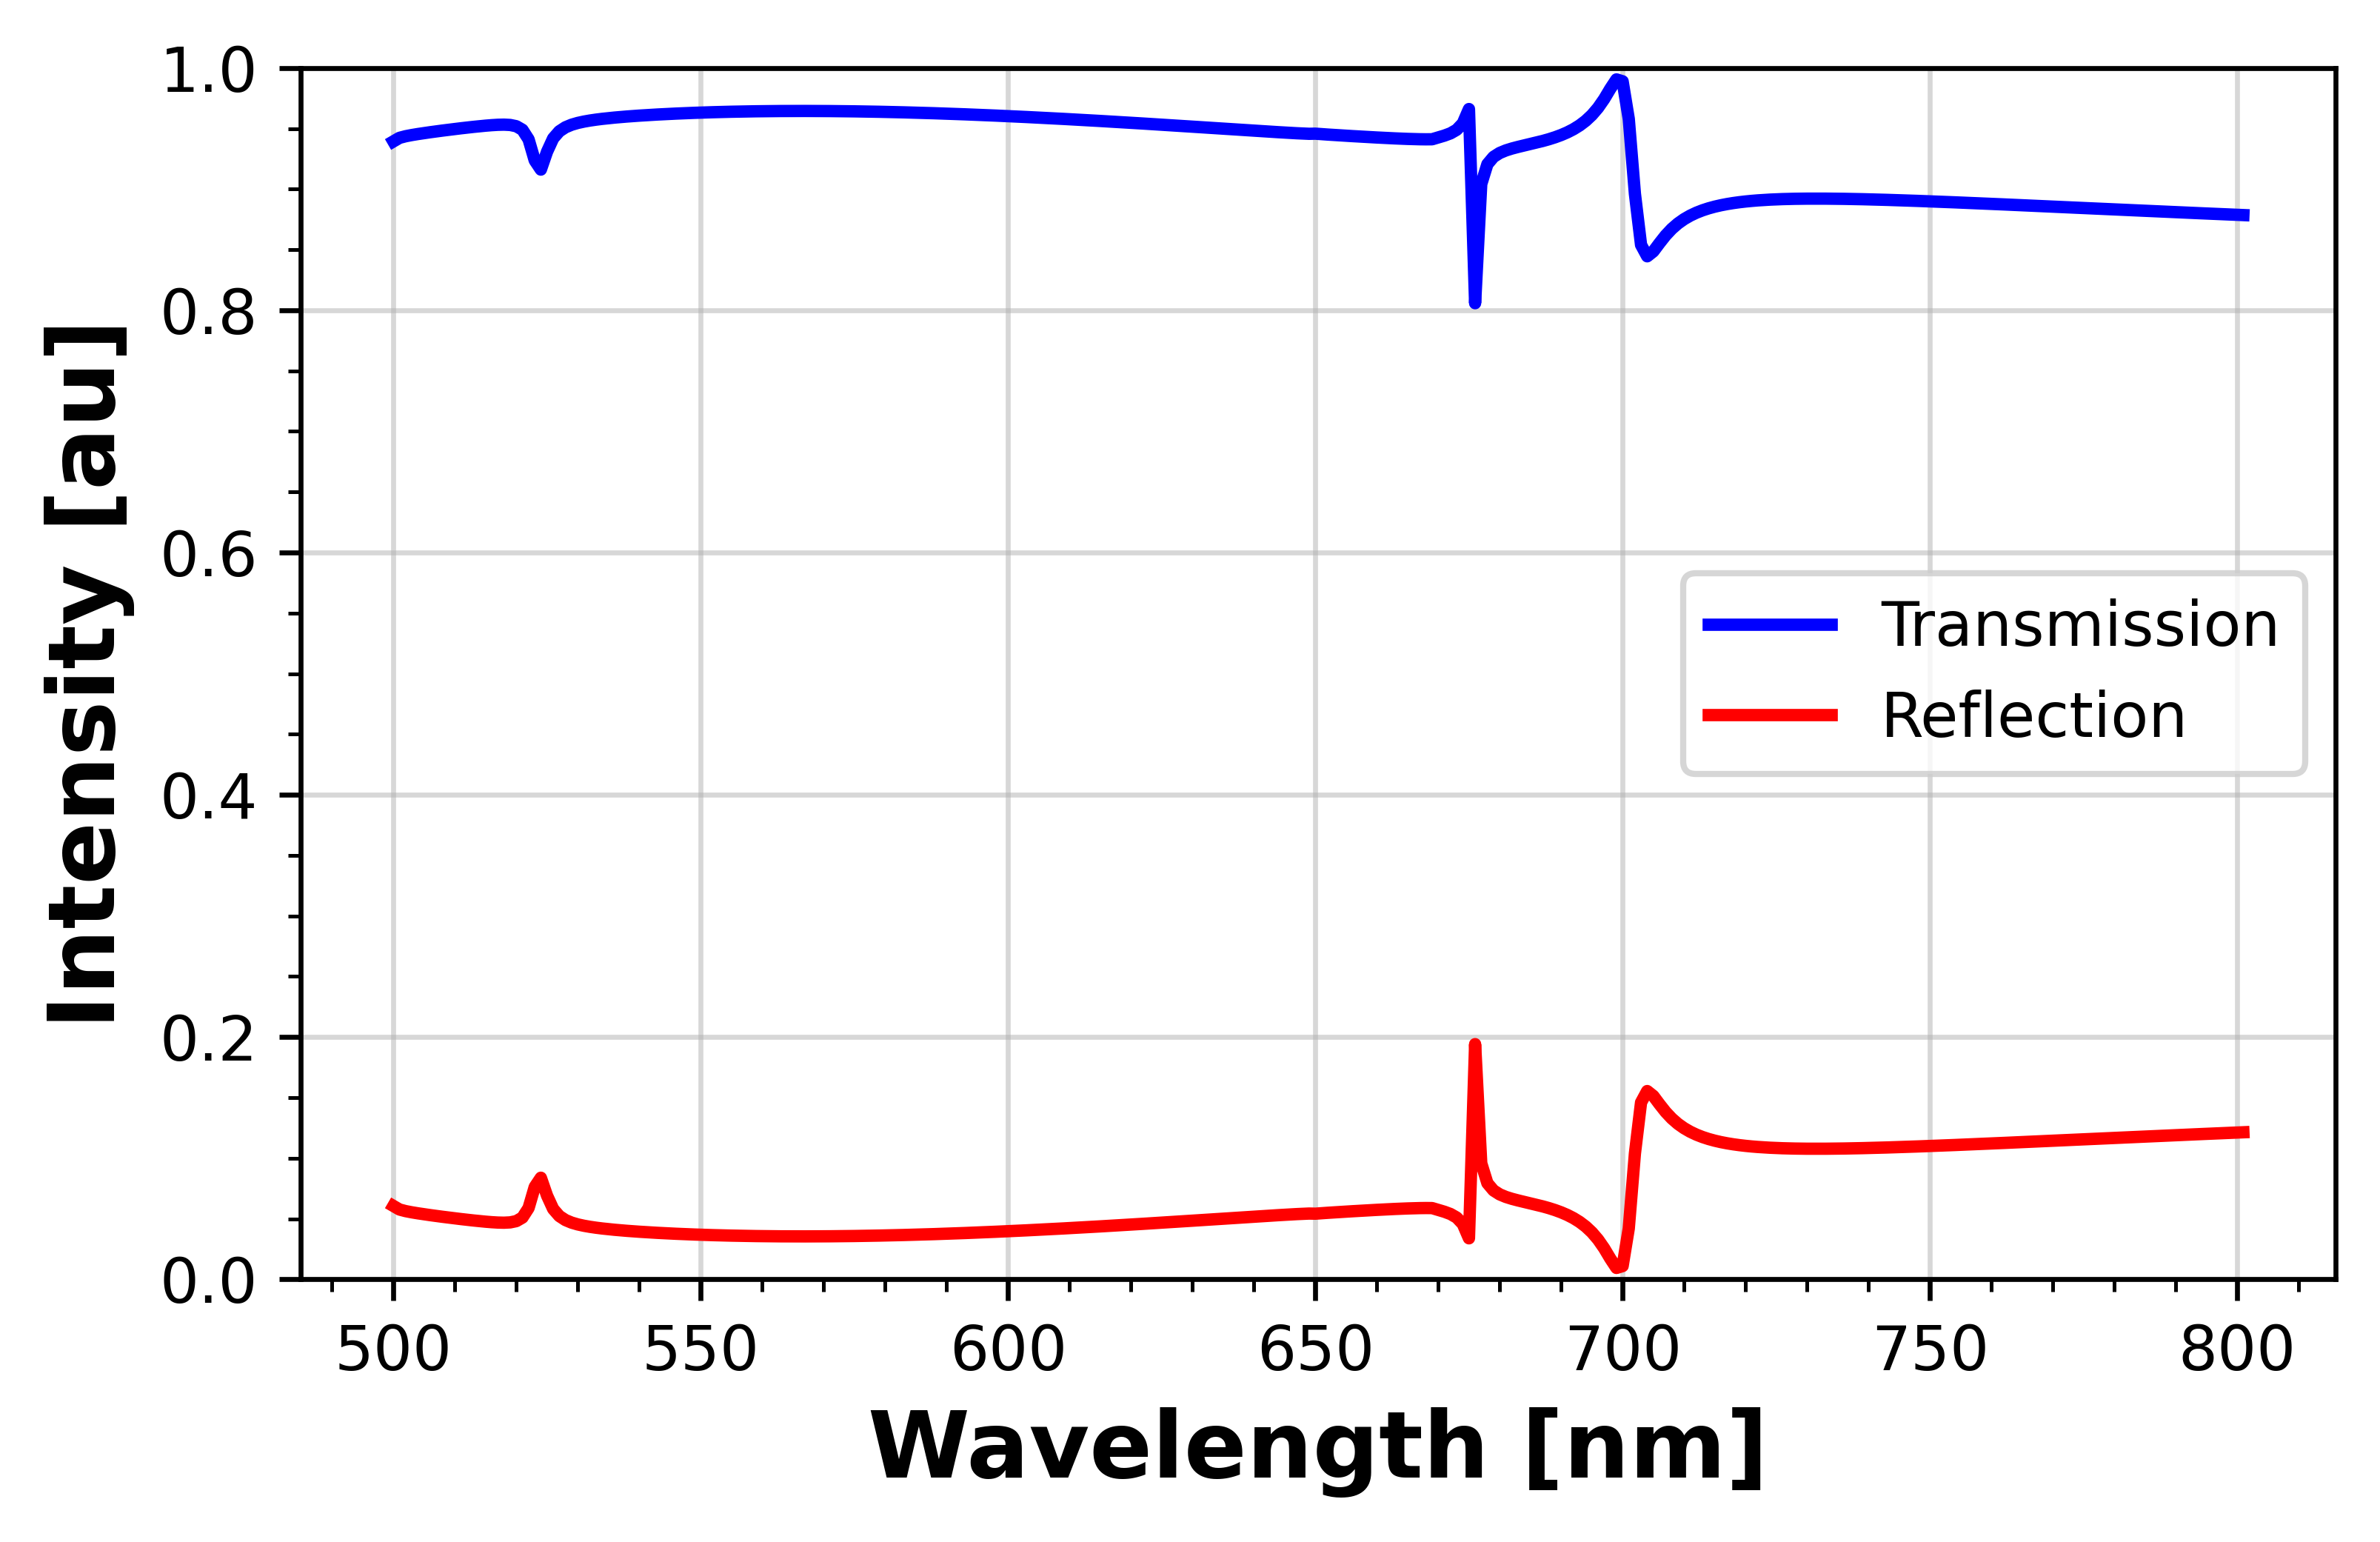

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Period\Period_Sweep_700.png


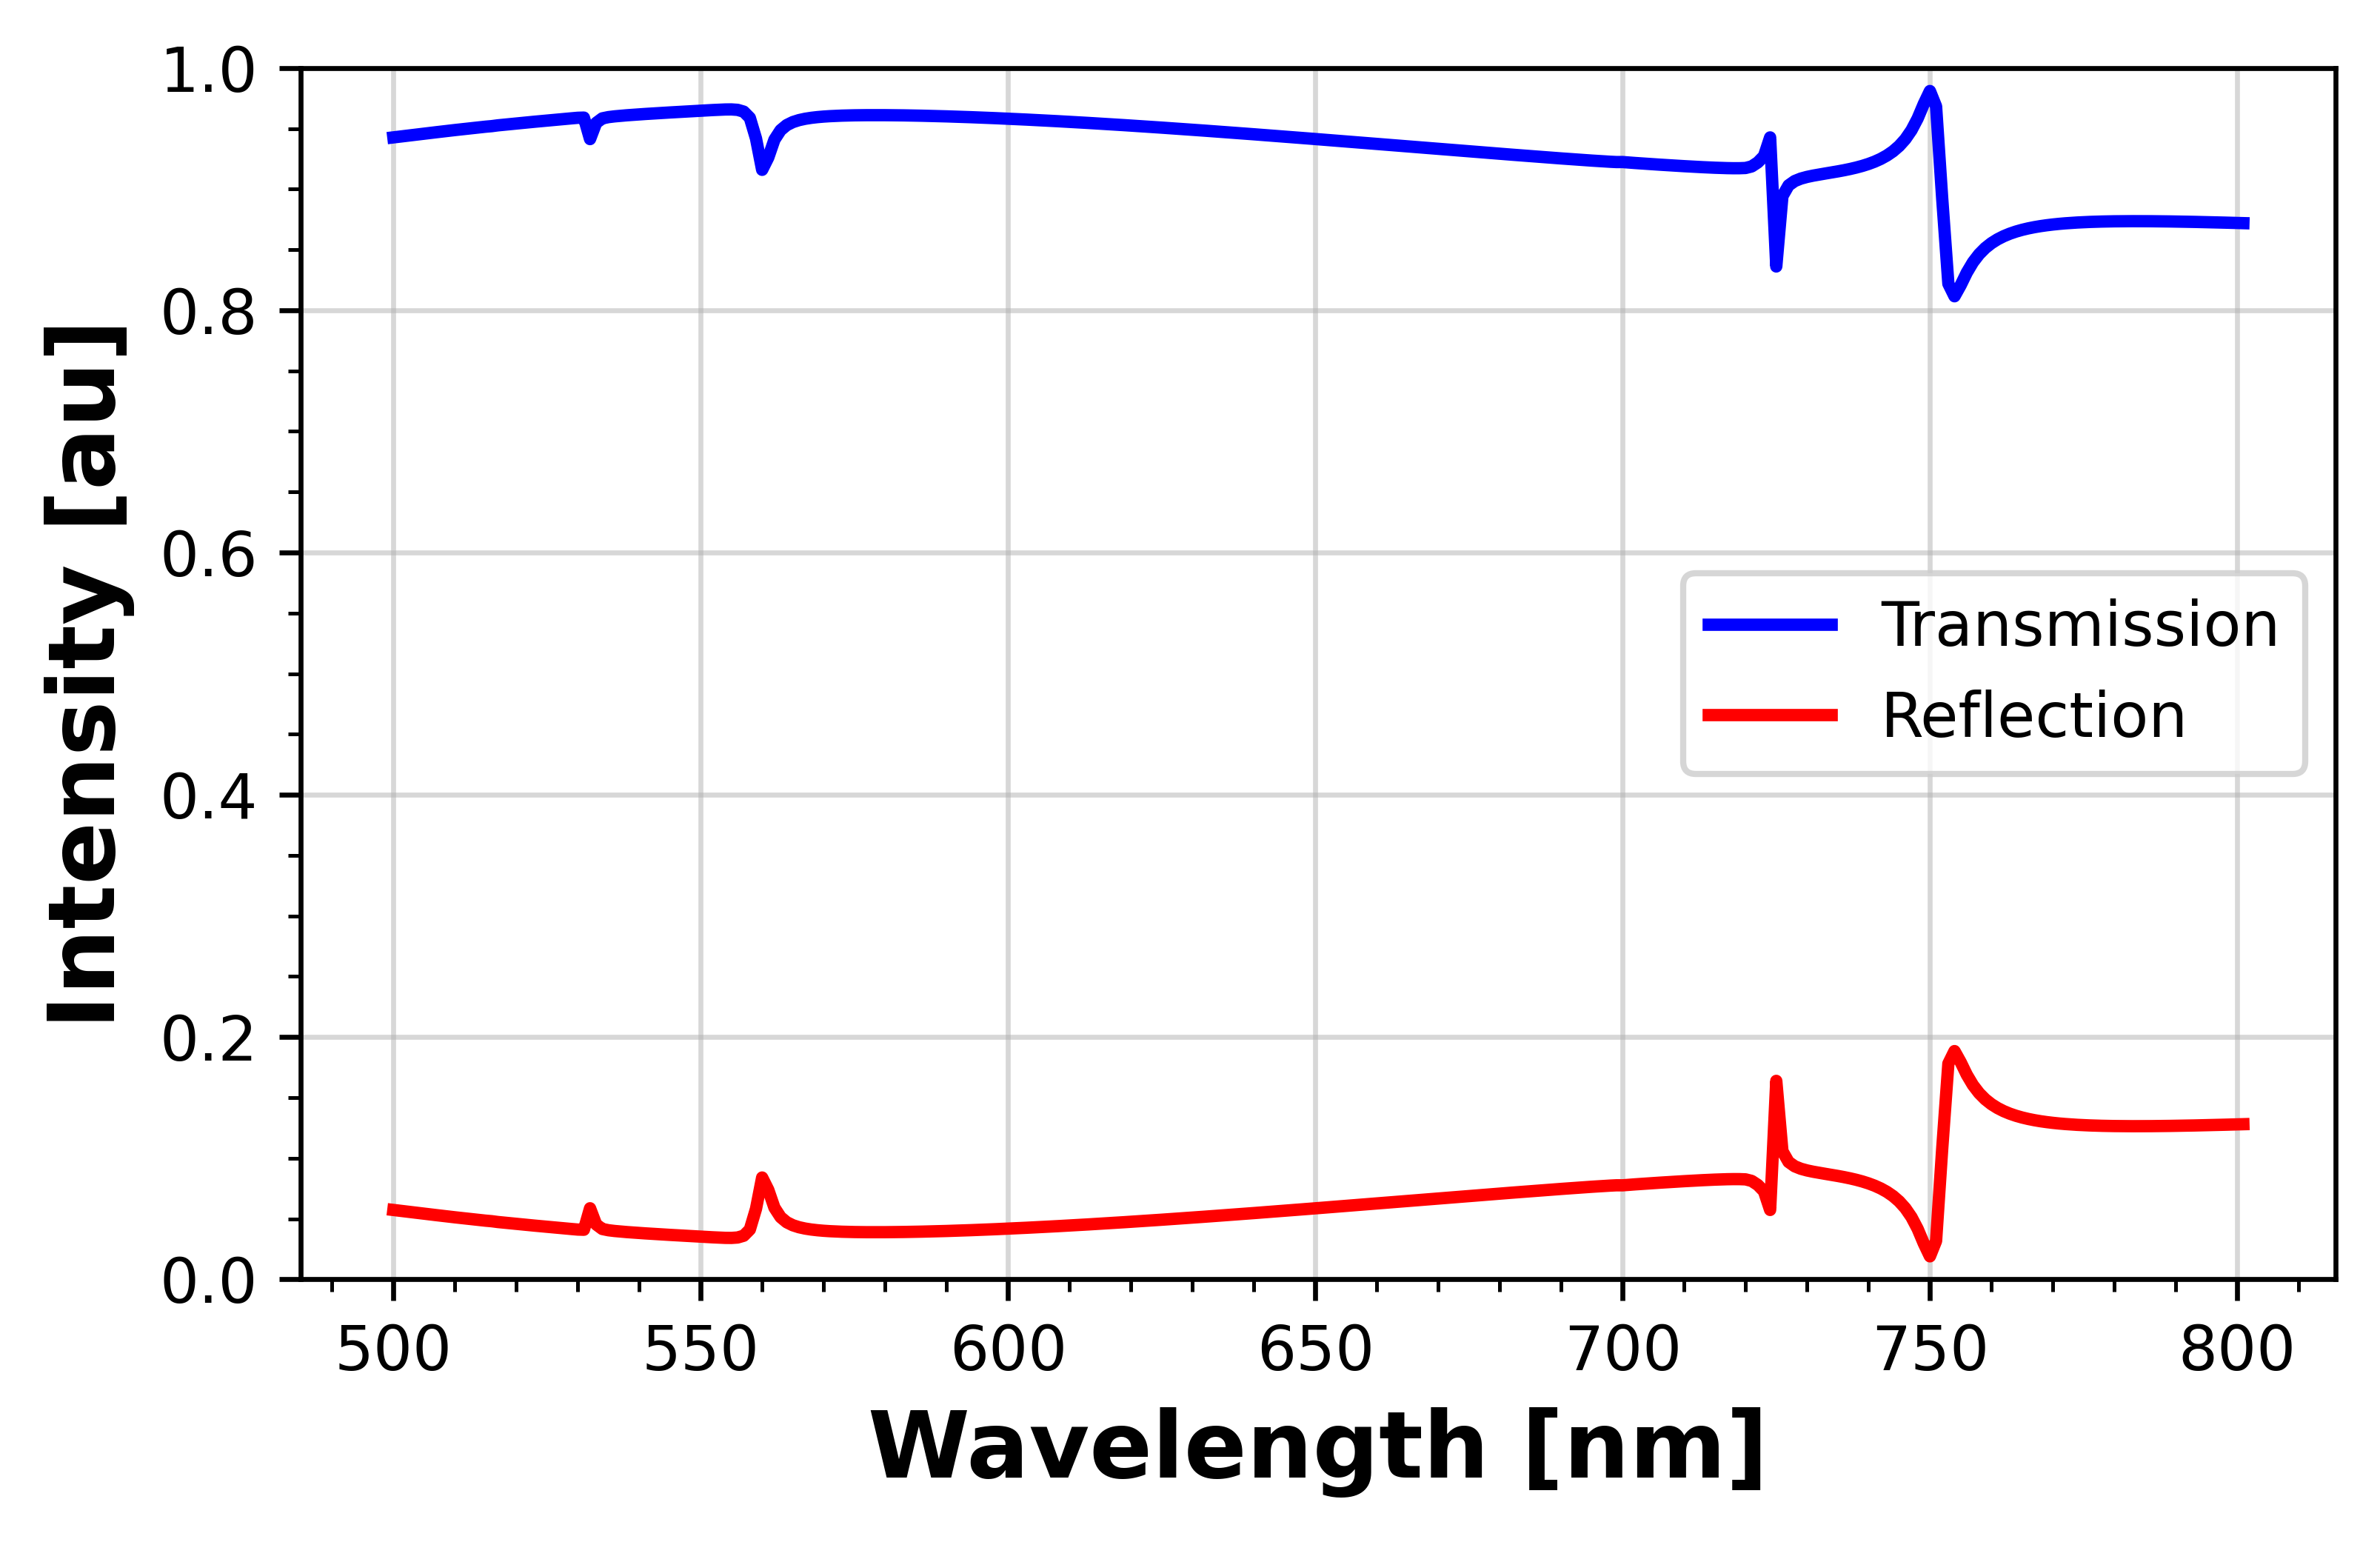

In [504]:
figure_path = Path(f'{root}/../S4/Results/Nanohole_Period')
figures = os.listdir(figure_path)
for figure in figures:
    file_path = Path(f'{figure_path}/{figure}')
    print(file_path)
    display(
        Image(
            filename=file_path,
            width=900,
            height=530
        )
    )

* And the following results for varying the nanohole radius.

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_100.png


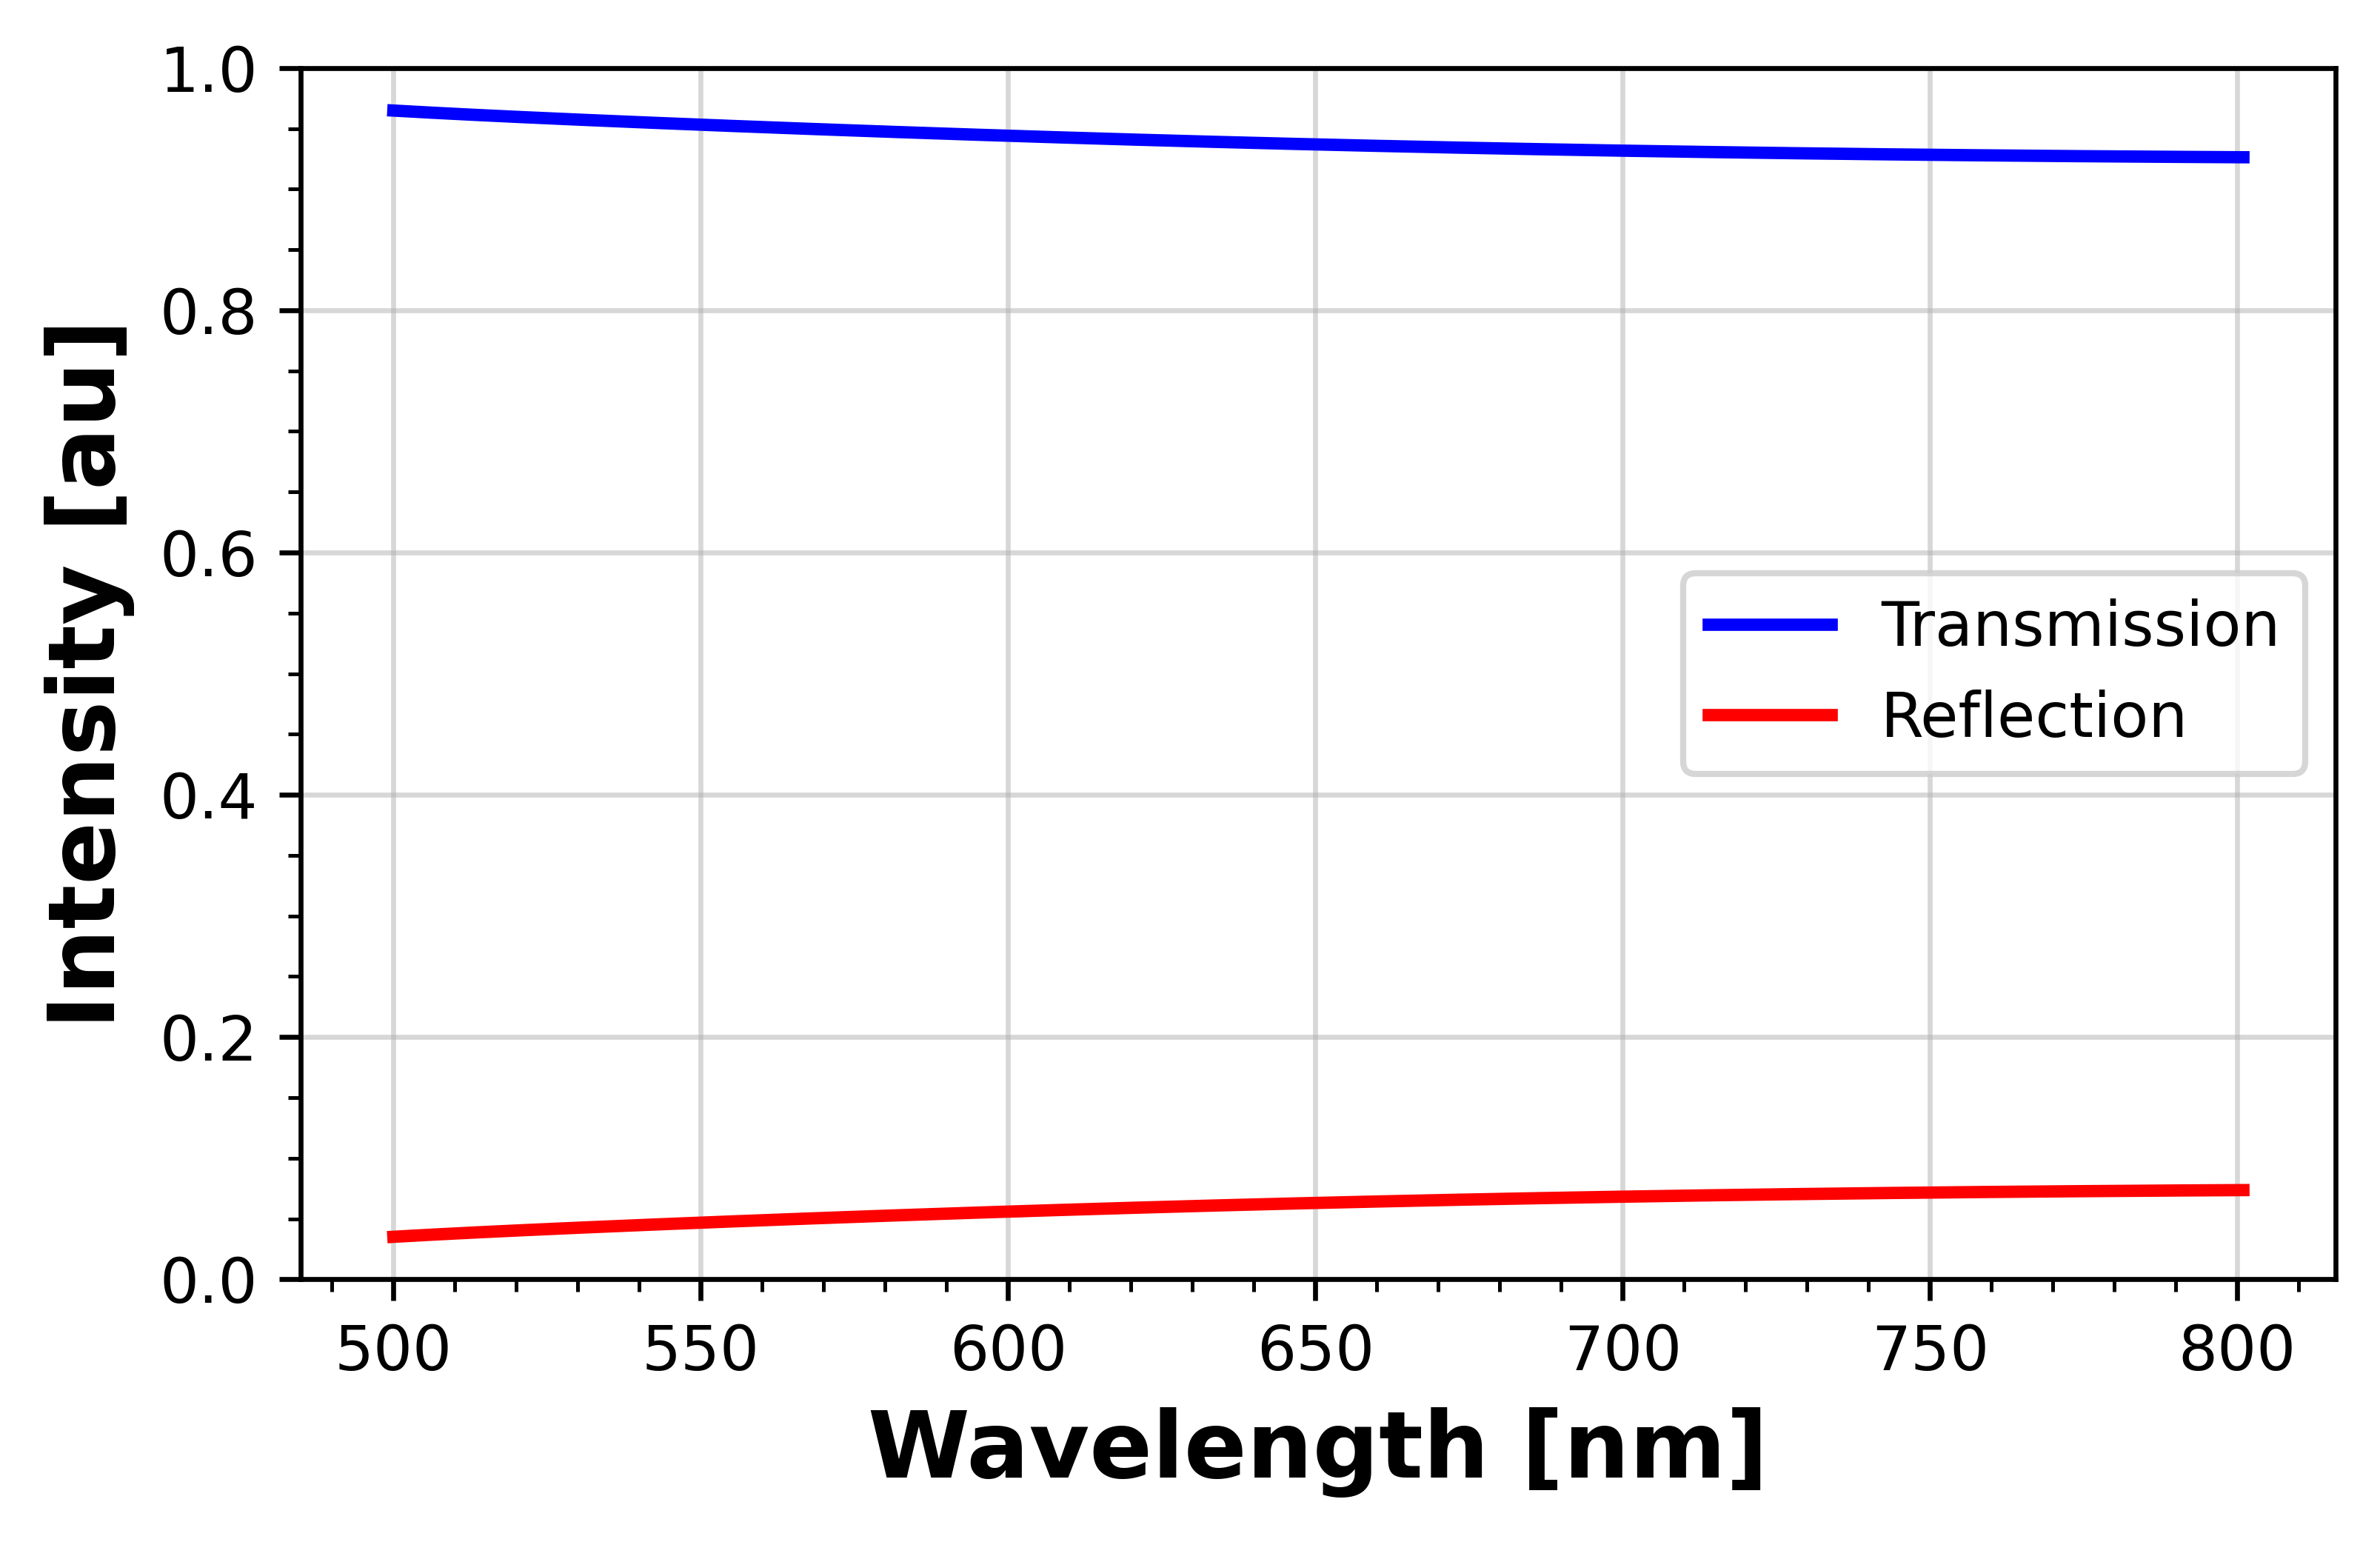

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_150.png


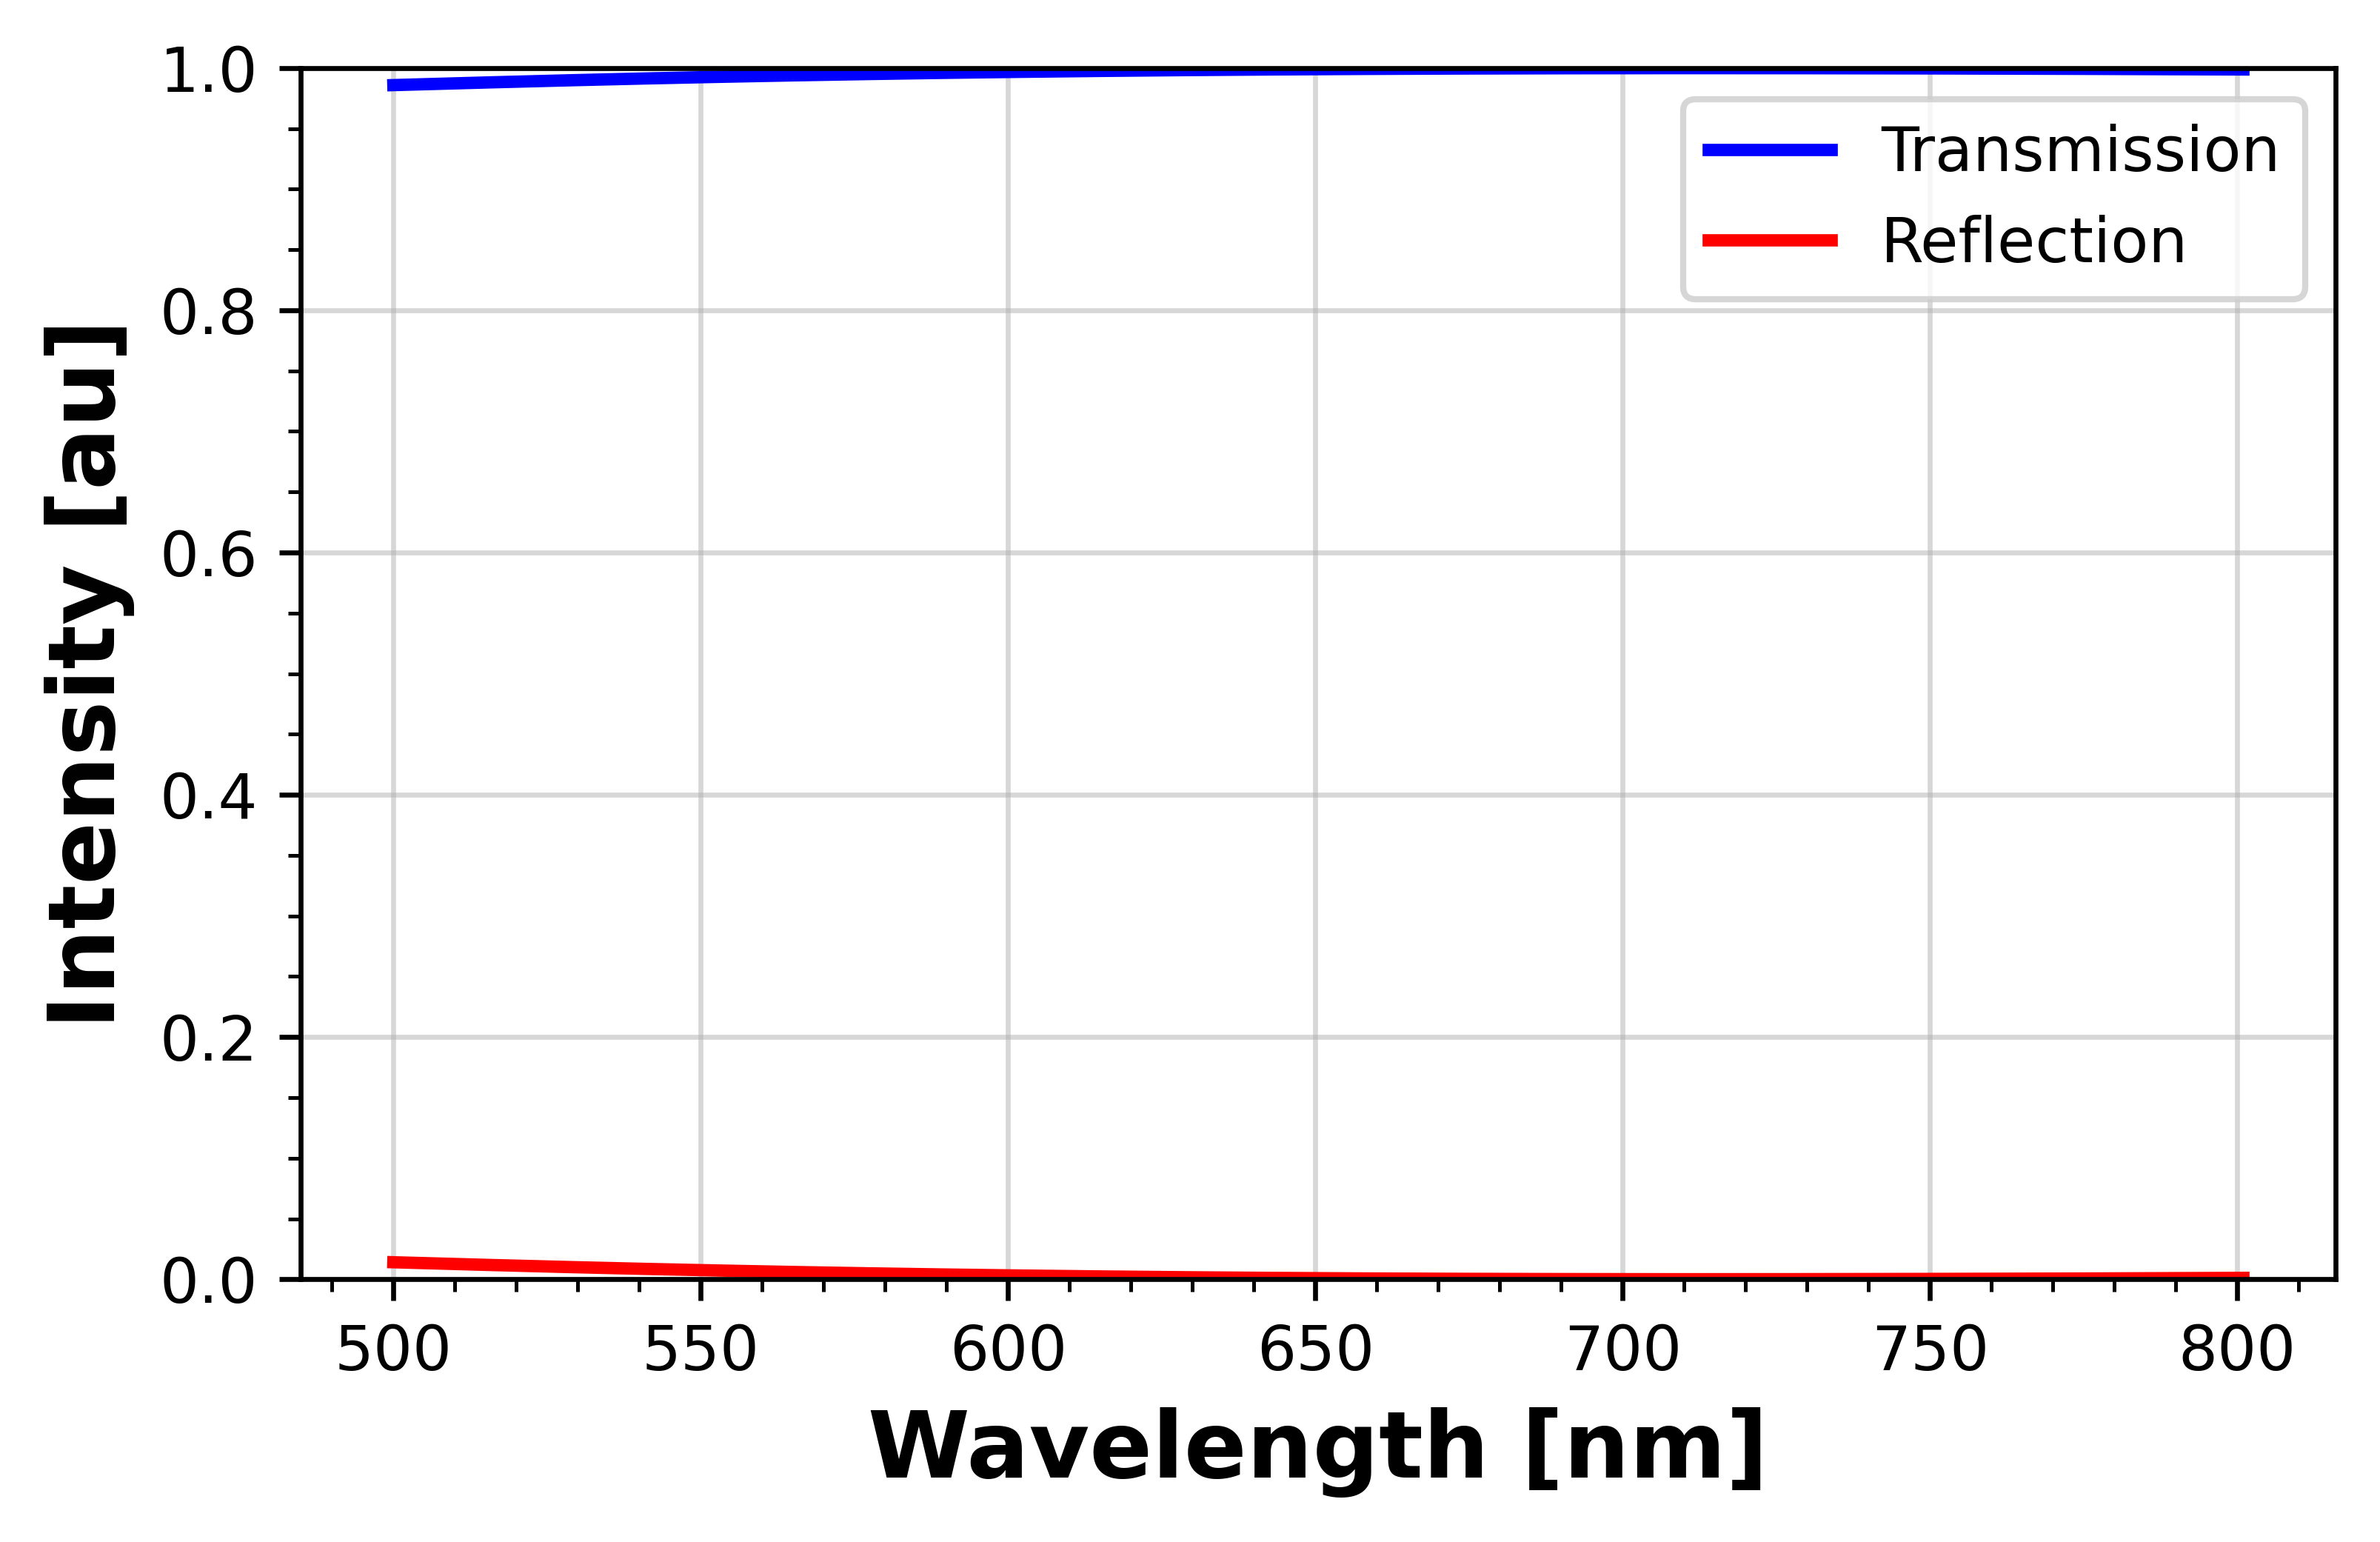

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_200.png


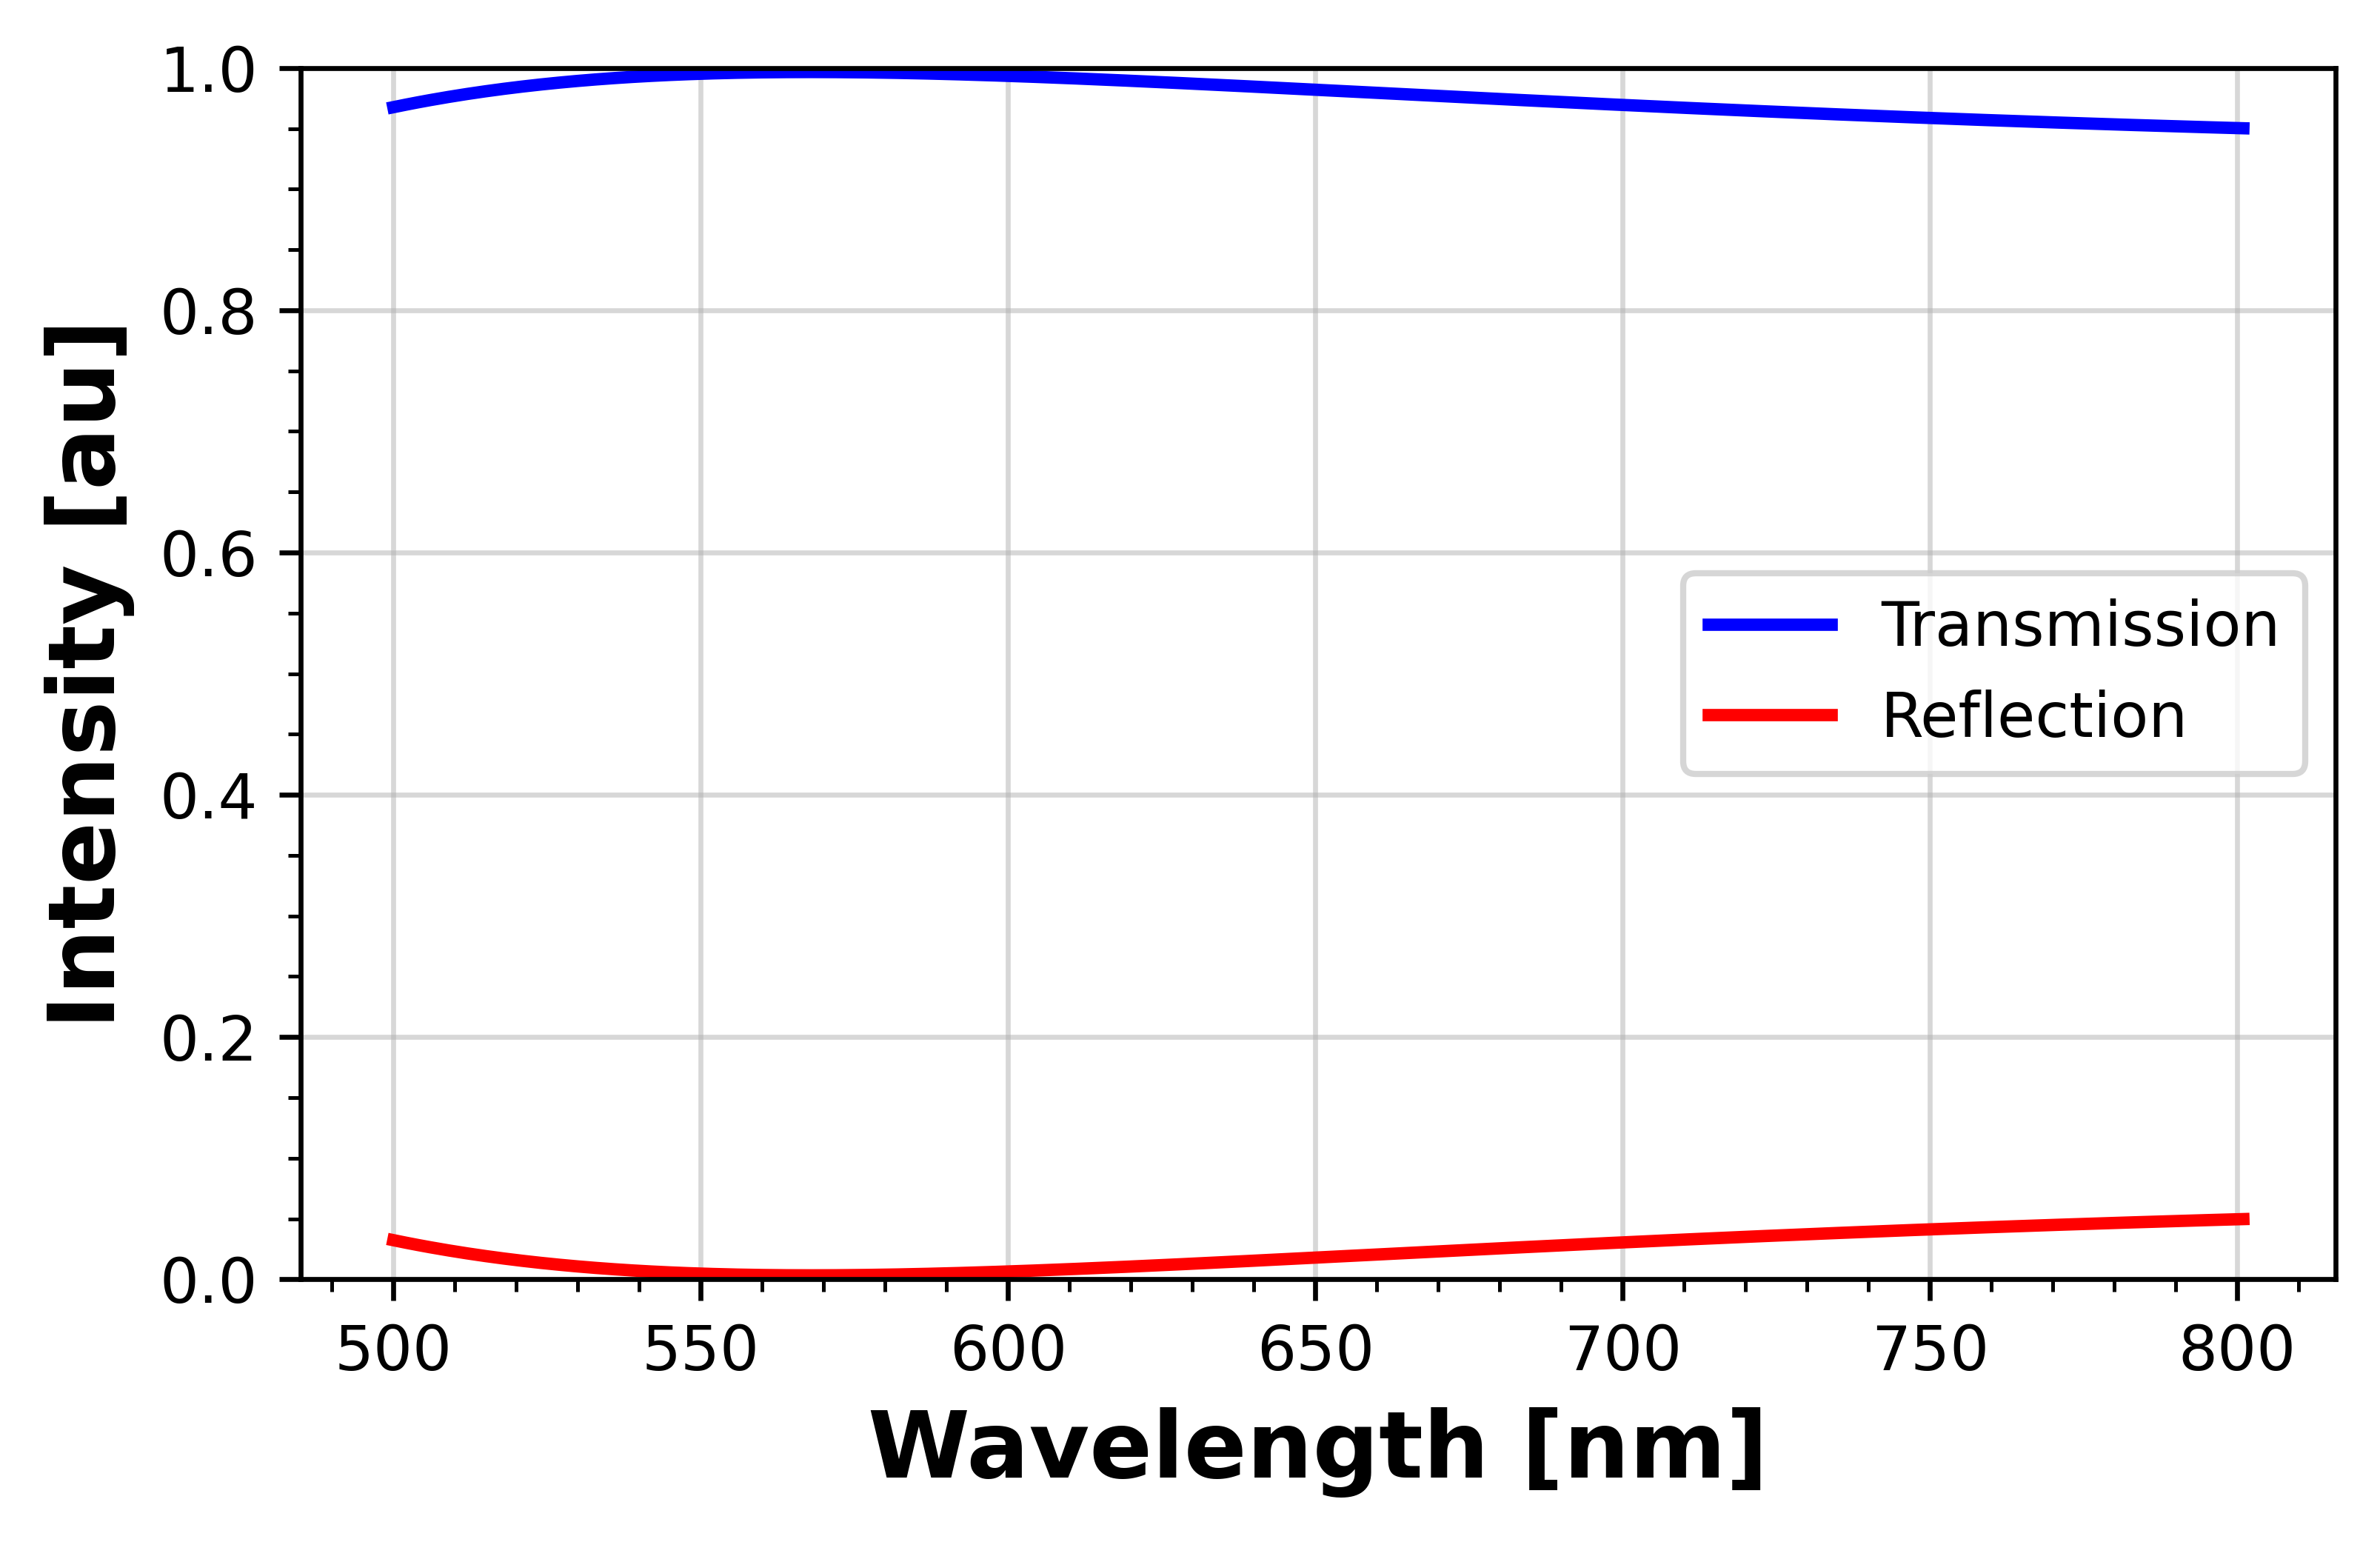

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_250.png


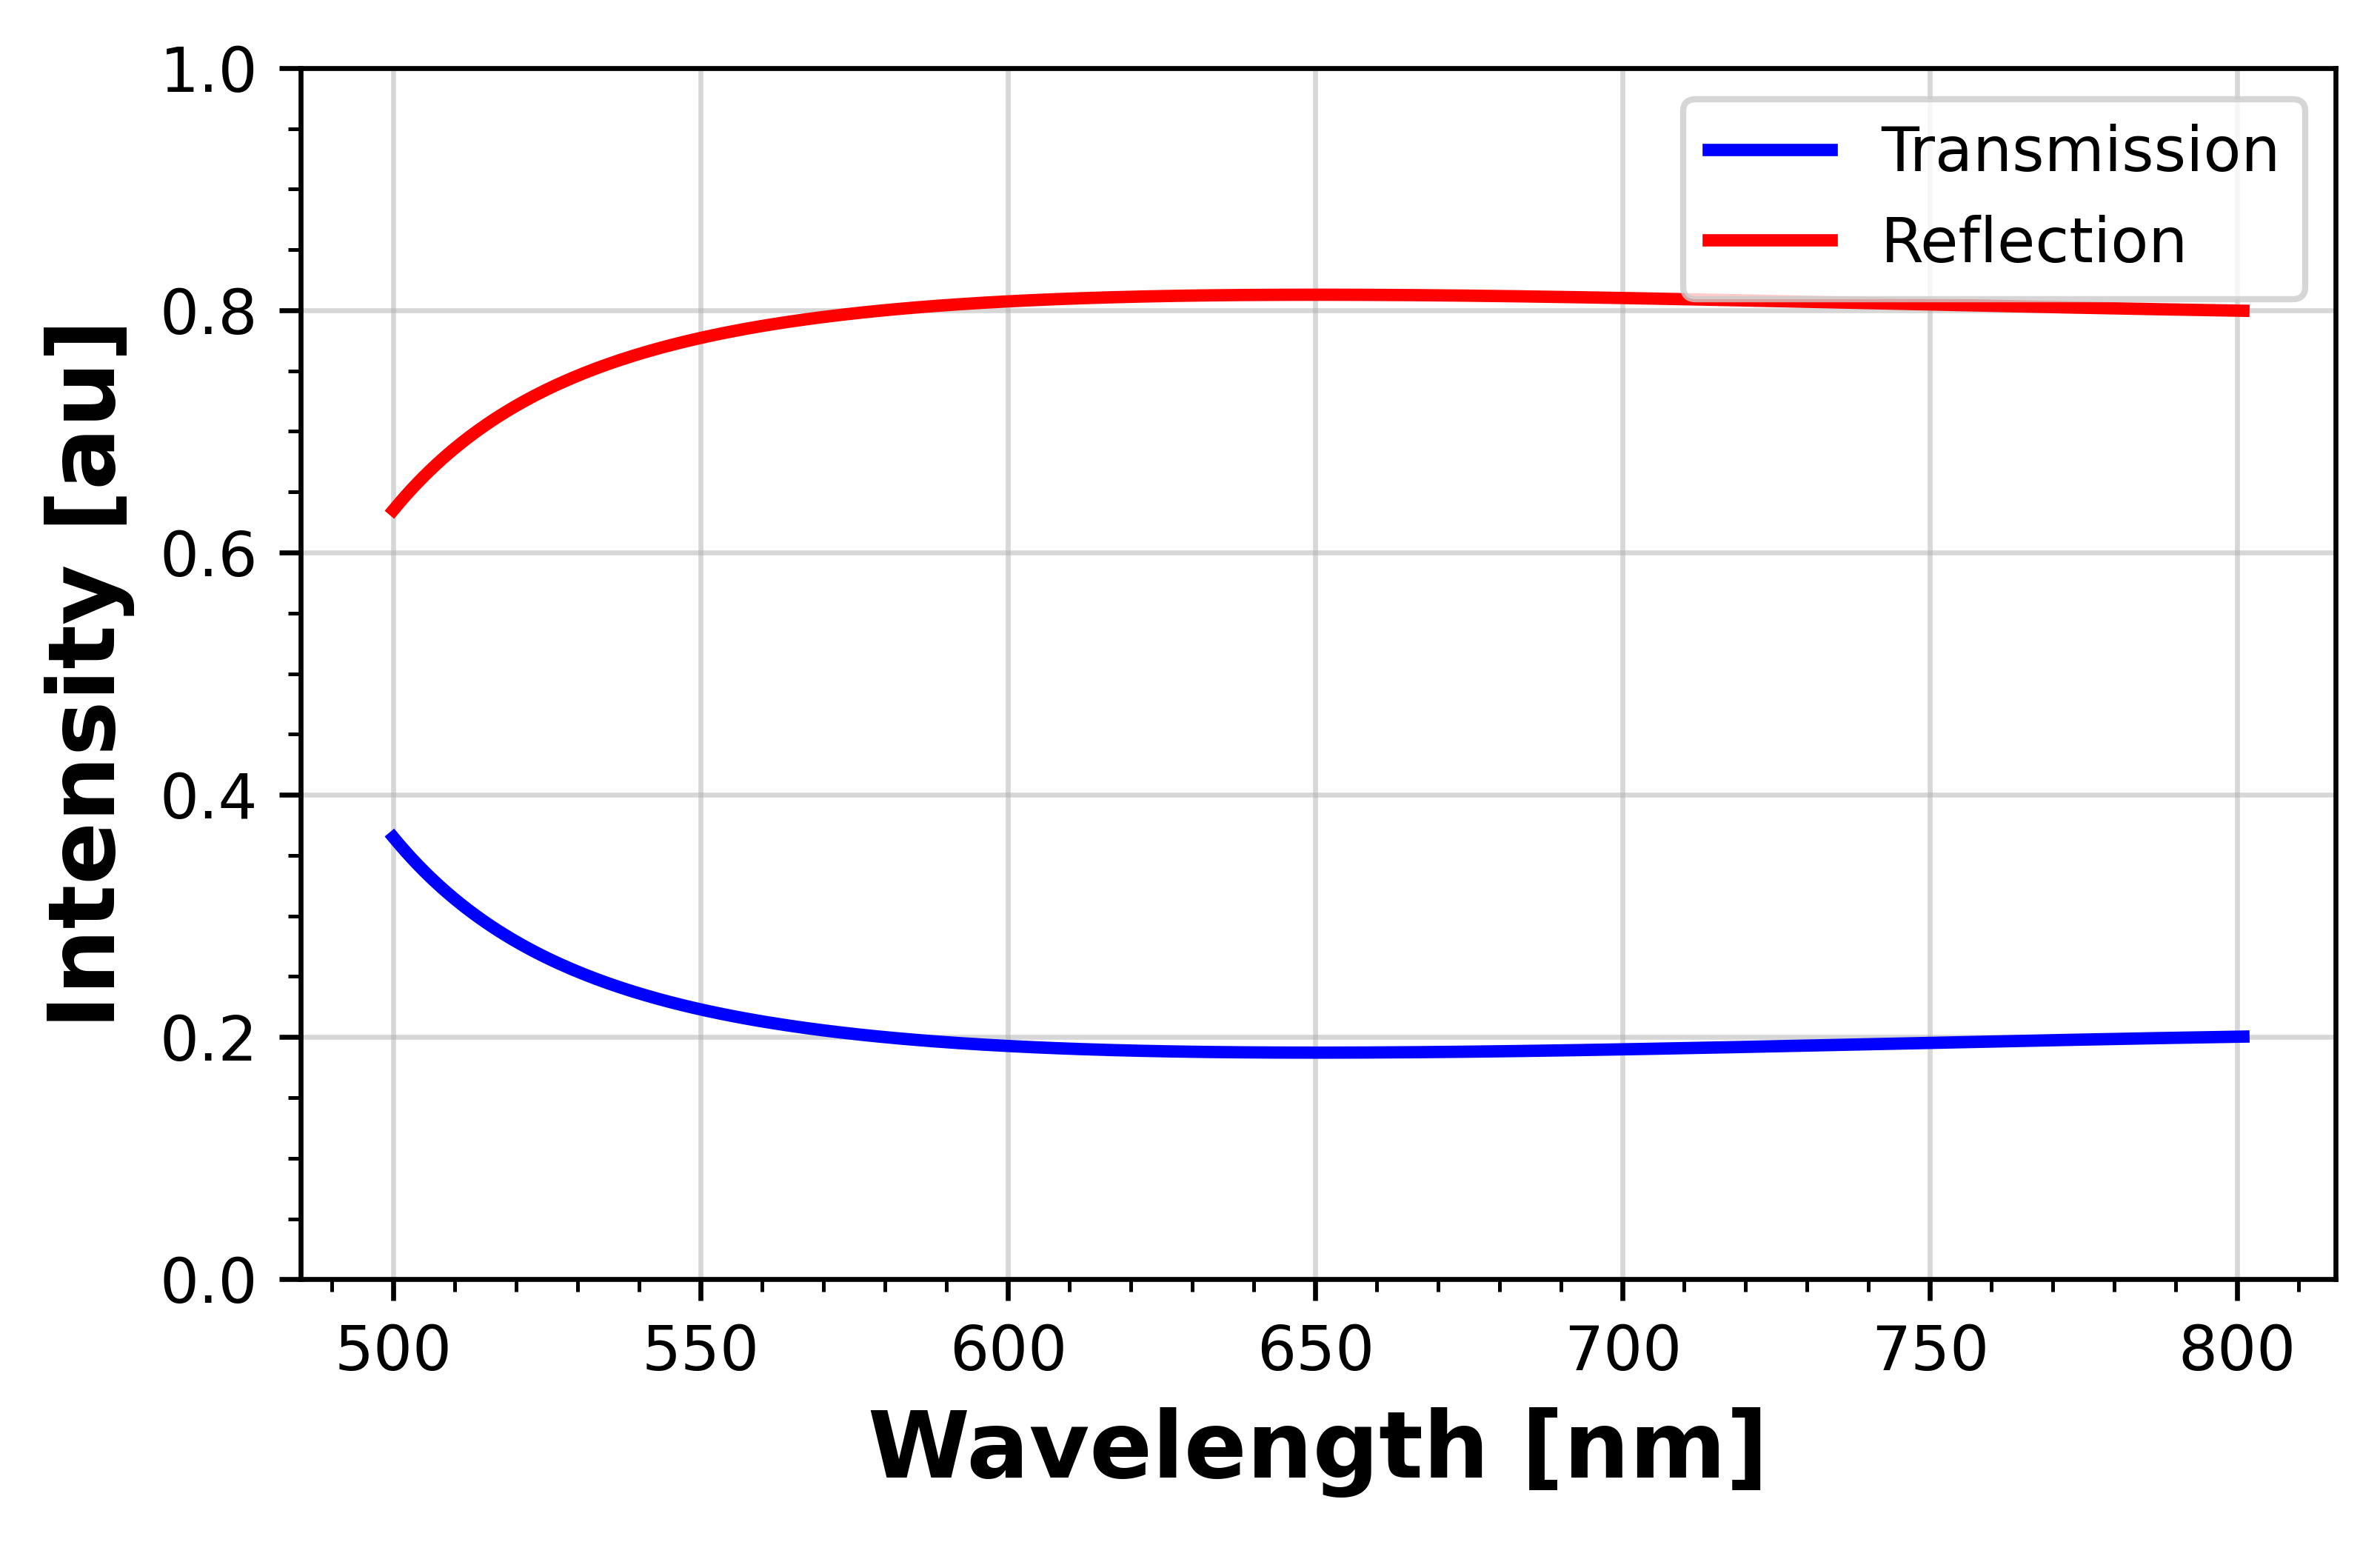

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_300.png


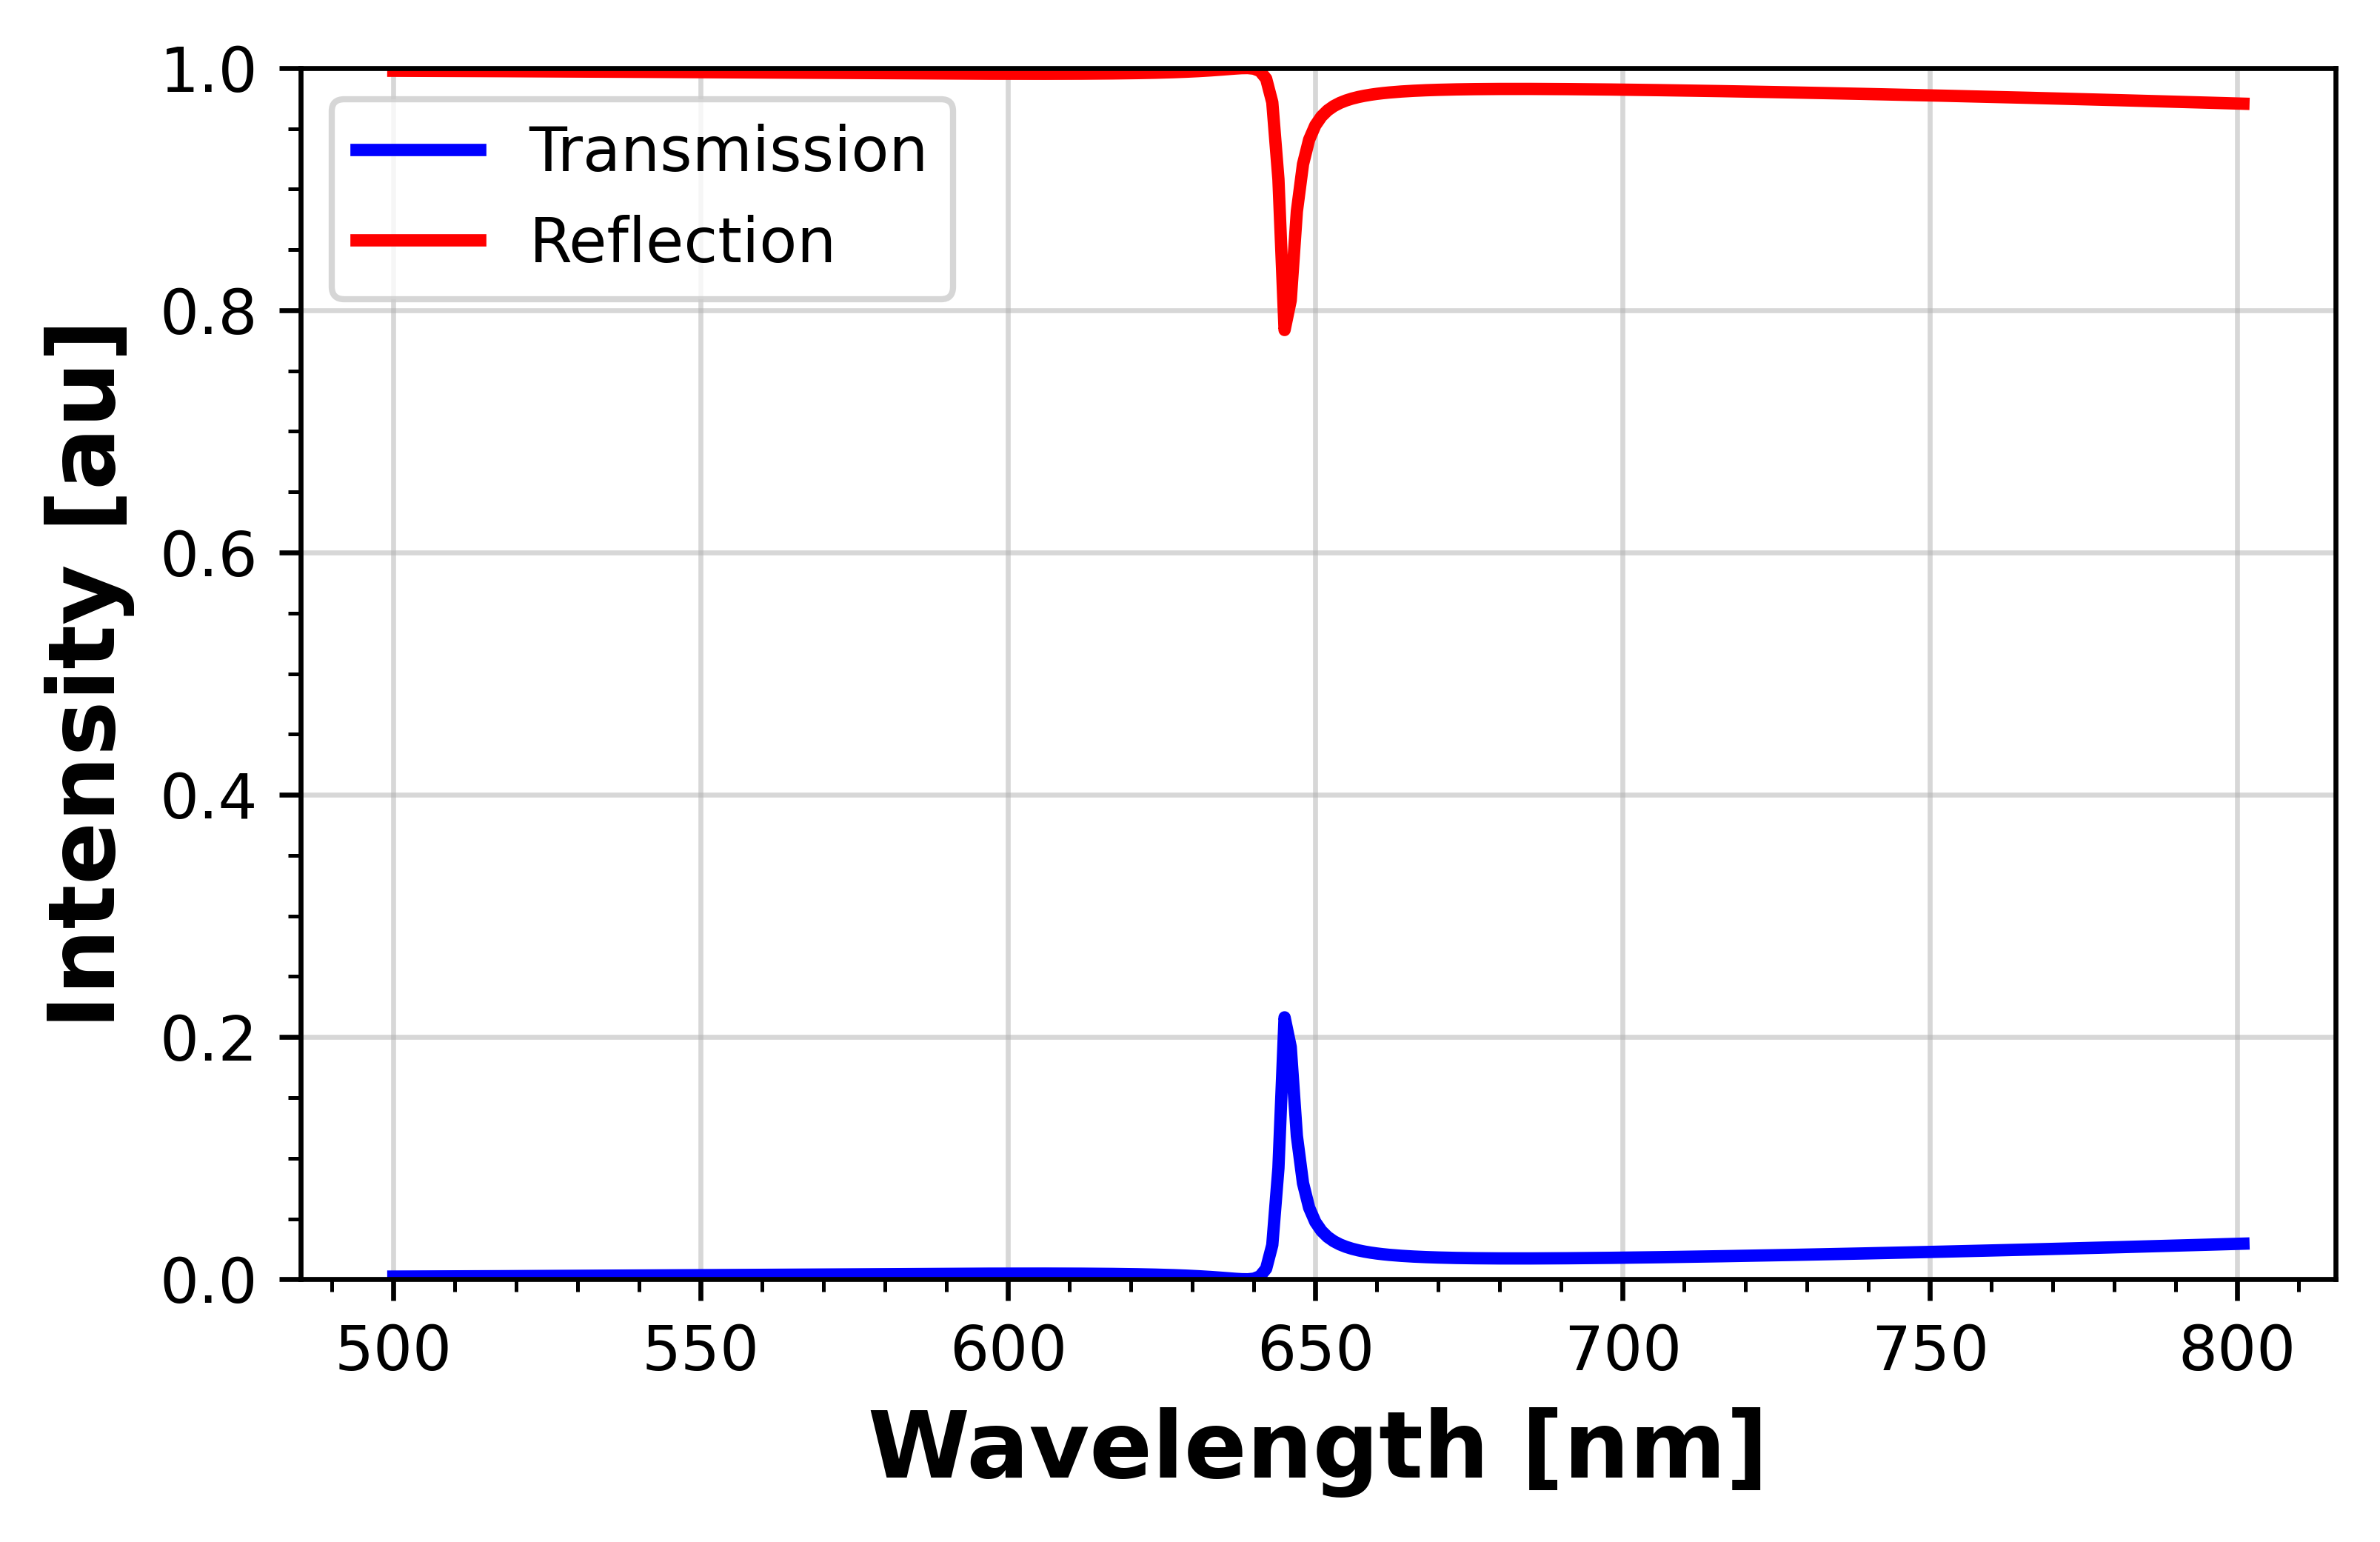

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_350.png


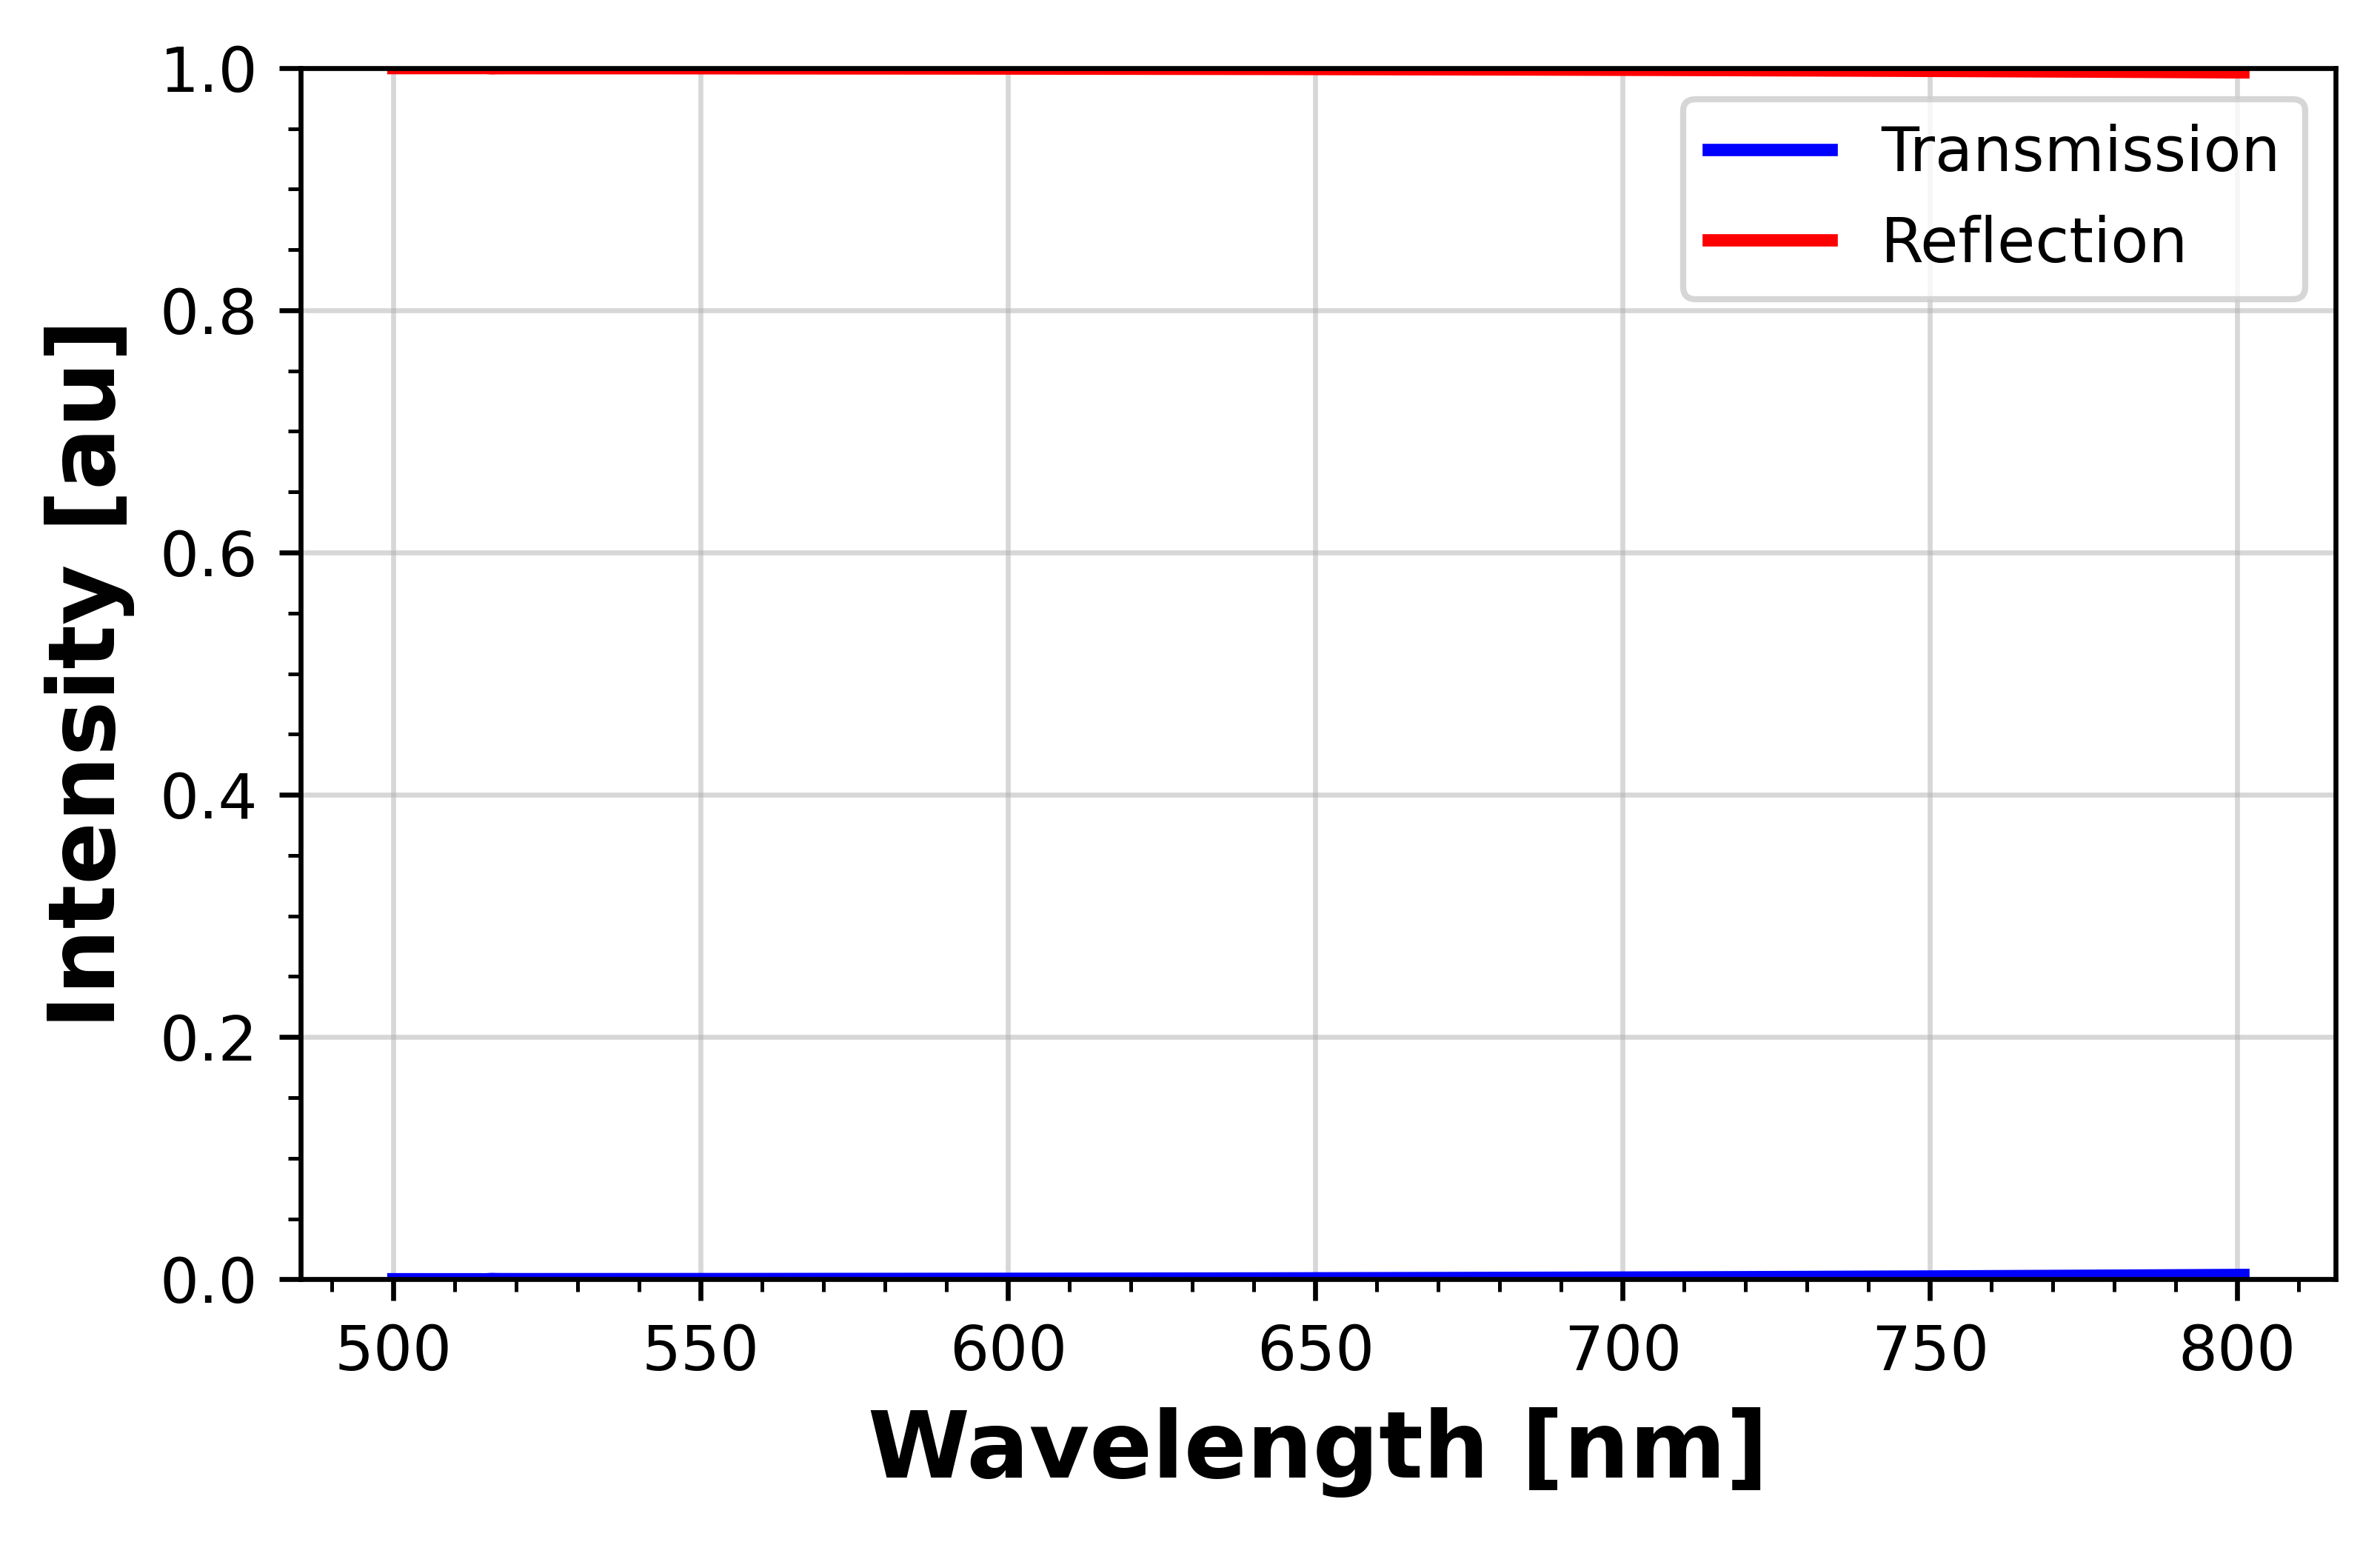

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_400.png


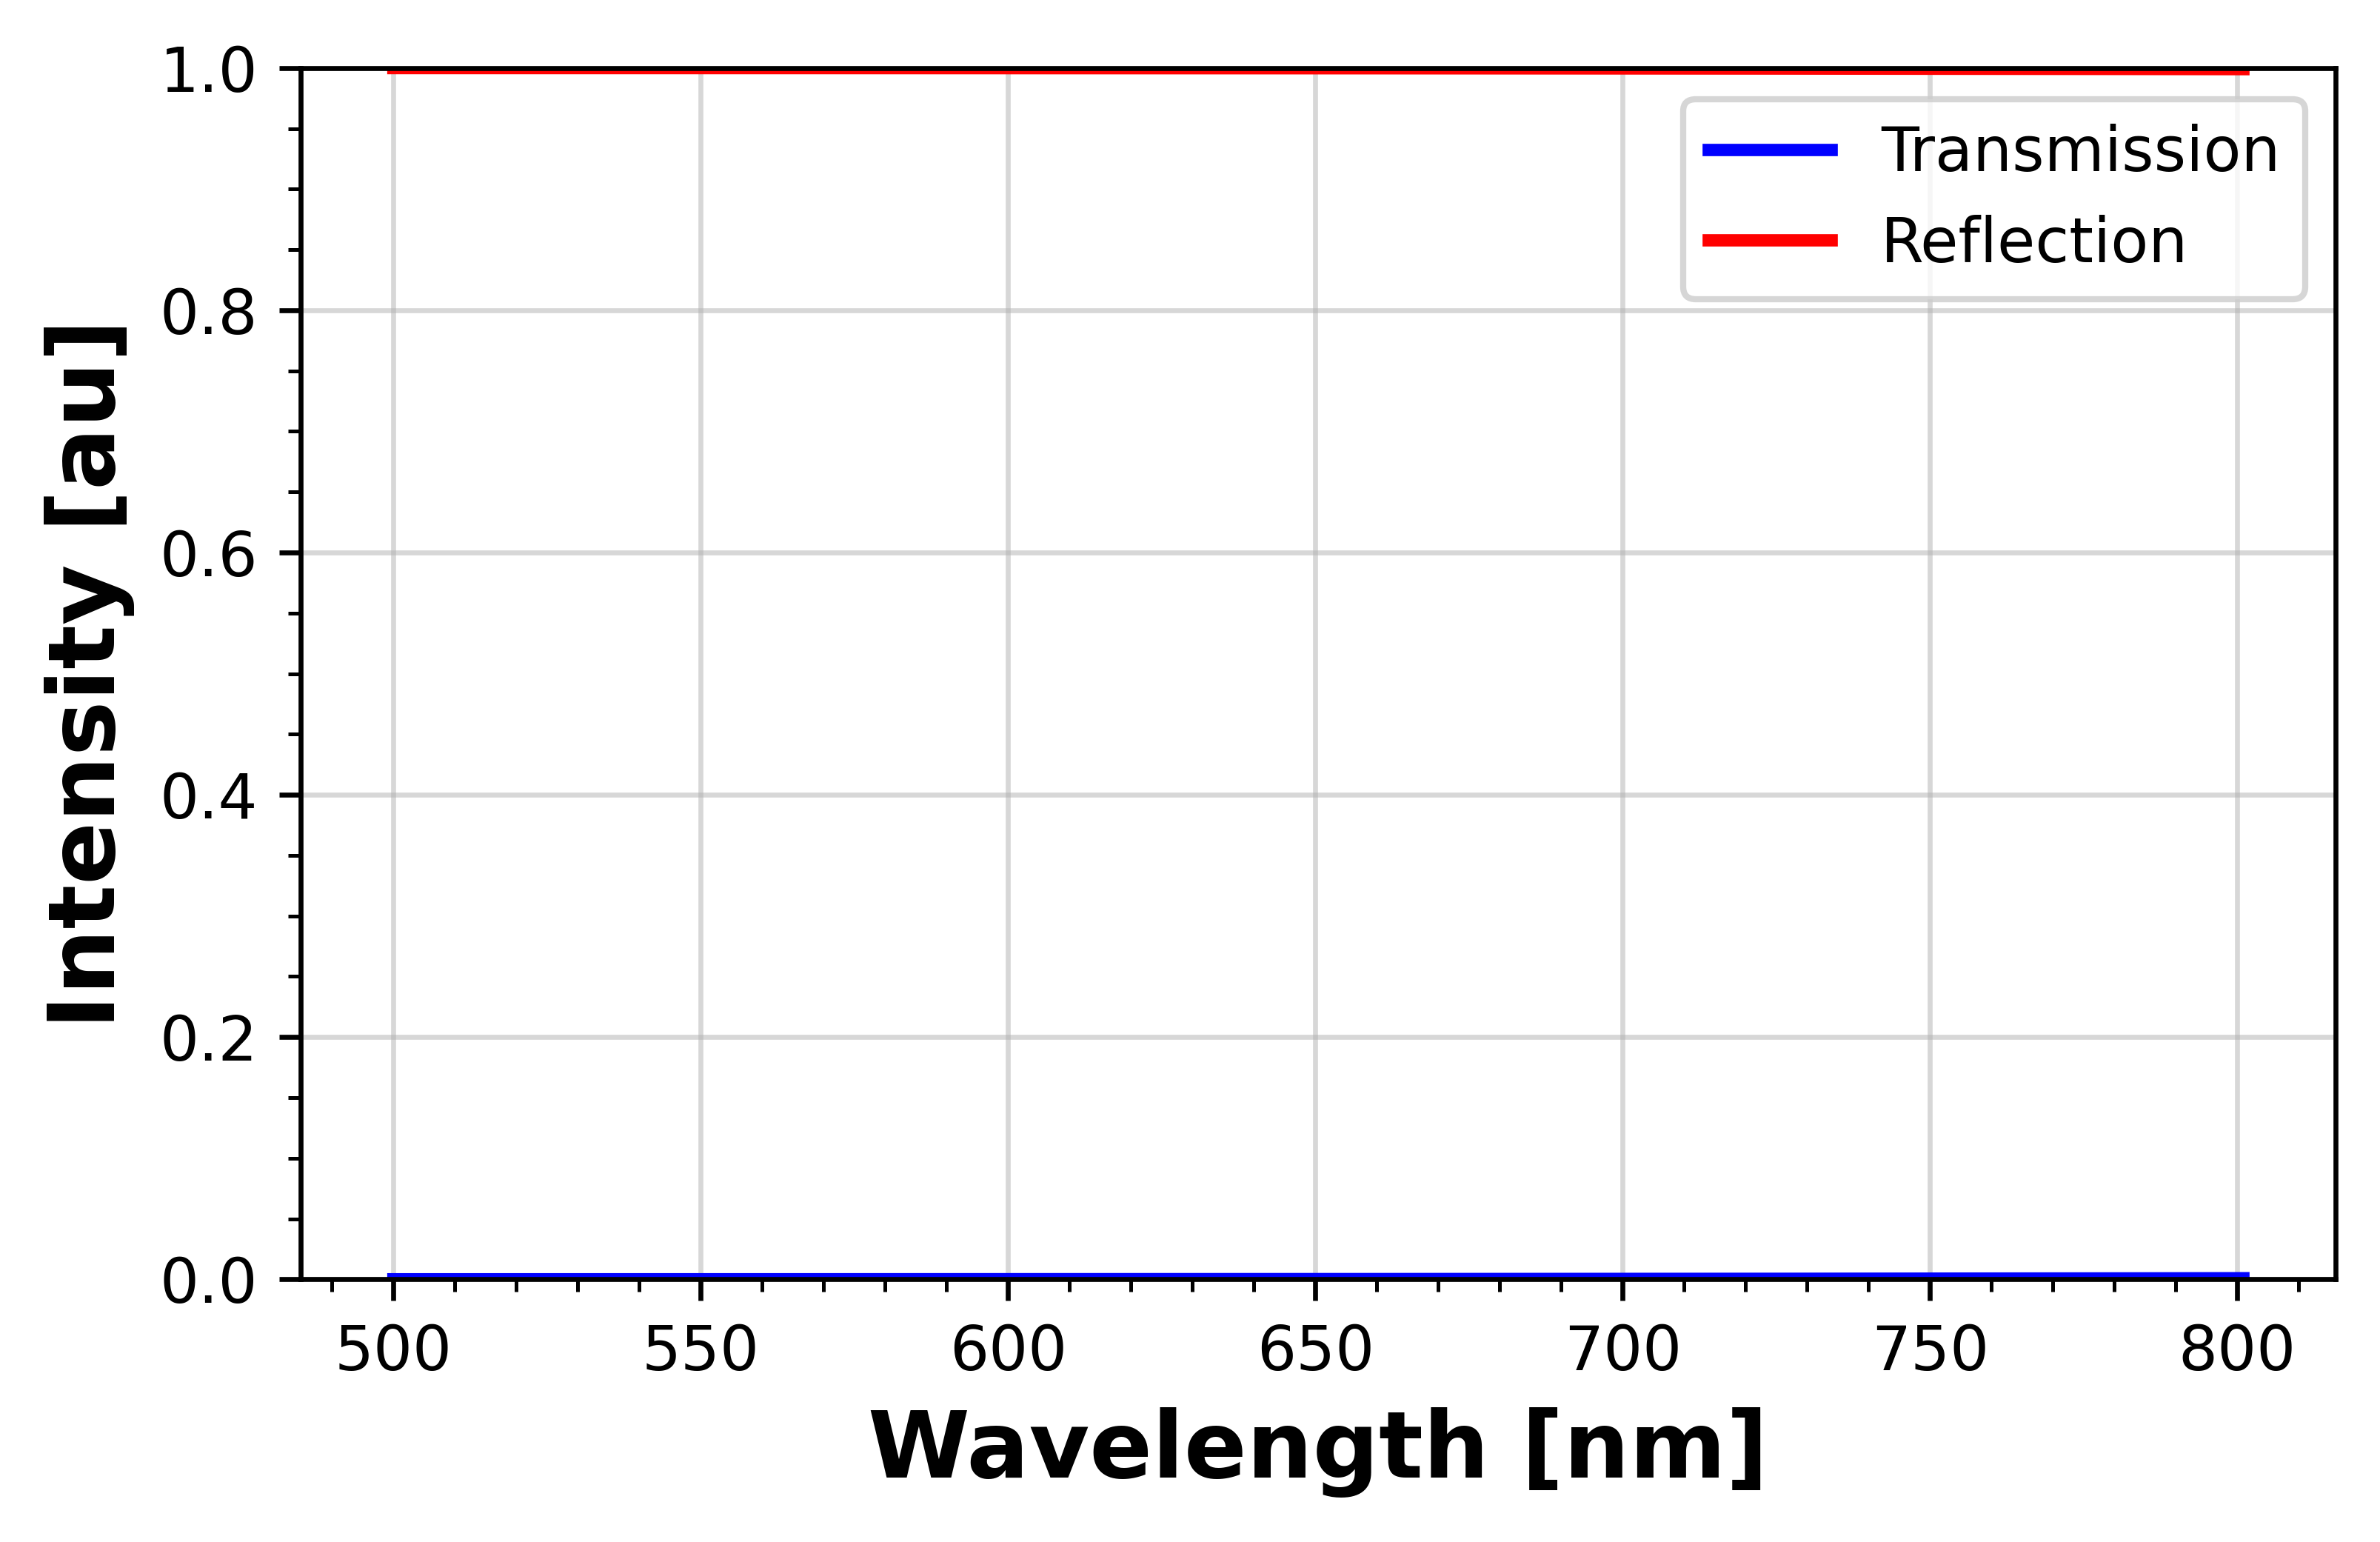

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\..\S4\Results\Nanohole_Radius\Radius_Sweep_50.png


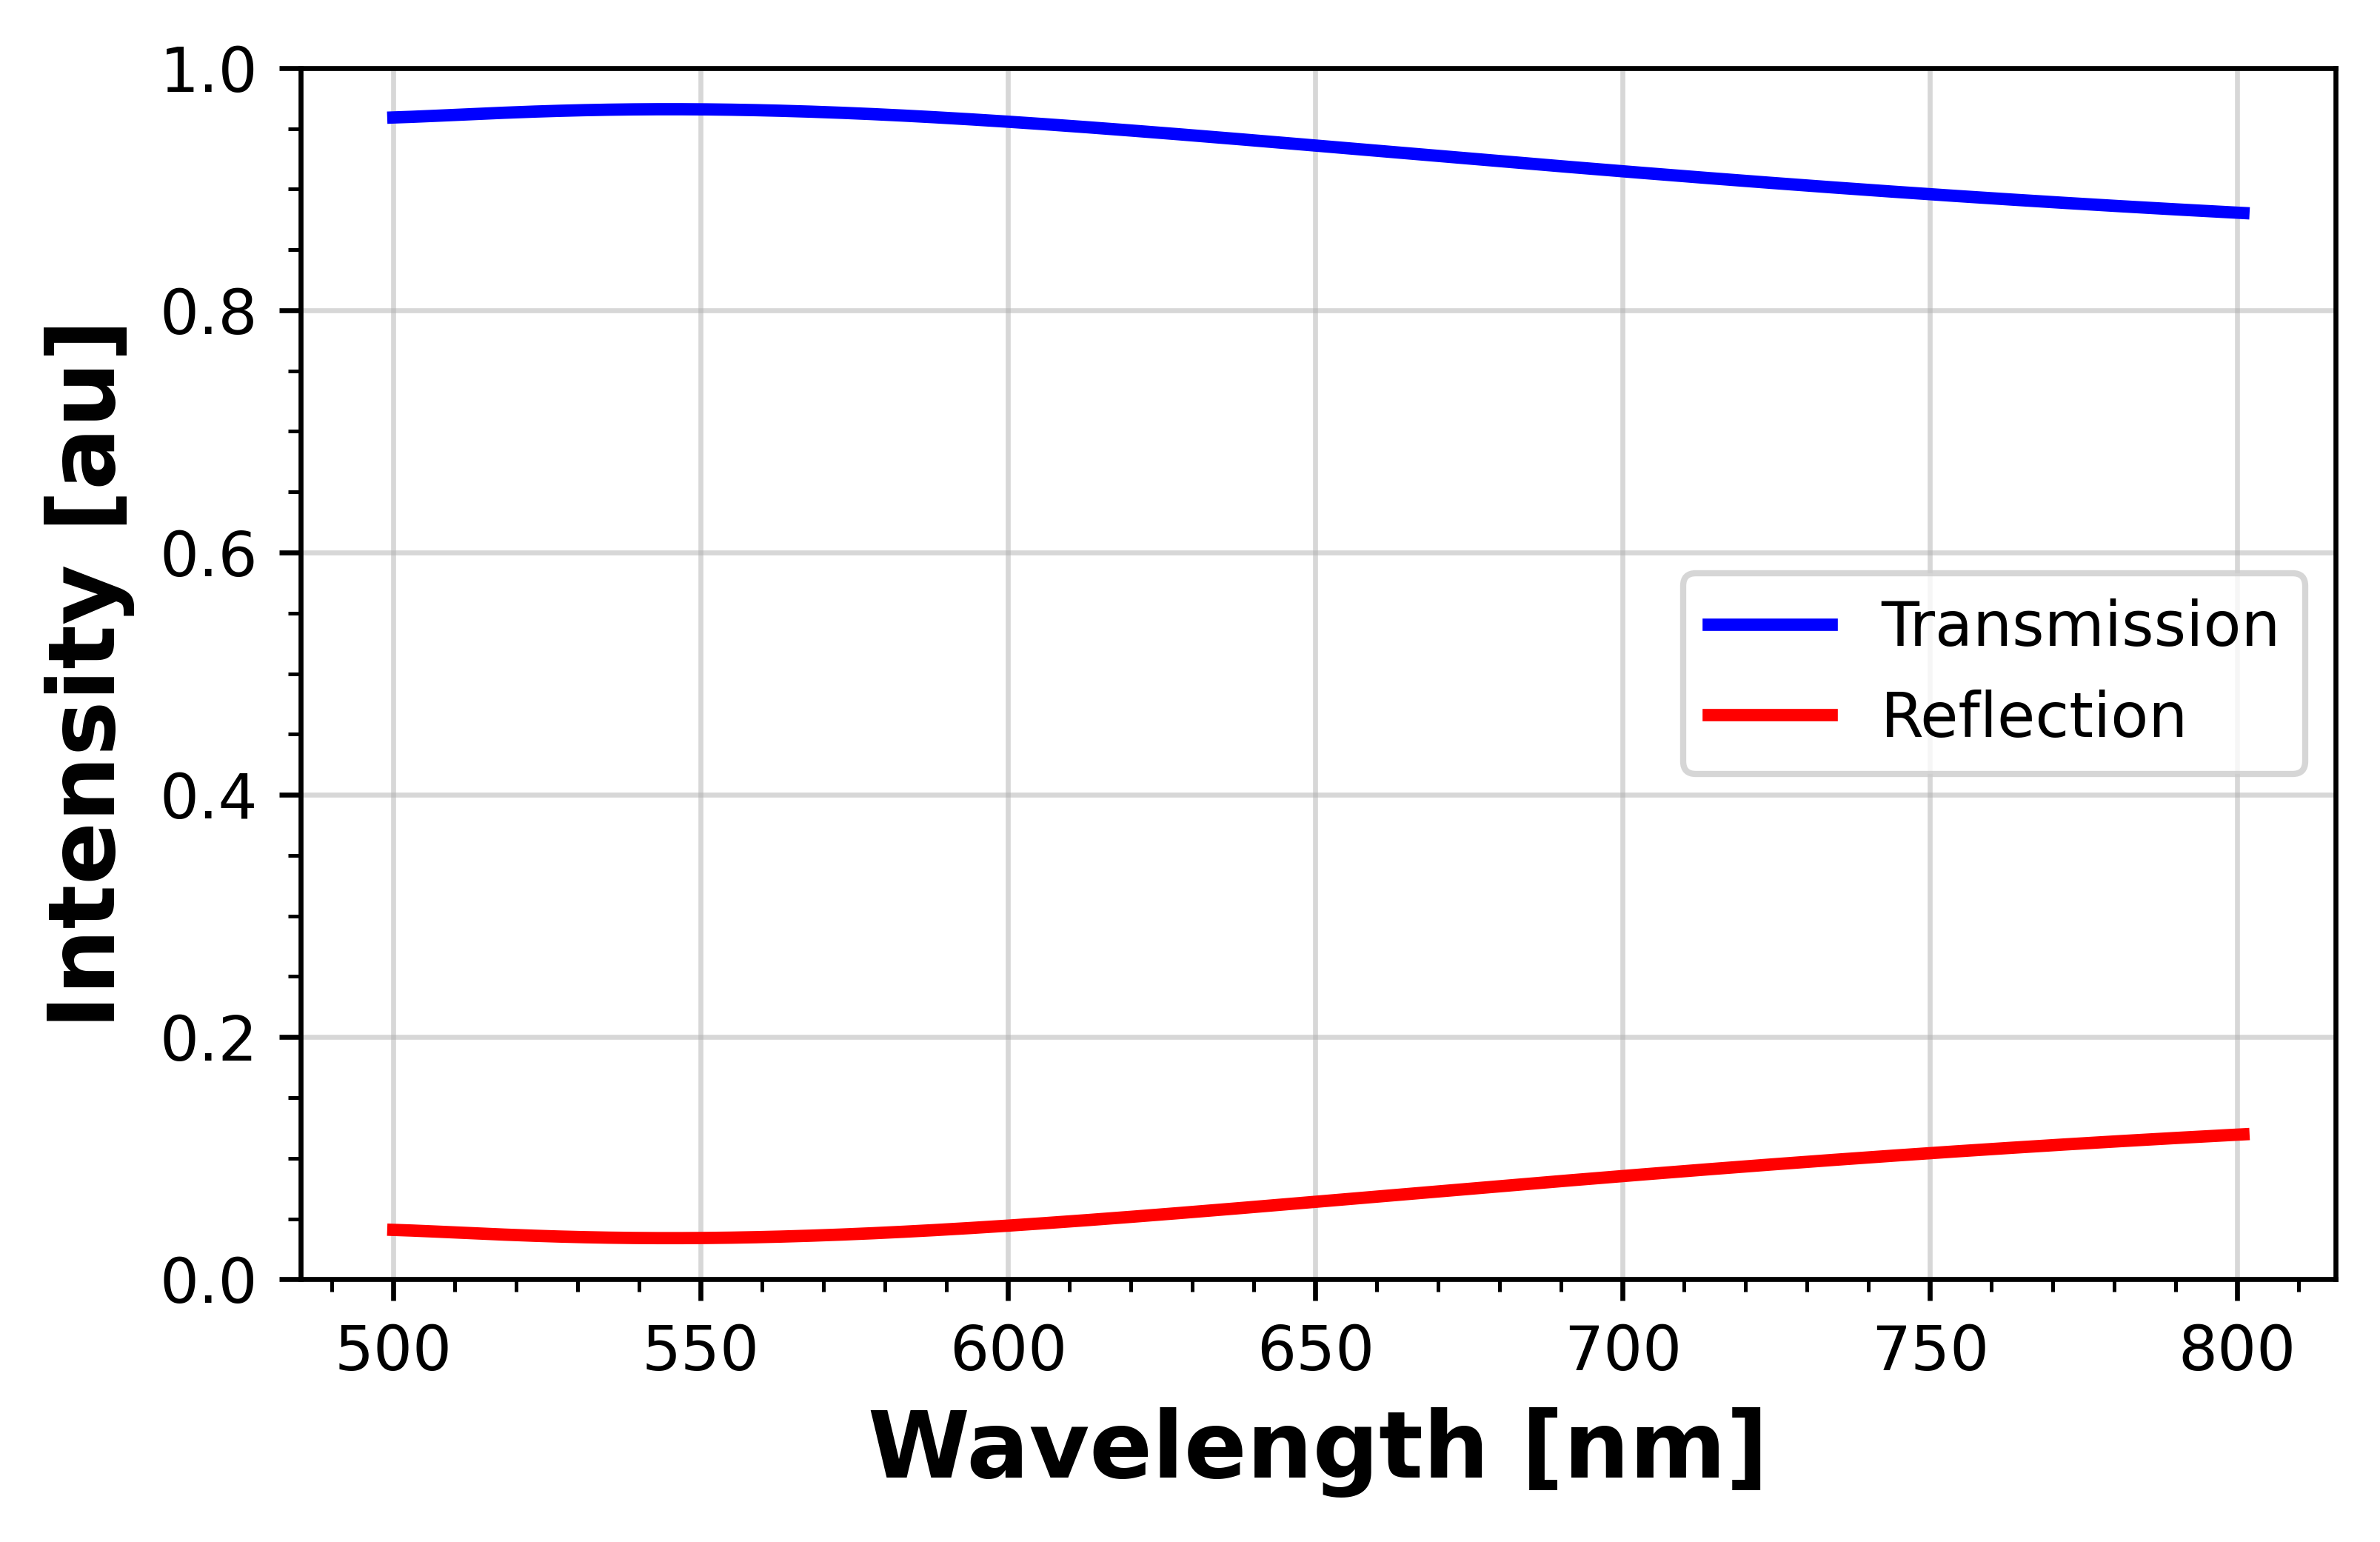

In [505]:
figure_path = Path(f'{root}/../S4/Results/Nanohole_Radius')
figures = os.listdir(figure_path)
for figure in figures:
    file_path = Path(f'{figure_path}/{figure}')
    print(file_path)
    display(
        Image(
            filename=file_path,
            width=900,
            height=530
    )
)

* The simulation needs more work, but at least we have some general working areas in which we can set up some gratings for Tim to work with.
* Obviously, larger holes are more desireable to observe with the SEM, but we can give a few across the chip so that we can work out what's going on.

### Database Design

* Now we have the grating thickness of 150 nm, and a rough idea of the hole radius and hole period.
* We need to set that in the database parameters.
* I will use a 500 $\mu m$ writefield and a text spacing of 100 $\mu m$.
* I'm going to use 3 beam doses, and group 4 sets of gratings.
  * Flat gratings
  * Negative flat gratings
  * Nanoholes
  * Chirped gratings
* Remember that dose factor is scaled by 1000 in KLayout.

#### Chip Outline

* Start by creating a zero dose chip outline, so that we can make sure all of the gratings will fit on the given chip size above.
* We just set the dose to zero and draw a box so that the inner side is the edge of the chip.

In [506]:
chip_cell = layout.create_cell('Chip_Outline')
layer = layout.layer(0, 0)
chip_bottom = db.DBox(
    db.DPoint(0, 0),
    (
        db.DPoint(0, 0) +
        db.DVector(
            chip_width,
            - 100
        )
    )
)
chip_left = db.DBox(
    db.DPoint(0, 0),
    (
        db.DPoint(0, 0) +
        db.DVector(
            -100,
            chip_height
        )
    )
)
chip_right = db.DBox(
    db.DPoint(chip_width, 0),
    (
        db.DPoint(chip_width, 0) +
        db.DVector(
            100,
            chip_height
        )
    )
)
chip_top = db.DBox(
    db.DPoint(0, chip_height),
    (
        db.DPoint(0, chip_height) +
        db.DVector(
            chip_width,
            100
        )
    )
)
chip_cell.shapes(layer).insert(chip_bottom)
chip_cell.shapes(layer).insert(chip_left)
chip_cell.shapes(layer).insert(chip_right)
chip_cell.shapes(layer).insert(chip_top)

box (0,15000000;15000000,15100000)


#### Flat Gratings

* Let's start with the flat gratings.
* Set up the dose cell, and period cell.
* There is no fill factor cell this time, as we will use the ones created for Sam's chip (Sam_SiN_Grating_231013.ipynb).

In [507]:
dose_factor_range = np.arange(1, 2.1, 0.5)
period_range = range(400, 501, 10)
fill_factor = 0.7
grating_spacing = 500
text_spacing = 100

flat_cell = layout.create_cell('Flat_Gratings')
for i, dose in enumerate(dose_factor_range):
    layer = layout.layer(i + 1, dose * 1000)
    dose_identifier = f'df{dose}'
    dose_cell = layout.create_cell(f'DF_{dose_identifier}')
    for j, period in enumerate(period_range):
        grating_period = period / 1000
        grating_identifier = f'{dose_identifier}_ff{fill_factor}_p{period}'
        bar_cell = layout.create_cell(f'Bar_{grating_identifier}')
        bar_origin = db.DPoint(0, 0)
        grating_bar = db.DBox(
            bar_origin,
            (
                bar_origin +
                db.DVector(
                    grating_period * fill_factor,
                    writefield_height
                )
            )
        )
        bar_cell.shapes(layer).insert(grating_bar)
        number_of_bars = math.floor(writefield_width / grating_period)
        grating_cell = layout.create_cell(f'Grating_{grating_identifier}')
        for n in range(0, number_of_bars):
            grating_cell.insert(
                db.DCellInstArray(
                    bar_cell.cell_index(),
                    db.DTrans(
                        n * grating_period,
                        0
                    )
                )
            )
        dose_cell.insert(
            db.DCellInstArray(
                grating_cell.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    flat_cell.insert(
        db.DCellInstArray(
            dose_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )

#### Adding Text

* The individual gratings are labelled with a number and then we are going to place the key next to the gratings.
* This is done using a dictionary.

In [508]:
text_magnification = 75
generator = db.TextGenerator.default_generator()
flat_cell_text = layout.create_cell("Flat_Gratings_Text")
text_layer = layout.layer(len(dose_factor_range) + 1, 2000)
gratings = {}
for i, dose in enumerate(dose_factor_range):
    dose_identifier = f'df{dose}'
    dose_cell_text = layout.create_cell(f'DF_{dose_identifier}_Text')
    for j, period in enumerate(period_range):
        grating_identifier = f'{dose_identifier}_ff{fill_factor}_p{period}'
        grating_number = f'{sample_identifier}.flat.{i}.{j}'
        gratings.update({grating_number: grating_identifier})
        grating_cell_text = layout.create_cell(
            f'Grating_{grating_identifier}_Text')
        region = generator.text(
            grating_number,
            layout.dbu,
            text_magnification)
        grating_cell_text.shapes(text_layer).insert(
            region,
            db.DTrans(
                db.DVector(
                    0,
                    writefield_height + text_spacing
                )
            )
        )
        dose_cell_text.insert(
            db.DCellInstArray(
                grating_cell_text.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    flat_cell_text.insert(
        db.DCellInstArray(
            dose_cell_text.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )

#### Negative Flat Gratings

* Let's do the negative flat gratings.
* Set up the dose cell, and period cell.
* We essentially can reverse the fill factor scalar.

In [509]:
dose_factor_range = np.arange(1, 2.1, 0.5)
period_range = range(400, 501, 10)
fill_factor = 0.3
grating_spacing = 500
text_spacing = 100

negative_cell = layout.create_cell('Negative_Gratings')
for i, dose in enumerate(dose_factor_range):
    layer = layout.layer(i + 1, dose * 1000)
    dose_identifier = f'df{dose}'
    dose_cell = layout.create_cell(f'DF_{dose_identifier}')
    for j, period in enumerate(period_range):
        grating_period = period / 1000
        grating_identifier = f'{dose_identifier}_ff{fill_factor}_p{period}'
        bar_cell = layout.create_cell(f'Bar_{grating_identifier}')
        bar_origin = db.DPoint(0, 0)
        grating_bar = db.DBox(
            bar_origin,
            (
                bar_origin +
                db.DVector(
                    grating_period * fill_factor,
                    writefield_height
                )
            )
        )
        bar_cell.shapes(layer).insert(grating_bar)
        number_of_bars = math.floor(writefield_width / grating_period)
        grating_cell = layout.create_cell(f'Grating_{grating_identifier}')
        for n in range(0, number_of_bars):
            grating_cell.insert(
                db.DCellInstArray(
                    bar_cell.cell_index(),
                    db.DTrans(
                        n * grating_period,
                        0
                    )
                )
            )
        dose_cell.insert(
            db.DCellInstArray(
                grating_cell.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    negative_cell.insert(
        db.DCellInstArray(
            dose_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )


#### Adding Text

* The individual gratings are labelled with a number and then we are going to place the key next to the gratings.
* This is done using a dictionary.

In [510]:
text_magnification = 75
generator = db.TextGenerator.default_generator()
negative_cell_text = layout.create_cell("Negative_Gratings_Text")
text_layer = layout.layer(len(dose_factor_range) + 1, 2000)
for i, dose in enumerate(dose_factor_range):
    dose_identifier = f'df{dose}'
    dose_cell_text = layout.create_cell(f'DF_{dose_identifier}_Text')
    for j, period in enumerate(period_range):
        grating_identifier = f'{dose_identifier}_ff{fill_factor}_p{period}'
        grating_number = f'{sample_identifier}.neg.{i}.{j}'
        gratings.update({grating_number: grating_identifier})
        grating_cell_text = layout.create_cell(
            f'Grating_{grating_identifier}_Text')
        region = generator.text(
            grating_number,
            layout.dbu,
            text_magnification)
        grating_cell_text.shapes(text_layer).insert(
            region,
            db.DTrans(
                db.DVector(
                    0,
                    writefield_height + text_spacing
                )
            )
        )
        dose_cell_text.insert(
            db.DCellInstArray(
                grating_cell_text.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    negative_cell_text.insert(
        db.DCellInstArray(
            dose_cell_text.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )


#### Nanoholes

* Let's do the nanohole now.
* Set up the dose cell, and period cell.
* We are going to change the hole radius by essentially changing the dose here.
* This is more of a "does this method work" test.

In [511]:
dose_factor_range = np.arange(1, 2.1, 0.5)
period_range = range(400, 501, 10)
feature_size = 100
hole_radius = feature_size / 2
radius = hole_radius / 1000
num_vertices = 64
grating_spacing = 500
text_spacing = 100

In [512]:
nanohole_cell = layout.create_cell('Nanoholes')
for i, dose in enumerate(dose_factor_range):
    layer = layout.layer(i + 1, dose * 1000)
    dose_identifier = f'df{dose}'
    dose_cell = layout.create_cell(f'DF_{dose_identifier}')
    for j, period in enumerate(period_range):
        grating_period = period / 1000
        grating_identifier = f'{dose_identifier}_r{hole_radius}_p{period}'
        hole_cell = layout.create_cell(f'Hole_{grating_identifier}')
        hole = db.DPolygon.ellipse(
            db.DBox(
                0 - radius,
                0 - radius,
                0 + radius,
                0 + radius
            ),
            num_vertices
        )
        hole_cell.shapes(layer).insert(hole)
        num_x_periods = math.floor(writefield_width / grating_period)
        num_y_periods = math.floor(writefield_height / grating_period)
        grating_cell = layout.create_cell(f'Grating_{grating_identifier}')
        for y in range(0, num_y_periods):
            for x in range(0, num_x_periods):
                grating_cell.insert(
                    db.DCellInstArray(
                        hole_cell.cell_index(),
                        db.DTrans(
                            x * grating_period,
                            y * grating_period
                        )
                    )
                )
        """
        grating_cell.insert(db.DCellInstArray(hole_cell.cell_index(), db.DTrans(0, 0)))
        """
        dose_cell.insert(
            db.DCellInstArray(
                grating_cell.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    nanohole_cell.insert(
        db.DCellInstArray(
            dose_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )

#### Adding Text

* The individual gratings are labelled with a number and then we are going to place the key next to the gratings.
* This is done using a dictionary.

In [513]:
text_magnification = 75
generator = db.TextGenerator.default_generator()
nanohole_cell_text = layout.create_cell("Nanoholes_Gratings_Text")
text_layer = layout.layer(len(dose_factor_range) + 1, 2000)
for i, dose in enumerate(dose_factor_range):
    dose_identifier = f'df{dose}'
    dose_cell_text = layout.create_cell(f'DF_{dose_identifier}_Text')
    for j, period in enumerate(period_range):
        grating_identifier = f'{dose_identifier}_r{hole_radius}_p{period}'
        grating_number = f'{sample_identifier}.hole.{i}.{j}'
        gratings.update({grating_number: grating_identifier})
        grating_cell_text = layout.create_cell(
            f'Grating_{grating_identifier}_Text')
        region = generator.text(
            grating_number,
            layout.dbu,
            text_magnification)
        grating_cell_text.shapes(text_layer).insert(
            region,
            db.DTrans(
                db.DVector(
                    0,
                    writefield_height + text_spacing
                )
            )
        )
        dose_cell_text.insert(
            db.DCellInstArray(
                grating_cell_text.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    nanohole_cell_text.insert(
        db.DCellInstArray(
            dose_cell_text.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )

#### Chirped Gratings

* Chirped gratings behave a little differently.
* It is common to design a chirped grating to build from the inside and expand in all directions.
* Here I will add a series of chirped gratings to the design.
* The chirped grating is a period chirp, so we need to set at least 3 periods:
  * The period at one edge
  * The middle period
  * The period at the other edge
* The rest of the parameters we will keep constant.

* Following Sam's guidelines, the generation of chirped gratings is done differently to the way I have generated the flat gratings and the nanohole arrays.
* Instead of generating a basic shape and patterning that into a coordinate system, Sam generates the coordinates of the box and then draws a polygon in that space.
* This seems a far simple way, and perhaps a way that could allow me to script the generation of shapes externally, as in outside this repository.
* This would, in turn, allow me to notebook properly and not just in this repository.

In [515]:
chirped_cell = layout.create_cell('Chirped_Gratings')
for i, dose in enumerate(dose_factor_range):
    layer = layout.layer(i + 1, dose * 1000)
    dose_identifier = f'df{dose}'
    dose_cell = layout.create_cell(f'DF_{dose_identifier}')
    for j, ff in enumerate(fill_factor_range):
        grating_periods = [p / 1000 for p in period_range]
        grating_identifier = f'{dose_identifier}_ff{ff}_p{period_range}'
        grating_cell = layout.create_cell(f'Chirped_{grating_identifier}')
        number_periods = math.floor(writefield_width / max(grating_periods))
        x_central = []
        for p, h in zip(grating_periods, heights):
            temporary = np.arange(
                - number_periods / 2 * p,
                (number_periods / 2 * p) + p,
                p)
            x_central.append(list(temporary))
        x_cen = list(
            np.asarray(x_central).reshape(len(grating_periods), -1).transpose())
        x_coords = []
        y_coords = []
        for x_c in x_cen:
            x_c = list(x_c)
            temporary_x = []
            temporary_y = []
            for xc, p, h in zip(x_c, grating_periods, heights):
                temporary_x.append(xc - (p / 2))
                temporary_y.append(h)
            for xc, p, h in zip(reversed(x_c), reversed(grating_periods), reversed(heights)):
                temporary_x.append(xc - (p / 2) + (p * (1 - ff)))
                temporary_y.append(h)
            x_coords.append(temporary_x)
            y_coords.append(temporary_y)
        for x, y in zip(x_coords, y_coords):
            points = []
            for point in zip(x, y):
                points.append(db.DPoint(*point))
            grating_cell.shapes(layer).insert(db.DPolygon(points))
        dose_cell.insert(
            db.DCellInstArray(
                grating_cell.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    chirped_cell.insert(
        db.DCellInstArray(
            dose_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )

#### Adding Text

* And once again we need to add text, and keys to the grating.

In [516]:
text_magnification = 75
generator = db.TextGenerator.default_generator()
chirped_cell_text = layout.create_cell("Chirped_Gratings_Text")
text_layer = layout.layer(len(dose_factor_range) + 1, 2000)
for i, dose in enumerate(dose_factor_range):
    dose_identifier = f'df{dose}'
    dose_cell_text = layout.create_cell(f'DF_{dose_identifier}_Text')
    for j, ff in enumerate(fill_factor_range):
        grating_identifier = f'{dose_identifier}_ff{ff}_p{period_range}'
        grating_number = f'{sample_identifier}.chirp.{i}.{j}'
        gratings.update({grating_number: grating_identifier})
        grating_cell_text = layout.create_cell(
            f'Grating_{grating_identifier}_Text')
        region = generator.text(
            grating_number,
            layout.dbu,
            text_magnification)
        grating_cell_text.shapes(text_layer).insert(
            region,
            db.DTrans(
                db.DVector(
                    0,
                    writefield_height + text_spacing
                )
            )
        )
        dose_cell_text.insert(
            db.DCellInstArray(
                grating_cell_text.cell_index(),
                db.DTrans(
                    db.DVector(
                        j * (writefield_width + grating_spacing),
                        0
                    )
                )
            )
        )
    chirped_cell_text.insert(
        db.DCellInstArray(
            dose_cell_text.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (writefield_height + grating_spacing)
                )
            )
        )
    )


#### Tim's Feature Measurements

* Finally, finally, finally, Tim wanted some bars to measure with the Dektak so that we can do feature width and depth measurements.
* These need to be significantly larger than the other gratings because the Dektak can't resolve anything smaller.
* However, we can treat it like a grating and just offset it from the pattern in much the same way.

In [517]:
measure_cell = layout.create_cell('Measure_Marks')
layer = layout.layer(5, 1000)
bar_cell = layout.create_cell(f'MeasureBar')
bar = db.DBox(
    db.DPoint(0, 0),
    (
        db.DPoint(0, 0) +
        db.DVector(
            500,
            1000
        )
    )
)
bar_cell.shapes(layer).insert(bar)
number_repeats = 3
for n in range(0, number_repeats):
    measure_cell.insert(
        db.DCellInstArray(
            bar_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    n * 1000,
                    0
                )
            )
        )
    )

## Adding Cells To Top

* We need to add all the cells to the top cell.
* Cell names:
  * chip_cell
  * flat_cell
  * negative_cell
  * nanohole_cell
  * chirped_cell

Note that the chirped cell is offset by -250 $\mu m$ due to the code. I have not found a way to fix this yet, and once I do I can fix it. But for now, let us just offset the pattern by 250.

Also, I need to offset the pattern by 1500 $\mu m$ in the Y-direction and 2250 $\mu m$ in the x-direction because I have set it up so that the pattern starts in the origin. In the future I can set up a "pattern" cell and fix it from there, but for now this will do.

In [518]:
x_shift = 2250
y_shift = 1500
transform_0 = db.ICplxTrans(1, 0, False, 0, 0)
transform_1 = db.ICplxTrans(1, 0, False, 0 + x_shift, y_shift + 0)
transform_2 = db.ICplxTrans(1, 0, False, 0 + x_shift, y_shift + 6 * grating_spacing)
transform_3 = db.ICplxTrans(1, 0, False, 0 + x_shift, y_shift + 12 * grating_spacing)
transform_4 = db.ICplxTrans(1, 0, False, 250 + x_shift, y_shift + 18 * grating_spacing)
transform_5 = db.ICplxTrans(1, 0, False, 11000, y_shift + 500 + 18 * grating_spacing)
transform_6 = db.ICplxTrans(1, 0, False, 11000, y_shift + 2000 + 18 * grating_spacing)
top_cell.insert(
    db.DCellInstArray(
        chip_cell.cell_index(),
        transform_0
    )
)
top_cell.insert(
    db.DCellInstArray(
        flat_cell.cell_index(),
        transform_1
    )
)
top_cell.insert(
    db.DCellInstArray(
        flat_cell_text.cell_index(),
        transform_1
    )
)
top_cell.insert(
    db.DCellInstArray(
        negative_cell.cell_index(),
        transform_2
    )
)
top_cell.insert(
    db.DCellInstArray(
        negative_cell_text.cell_index(),
        transform_2
    )
)
top_cell.insert(
    db.DCellInstArray(
        nanohole_cell.cell_index(),
        transform_3
    )
)
top_cell.insert(
    db.DCellInstArray(
        nanohole_cell_text.cell_index(),
        transform_3
    )
)
top_cell.insert(
    db.DCellInstArray(
        chirped_cell.cell_index(),
        transform_4
    )
)
top_cell.insert(
    db.DCellInstArray(
        chirped_cell_text.cell_index(),
        transform_4
    )
)
top_cell.insert(
    db.DCellInstArray(
        measure_cell.cell_index(),
        transform_5
    )
)
top_cell.insert(
    db.DCellInstArray(
        measure_cell.cell_index(),
        transform_6
    )
)

cell_index=379 r0 11000000,12500000

## Grating Keys

* Unlike in previous chips, I am not going to put the grating key on the sample, instead it will be printed in this notebook for future reference.
* I believe that part of the reason chips are taking so long to write is that they are full of text, these are complex and large shapes that are not all necessary.
* Particularly a full column of text is really not necessary to have when it could simply be a note somewhere else in the notebook.
* The gratings will still have labels, that can't be avoided, but the gratings dictionary containing the parameters can just go in here.

In [519]:
display(
    Markdown(
        '\n'.join(
            [f'{key}: {value}\n' for key, value in gratings.items()]
        )
    )
)

AM4-7.flat.0.0: df1.0_ff0.7_p400

AM4-7.flat.0.1: df1.0_ff0.7_p410

AM4-7.flat.0.2: df1.0_ff0.7_p420

AM4-7.flat.0.3: df1.0_ff0.7_p430

AM4-7.flat.0.4: df1.0_ff0.7_p440

AM4-7.flat.0.5: df1.0_ff0.7_p450

AM4-7.flat.0.6: df1.0_ff0.7_p460

AM4-7.flat.0.7: df1.0_ff0.7_p470

AM4-7.flat.0.8: df1.0_ff0.7_p480

AM4-7.flat.0.9: df1.0_ff0.7_p490

AM4-7.flat.0.10: df1.0_ff0.7_p500

AM4-7.flat.1.0: df1.5_ff0.7_p400

AM4-7.flat.1.1: df1.5_ff0.7_p410

AM4-7.flat.1.2: df1.5_ff0.7_p420

AM4-7.flat.1.3: df1.5_ff0.7_p430

AM4-7.flat.1.4: df1.5_ff0.7_p440

AM4-7.flat.1.5: df1.5_ff0.7_p450

AM4-7.flat.1.6: df1.5_ff0.7_p460

AM4-7.flat.1.7: df1.5_ff0.7_p470

AM4-7.flat.1.8: df1.5_ff0.7_p480

AM4-7.flat.1.9: df1.5_ff0.7_p490

AM4-7.flat.1.10: df1.5_ff0.7_p500

AM4-7.flat.2.0: df2.0_ff0.7_p400

AM4-7.flat.2.1: df2.0_ff0.7_p410

AM4-7.flat.2.2: df2.0_ff0.7_p420

AM4-7.flat.2.3: df2.0_ff0.7_p430

AM4-7.flat.2.4: df2.0_ff0.7_p440

AM4-7.flat.2.5: df2.0_ff0.7_p450

AM4-7.flat.2.6: df2.0_ff0.7_p460

AM4-7.flat.2.7: df2.0_ff0.7_p470

AM4-7.flat.2.8: df2.0_ff0.7_p480

AM4-7.flat.2.9: df2.0_ff0.7_p490

AM4-7.flat.2.10: df2.0_ff0.7_p500

AM4-7.neg.0.0: df1.0_ff0.3_p400

AM4-7.neg.0.1: df1.0_ff0.3_p410

AM4-7.neg.0.2: df1.0_ff0.3_p420

AM4-7.neg.0.3: df1.0_ff0.3_p430

AM4-7.neg.0.4: df1.0_ff0.3_p440

AM4-7.neg.0.5: df1.0_ff0.3_p450

AM4-7.neg.0.6: df1.0_ff0.3_p460

AM4-7.neg.0.7: df1.0_ff0.3_p470

AM4-7.neg.0.8: df1.0_ff0.3_p480

AM4-7.neg.0.9: df1.0_ff0.3_p490

AM4-7.neg.0.10: df1.0_ff0.3_p500

AM4-7.neg.1.0: df1.5_ff0.3_p400

AM4-7.neg.1.1: df1.5_ff0.3_p410

AM4-7.neg.1.2: df1.5_ff0.3_p420

AM4-7.neg.1.3: df1.5_ff0.3_p430

AM4-7.neg.1.4: df1.5_ff0.3_p440

AM4-7.neg.1.5: df1.5_ff0.3_p450

AM4-7.neg.1.6: df1.5_ff0.3_p460

AM4-7.neg.1.7: df1.5_ff0.3_p470

AM4-7.neg.1.8: df1.5_ff0.3_p480

AM4-7.neg.1.9: df1.5_ff0.3_p490

AM4-7.neg.1.10: df1.5_ff0.3_p500

AM4-7.neg.2.0: df2.0_ff0.3_p400

AM4-7.neg.2.1: df2.0_ff0.3_p410

AM4-7.neg.2.2: df2.0_ff0.3_p420

AM4-7.neg.2.3: df2.0_ff0.3_p430

AM4-7.neg.2.4: df2.0_ff0.3_p440

AM4-7.neg.2.5: df2.0_ff0.3_p450

AM4-7.neg.2.6: df2.0_ff0.3_p460

AM4-7.neg.2.7: df2.0_ff0.3_p470

AM4-7.neg.2.8: df2.0_ff0.3_p480

AM4-7.neg.2.9: df2.0_ff0.3_p490

AM4-7.neg.2.10: df2.0_ff0.3_p500

AM4-7.hole.0.0: df1.0_r50.0_p400

AM4-7.hole.0.1: df1.0_r50.0_p410

AM4-7.hole.0.2: df1.0_r50.0_p420

AM4-7.hole.0.3: df1.0_r50.0_p430

AM4-7.hole.0.4: df1.0_r50.0_p440

AM4-7.hole.0.5: df1.0_r50.0_p450

AM4-7.hole.0.6: df1.0_r50.0_p460

AM4-7.hole.0.7: df1.0_r50.0_p470

AM4-7.hole.0.8: df1.0_r50.0_p480

AM4-7.hole.0.9: df1.0_r50.0_p490

AM4-7.hole.0.10: df1.0_r50.0_p500

AM4-7.hole.1.0: df1.5_r50.0_p400

AM4-7.hole.1.1: df1.5_r50.0_p410

AM4-7.hole.1.2: df1.5_r50.0_p420

AM4-7.hole.1.3: df1.5_r50.0_p430

AM4-7.hole.1.4: df1.5_r50.0_p440

AM4-7.hole.1.5: df1.5_r50.0_p450

AM4-7.hole.1.6: df1.5_r50.0_p460

AM4-7.hole.1.7: df1.5_r50.0_p470

AM4-7.hole.1.8: df1.5_r50.0_p480

AM4-7.hole.1.9: df1.5_r50.0_p490

AM4-7.hole.1.10: df1.5_r50.0_p500

AM4-7.hole.2.0: df2.0_r50.0_p400

AM4-7.hole.2.1: df2.0_r50.0_p410

AM4-7.hole.2.2: df2.0_r50.0_p420

AM4-7.hole.2.3: df2.0_r50.0_p430

AM4-7.hole.2.4: df2.0_r50.0_p440

AM4-7.hole.2.5: df2.0_r50.0_p450

AM4-7.hole.2.6: df2.0_r50.0_p460

AM4-7.hole.2.7: df2.0_r50.0_p470

AM4-7.hole.2.8: df2.0_r50.0_p480

AM4-7.hole.2.9: df2.0_r50.0_p490

AM4-7.hole.2.10: df2.0_r50.0_p500

AM4-7.chirp.0.0: df1.0_ff0.1_p[450, 350, 450]

AM4-7.chirp.0.1: df1.0_ff0.2_p[450, 350, 450]

AM4-7.chirp.0.2: df1.0_ff0.30000000000000004_p[450, 350, 450]

AM4-7.chirp.0.3: df1.0_ff0.4_p[450, 350, 450]

AM4-7.chirp.0.4: df1.0_ff0.5_p[450, 350, 450]

AM4-7.chirp.0.5: df1.0_ff0.6_p[450, 350, 450]

AM4-7.chirp.0.6: df1.0_ff0.7000000000000001_p[450, 350, 450]

AM4-7.chirp.0.7: df1.0_ff0.8_p[450, 350, 450]

AM4-7.chirp.1.0: df1.5_ff0.1_p[450, 350, 450]

AM4-7.chirp.1.1: df1.5_ff0.2_p[450, 350, 450]

AM4-7.chirp.1.2: df1.5_ff0.30000000000000004_p[450, 350, 450]

AM4-7.chirp.1.3: df1.5_ff0.4_p[450, 350, 450]

AM4-7.chirp.1.4: df1.5_ff0.5_p[450, 350, 450]

AM4-7.chirp.1.5: df1.5_ff0.6_p[450, 350, 450]

AM4-7.chirp.1.6: df1.5_ff0.7000000000000001_p[450, 350, 450]

AM4-7.chirp.1.7: df1.5_ff0.8_p[450, 350, 450]

AM4-7.chirp.2.0: df2.0_ff0.1_p[450, 350, 450]

AM4-7.chirp.2.1: df2.0_ff0.2_p[450, 350, 450]

AM4-7.chirp.2.2: df2.0_ff0.30000000000000004_p[450, 350, 450]

AM4-7.chirp.2.3: df2.0_ff0.4_p[450, 350, 450]

AM4-7.chirp.2.4: df2.0_ff0.5_p[450, 350, 450]

AM4-7.chirp.2.5: df2.0_ff0.6_p[450, 350, 450]

AM4-7.chirp.2.6: df2.0_ff0.7000000000000001_p[450, 350, 450]

AM4-7.chirp.2.7: df2.0_ff0.8_p[450, 350, 450]


## Database Write Out

* Finish by writing the database to a file.

In [520]:
layout.write(f'{out_path}/NIL_Masters_231013.gds')

## Comments

* The pattern file is enormous, there is clearly something not right about it.
* Chris wondered whether the nanoholes were writing multiple versions over the top and thereby increasing the file size.
* Given the size of the file, I am not able to check this as it takes far too long to load.
* There was a problem writing the file, when the voyager reached the nanohole array, the pattern generator paused and didn't write.
* It then stayed there all night in the overnight slot and didn't progress.
* This could again be due to complexity, or due to multiple objects on top of each other.
* It is recommended that we break down the layers and portions into different files.
* Perhaps the number of layers is causing an issue with the write too.
* Only AM5 was exposed using this pattern, so I will work to fix this issue for the next batch.